In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters

from scipy.stats.contingency import margins
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.stats import skew

from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import anomaly
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator

import pyod
import skimage as ski
from skimage import util as skiutil
register_matplotlib_converters()

### Prep steps

In [2]:
df=pd.read_csv('./data/289LLC_Fill_Quality.csv', parse_dates=['TIMESTAMP','SHIFTDATE'])

In [3]:
# remove shift date as pandas interpolate in time doesn't like columns with time stamps
#  and prepare multi-index needed for running Monitor functions in this notebook
df_i = df.set_index(['DEVICEID','TIMESTAMP']).drop(columns=['SHIFTDATE'])
df_i.columns

Index(['DEVICETYPE', 'SHIFTNAME', 'SHIFTID', 'EQKEY', 'EQID', 'EQNAME',
       'TOOLNAME', 'AVI_PRG_NUM', 'AVI_PRG_TEXT', 'ACT_PRG_NUM',
       'ACT_PRG_TEXT', 'FAULT_CODE', 'FAULT_CODE_TEXT', 'JOB_STATUS',
       'JOB_STATUS_TEXT', 'DATACOUNT', 'D01_TOOLDATANAME', 'D01_VALUE',
       'D01_UOM', 'D01_DATA_STATUS', 'D01_DATA_STATUS_TEXT',
       'D02_TOOLDATANAME', 'D02_VALUE', 'D02_UOM', 'D02_DATA_STATUS',
       'D02_DATA_STATUS_TEXT', 'D03_TOOLDATANAME', 'D03_VALUE', 'D03_UOM',
       'D03_DATA_STATUS', 'D03_DATA_STATUS_TEXT', 'D04_TOOLDATANAME',
       'D04_VALUE', 'D04_UOM', 'D04_DATA_STATUS', 'D04_DATA_STATUS_TEXT',
       'SHOPKEY', 'LINEKEY', 'LINEID', 'LINENAME', 'SHORTNAME', 'ASSEMBLY_NUM',
       'VIN_NUM', 'ICSRESPONSECODE', 'ICSRESPONSETEXT', 'IICSPROCESSTIME',
       'CYCLE_TIME', 'CYCLE_COUNTER', 'BODYNUM', 'CARRIERNUM', 'BADGENUM'],
      dtype='object')

In [4]:
# Inputsize as determined from the log
# 73, 82, 93, 103, 111, 121, 130, 138, 144, 154, 165, 170, 175, 180, 185, 190, 204, 209
#   with grep Inputsize *.log | grep GunPressure_Kmeans | less
sizes = [73, 82, 93, 103, 111, 121, 130, 138, 144, 154, 165, 170, 175, 180, 185, 190, 204, 209]

# prepare data frames to be passed to the KMeansAnomalyScorer to 
#    replay the anomaly scoring analogous to the pipeline runs reflected in the logs
dfs = []
for s in sizes:
    dfs.append(df_i[0:s].copy())
    

In [5]:
# dummy db handler for Monitor function execution
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()

In [6]:
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test = anomaly.KMeansAnomalyScore('D04_VALUE', 5, 'GunPressure_Kmeans')
et = test._build_entity_type(columns = [Column('GunPressure_Kmeans',Float())], **jobsettings)
test._entity_type = et
test.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2022-10-24T19:23:16.413 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:16.416 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-24T19:23:16.418 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-24T19:23:16.421 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:16.423 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:16.425 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221024172316
2022-10-24T19:23:16.426 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:16.429 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:16.430 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:16.431 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Fu

In [7]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et = test._build_entity_type(columns = [Column('GunPressure_Kmeans',Float())], **jobsettings)
    test._entity_type = et
    dfs[i] = test.execute(df=dfs[i])

2022-10-24T19:23:17.378 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:17.381 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:17.383 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:17.385 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221024172317
2022-10-24T19:23:17.387 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:17.388 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:17.390 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:17.391 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:17.393 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-24T19:23:17.

2022-10-24T19:23:17.700 DEBUG numba.core.byteflow.dispatch dispatch pc=32, inst=CALL_METHOD(arg=1, lineno=71)
2022-10-24T19:23:17.700 DEBUG numba.core.byteflow.dispatch stack ['$18load_method.7', '$30call_function_kw.13']
2022-10-24T19:23:17.701 DEBUG numba.core.byteflow.dispatch dispatch pc=34, inst=LOAD_METHOD(arg=4, lineno=71)
2022-10-24T19:23:17.701 DEBUG numba.core.byteflow.dispatch stack ['$32call_method.14']
2022-10-24T19:23:17.701 DEBUG numba.core.byteflow.dispatch dispatch pc=36, inst=CALL_METHOD(arg=0, lineno=71)
2022-10-24T19:23:17.702 DEBUG numba.core.byteflow.dispatch stack ['$34load_method.15']
2022-10-24T19:23:17.702 DEBUG numba.core.byteflow.dispatch dispatch pc=38, inst=RETURN_VALUE(arg=None, lineno=71)
2022-10-24T19:23:17.702 DEBUG numba.core.byteflow.dispatch stack ['$36call_method.16']
2022-10-24T19:23:17.702 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:17.703 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs------------

2022-10-24T19:23:17.731 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $38return_value.17
2022-10-24T19:23:17.731 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10binary_subtract.4': [<numba.core.ir.Assign object at 0x7f2a74407af0>],
             '$16load_global.6': [<numba.core.ir.Assign object at 0x7f2a74407ee0>],
             '$18load_method.7': [<numba.core.ir.Assign object at 0x7f2a7444c0a0>],
             '$20load_global.8': [<numba.core.ir.Assign object at 0x7f2a7444c220>],
             '$22load_attr.9': [<numba.core.ir.Assign object at 0x7f2a7444c3a0>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7f2a74407580>],
             '$30call_function_kw.13': [<numba.core.ir.Assign object at 0x7f2a7444cac0>],
             '$32call_method.14': [<numba.core.ir.Assign object at 0x7f2a7444cbb0>],
             '$34load_method.15': [<numba.core.ir.Assign object at 0x7f2a7444cca0>],
             '$36call_method.16': [<

2022-10-24T19:23:17.805 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:17.805 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:17.806 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=205)
2022-10-24T19:23:17.806 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:17.806 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=205)
2022-10-24T19:23:17.807 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:17.807 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=2, lineno=205)
2022-10-24T19:23:17.807 DEBUG numba.core.byteflow.dispatch stack ['$src_ndim2.0']
2022-10-24T19:23:17.808 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=COMPARE_OP(arg=4, lineno=205)
2022-10-24T19:23:17.808 DEBUG numba.core.byteflow.dispatch stack ['$src_ndim2.0', '$dest_ndim4.1']
2022-10-24T19:23:17.808 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=P

2022-10-24T19:23:17.842 DEBUG numba.core.byteflow.dispatch dispatch pc=62, inst=COMPARE_OP(arg=3, lineno=221)
2022-10-24T19:23:17.843 DEBUG numba.core.byteflow.dispatch stack ['$src_dim_size58.0', '$dest_dim_size60.1']
2022-10-24T19:23:17.843 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=POP_JUMP_IF_FALSE(arg=43, lineno=221)
2022-10-24T19:23:17.844 DEBUG numba.core.byteflow.dispatch stack ['$62compare_op.2']
2022-10-24T19:23:17.847 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=66, stack=(), blockstack=(), npush=0), Edge(pc=84, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:17.849 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=86 nstack_initial=0), State(pc_initial=66 nstack_initial=0), State(pc_initial=84 nstack_initial=0)])
2022-10-24T19:23:17.850 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:17.851 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_FAST(arg=6, lineno=223)
2022-10-24T19:23:17.852 DEBUG numba.core.byteflow.d

2022-10-24T19:23:17.898 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:17.899 DEBUG numba.core.byteflow.dispatch dispatch pc=76, inst=LOAD_CONST(arg=2, lineno=222)
2022-10-24T19:23:17.899 DEBUG numba.core.byteflow.dispatch stack ['$dest_index74.0']
2022-10-24T19:23:17.900 DEBUG numba.core.byteflow.dispatch dispatch pc=78, inst=BINARY_ADD(arg=None, lineno=222)
2022-10-24T19:23:17.900 DEBUG numba.core.byteflow.dispatch stack ['$dest_index74.0', '$const76.1']
2022-10-24T19:23:17.901 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=UNARY_NEGATIVE(arg=None, lineno=222)
2022-10-24T19:23:17.901 DEBUG numba.core.byteflow.dispatch stack ['$78binary_add.2']
2022-10-24T19:23:17.902 DEBUG numba.core.byteflow.dispatch dispatch pc=82, inst=RETURN_VALUE(arg=None, lineno=222)
2022-10-24T19:23:17.902 DEBUG numba.core.byteflow.dispatch stack ['$80unary_negative.3']
2022-10-24T19:23:17.903 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:17.905 DEBUG numba.core.byte

2022-10-24T19:23:17.926 DEBUG numba.core.byteflow.run block_infos State(pc_initial=126 nstack_initial=0):
AdaptBlockInfo(insts=((126, {'res': '$dest_index126.0'}), (128, {'retval': '$dest_index126.0', 'castval': '$128return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:17.933 DEBUG numba.core.interpreter.interpret label 0:
    src_ndim = arg(0, name=src_ndim)         ['src_ndim']
    src_shape = arg(1, name=src_shape)       ['src_shape']
    dest_ndim = arg(2, name=dest_ndim)       ['dest_ndim']
    dest_shape = arg(3, name=dest_shape)     ['dest_shape']
    $6compare_op.2 = src_ndim > dest_ndim    ['$6compare_op.2', 'dest_ndim', 'src_ndim']
    bool8 = global(bool: <class 'bool'>)     ['bool8']
    $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None, varkwarg=None, target=None) ['$6compare_op.2', '$8pred', 'bool8']
    branch $8pred, 10, 14                    ['

2022-10-24T19:23:17.975 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool32 = global(bool: <class 'bool'>)
2022-10-24T19:23:17.975 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $32pred = call bool32($30compare_op.6, func=bool32, args=(Var($30compare_op.6, npyimpl.py:212),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:17.976 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $32pred, 34, 126
2022-10-24T19:23:17.976 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 34
2022-10-24T19:23:17.977 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a7447f1c0>
2022-10-24T19:23:17.977 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
2022-10-24T19:23:17.978 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
2022-1

2022-10-24T19:23:18.024 DEBUG numba.core.ssa._find_defs_violators SSA violators {'src_index', 'dest_index'}
2022-10-24T19:23:18.025 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var src_index
2022-10-24T19:23:18.025 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:18.026 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a7447ff40>
2022-10-24T19:23:18.027 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_ndim = arg(0, name=src_ndim)
2022-10-24T19:23:18.028 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_shape = arg(1, name=src_shape)
2022-10-24T19:23:18.028 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_ndim = arg(2, name=dest_ndim)
2022-10-24T19:23:18.028 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape = arg(3, name=dest_shape)
2022-10-24T19:23:18.030 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $6compare_op.2 = src_ndim > dest_ndim
2022-10-24T19:23:18.032 DEB

2022-10-24T19:23:18.059 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape[dest_index] = src_dim_size
2022-10-24T19:23:18.060 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 102
2022-10-24T19:23:18.060 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 102
2022-10-24T19:23:18.061 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a7447ff40>
2022-10-24T19:23:18.061 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const104.1 = const(int, 1)
2022-10-24T19:23:18.062 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $106inplace_add.2 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=src_index, rhs=$const104.1, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:18.062 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_index = $106inplace_add.2
2022-10-24T19:23:18.062 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: src_index.1 = $106inplace_add.2
2022-

2022-10-24T19:23:18.095 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $64pred, 66, 84
2022-10-24T19:23:18.095 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 66
2022-10-24T19:23:18.096 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a7447ff40>
2022-10-24T19:23:18.096 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const68.1 = const(int, 1)
2022-10-24T19:23:18.097 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70compare_op.2 = src_dim_size != $const68.1
2022-10-24T19:23:18.097 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool72 = global(bool: <class 'bool'>)
2022-10-24T19:23:18.097 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72pred = call bool72($70compare_op.2, func=bool72, args=(Var($70compare_op.2, npyimpl.py:221),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:18.098 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $72pred, 74, 84
2022-10-24T19:23:18.099 DEBU

2022-10-24T19:23:18.142 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12return_value.1 = cast(value=$const10.0)
2022-10-24T19:23:18.143 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $12return_value.1
2022-10-24T19:23:18.143 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 14
2022-10-24T19:23:18.144 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a7447fd30>
2022-10-24T19:23:18.145 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_index = const(int, 0)
2022-10-24T19:23:18.146 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_index = dest_ndim - src_ndim
2022-10-24T19:23:18.147 DEBUG numba.core.ssa.on_assign first assign: dest_index
2022-10-24T19:23:18.148 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: dest_index = dest_ndim - src_ndim
2022-10-24T19:23:18.149 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30compare_op.6 = src_index < src_ndim
2022-10-24T19:23:18.150 DEBUG numba.cor

2022-10-24T19:23:18.223 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool124 = global(bool: <class 'bool'>)
2022-10-24T19:23:18.230 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $124pred = call bool124($122compare_op.8, func=bool124, args=(Var($122compare_op.8, npyimpl.py:212),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:18.231 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $124pred, 34, 126
2022-10-24T19:23:18.232 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 126
2022-10-24T19:23:18.232 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a7447fd30>
2022-10-24T19:23:18.233 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $128return_value.1 = cast(value=dest_index)
2022-10-24T19:23:18.234 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $128return_value.1
2022-10-24T19:23:18.234 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
         

2022-10-24T19:23:18.301 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78binary_add.2 = dest_index + $const76.1
2022-10-24T19:23:18.303 DEBUG numba.core.ssa._find_def find_def var='dest_index' stmt=$78binary_add.2 = dest_index + $const76.1
2022-10-24T19:23:18.304 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 74
2022-10-24T19:23:18.305 DEBUG numba.core.ssa._find_def_from_top idom 66 from label 74
2022-10-24T19:23:18.305 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 66
2022-10-24T19:23:18.307 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 66
2022-10-24T19:23:18.308 DEBUG numba.core.ssa._find_def_from_top idom 58 from label 66
2022-10-24T19:23:18.309 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 58
2022-10-24T19:23:18.310 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 58
2022-10-24T19:23:18.311 DEBUG numba.core.ssa._find_def_from_top idom 34 from label 58
2022-10-24T19:23:18.312 DEBUG n

2022-10-24T19:23:18.434 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:18.434 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:18.435 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=3979)
2022-10-24T19:23:18.435 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:18.435 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=3979)
2022-10-24T19:23:18.436 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:18.437 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_METHOD(arg=0, lineno=3979)
2022-10-24T19:23:18.438 DEBUG numba.core.byteflow.dispatch stack ['$arrtype2.0']
2022-10-24T19:23:18.438 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=3979)
2022-10-24T19:23:18.438 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2022-10-24T19:23:18.439 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_FAST(a

2022-10-24T19:23:18.476 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'res': '$allocsize4.1'}), (6, {'res': '$align6.2'}), (8, {'func': '$2load_global.0', 'args': ['$allocsize4.1', '$align6.2'], 'res': '$8call_function.3'}), (10, {'retval': '$8call_function.3', 'castval': '$10return_value.4'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:18.477 DEBUG numba.core.interpreter.interpret label 0:
    cls = arg(0, name=cls)                   ['cls']
    allocsize = arg(1, name=allocsize)       ['allocsize']
    align = arg(2, name=align)               ['align']
    $2load_global.0 = global(intrin_alloc: <intrinsic intrin_alloc>) ['$2load_global.0']
    $8call_function.3 = call $2load_global.0(allocsize, align, func=$2load_global.0, args=[Var(allocsize, arrayobj.py:3972), Var(align, arrayobj.py:3972)], kws=(), vararg=None, varkwarg=None, 

2022-10-24T19:23:18.560 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:18.564 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=200)
           2	LOAD_FAST(arg=0, lineno=200)
           4	LOAD_ATTR(arg=0, lineno=200)
           6	STORE_FAST(arg=2, lineno=200)
           8	LOAD_DEREF(arg=1, lineno=202)
          10	POP_JUMP_IF_TRUE(arg=19, lineno=202)
          12	LOAD_FAST(arg=1, lineno=204)
          14	LOAD_CONST(arg=1, lineno=204)
          16	COMPARE_OP(arg=0, lineno=204)
          18	POP_JUMP_IF_TRUE(arg=15, lineno=204)
          20	LOAD_FAST(arg=1, lineno=204)
          22	LOAD_CONST(arg=2, lineno=204)
          24	COMPARE_OP(arg=4, lineno=204)
          26	POP_JUMP_IF_FALSE(arg=19, lineno=204)
>         28	LOAD_GLOBAL(arg=1, lineno=205)
          30	LOAD_CONST(arg=3, lineno=205)
          32	CALL_FUNCTION(arg=1, lineno=205)
          34	RAISE_VARARGS(arg=1, lineno=205)
>         36	LOAD_FAST(arg=1, lineno=210)
   

2022-10-24T19:23:18.574 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=12, stack=(), blockstack=(), npush=0), Edge(pc=36, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:18.574 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=12 nstack_initial=0), State(pc_initial=36 nstack_initial=0)])
2022-10-24T19:23:18.574 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:18.575 DEBUG numba.core.byteflow.dispatch dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=204)
2022-10-24T19:23:18.575 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:18.575 DEBUG numba.core.byteflow.dispatch dispatch pc=14, inst=LOAD_CONST(arg=1, lineno=204)
2022-10-24T19:23:18.576 DEBUG numba.core.byteflow.dispatch stack ['$axis12.0']
2022-10-24T19:23:18.576 DEBUG numba.core.byteflow.dispatch dispatch pc=16, inst=COMPARE_OP(arg=0, lineno=204)
2022-10-24T19:23:18.576 DEBUG numba.core.byteflow.dispatch stack ['$axis12.0', '$const14.1']
2022-10-24T19:23:18.576 DEBUG numba.core.byteflow.di

2022-10-24T19:23:18.605 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:18.605 DEBUG numba.core.byteflow.dispatch dispatch pc=72, inst=LOAD_METHOD(arg=4, lineno=218)
2022-10-24T19:23:18.606 DEBUG numba.core.byteflow.dispatch stack ['$ashape70.7']
2022-10-24T19:23:18.607 DEBUG numba.core.byteflow.dispatch dispatch pc=74, inst=LOAD_FAST(arg=1, lineno=218)
2022-10-24T19:23:18.607 DEBUG numba.core.byteflow.dispatch stack ['$72load_method.8']
2022-10-24T19:23:18.607 DEBUG numba.core.byteflow.dispatch dispatch pc=76, inst=CALL_METHOD(arg=1, lineno=218)
2022-10-24T19:23:18.608 DEBUG numba.core.byteflow.dispatch stack ['$72load_method.8', '$axis74.9']
2022-10-24T19:23:18.608 DEBUG numba.core.byteflow.dispatch dispatch pc=78, inst=POP_TOP(arg=None, lineno=218)
2022-10-24T19:23:18.608 DEBUG numba.core.byteflow.dispatch stack ['$76call_method.10']
2022-10-24T19:23:18.609 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=LOAD_GLOBAL(arg=5, lineno=220)
2022-10-24T19:23:18.609 DEB

2022-10-24T19:23:18.641 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=126 nstack_initial=1), State(pc_initial=154 nstack_initial=1)])
2022-10-24T19:23:18.641 DEBUG numba.core.byteflow.run stack: ['$phi126.0']
2022-10-24T19:23:18.642 DEBUG numba.core.byteflow.dispatch dispatch pc=126, inst=LOAD_GLOBAL(arg=10, lineno=228)
2022-10-24T19:23:18.642 DEBUG numba.core.byteflow.dispatch stack ['$phi126.0']
2022-10-24T19:23:18.642 DEBUG numba.core.byteflow.dispatch dispatch pc=128, inst=LOAD_FAST(arg=0, lineno=228)
2022-10-24T19:23:18.643 DEBUG numba.core.byteflow.dispatch stack ['$phi126.0', '$126load_global.1']
2022-10-24T19:23:18.644 DEBUG numba.core.byteflow.dispatch dispatch pc=130, inst=LOAD_ATTR(arg=3, lineno=228)
2022-10-24T19:23:18.644 DEBUG numba.core.byteflow.dispatch stack ['$phi126.0', '$126load_global.1', '$arr128.2']
2022-10-24T19:23:18.645 DEBUG numba.core.byteflow.dispatch dispatch pc=132, inst=LOAD_FAST(arg=7, lineno=228)
2022-10-24T19:23:18.645 DEBUG numba.cor

2022-10-24T19:23:18.683 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=118, stack=('$phi162.0',), blockstack=(), npush=0)]
2022-10-24T19:23:18.684 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=190 nstack_initial=1), State(pc_initial=118 nstack_initial=1)])
2022-10-24T19:23:18.684 DEBUG numba.core.byteflow.run stack: ['$phi190.0']
2022-10-24T19:23:18.685 DEBUG numba.core.byteflow.dispatch dispatch pc=190, inst=LOAD_FAST(arg=1, lineno=238)
2022-10-24T19:23:18.686 DEBUG numba.core.byteflow.dispatch stack ['$phi190.0']
2022-10-24T19:23:18.686 DEBUG numba.core.byteflow.dispatch dispatch pc=192, inst=LOAD_CONST(arg=5, lineno=238)
2022-10-24T19:23:18.686 DEBUG numba.core.byteflow.dispatch stack ['$phi190.0', '$axis190.1']
2022-10-24T19:23:18.688 DEBUG numba.core.byteflow.dispatch dispatch pc=194, inst=COMPARE_OP(arg=2, lineno=238)
2022-10-24T19:23:18.689 DEBUG numba.core.byteflow.dispatch stack ['$phi190.0', '$axis190.1', '$const192.2']
2022-10-24T19:23:18.689 DEBUG 

2022-10-24T19:23:18.728 DEBUG numba.core.byteflow.dispatch dispatch pc=248, inst=LOAD_FAST(arg=6, lineno=243)
2022-10-24T19:23:18.728 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0']
2022-10-24T19:23:18.729 DEBUG numba.core.byteflow.dispatch dispatch pc=250, inst=LOAD_FAST(arg=0, lineno=243)
2022-10-24T19:23:18.729 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0', '$result248.7']
2022-10-24T19:23:18.729 DEBUG numba.core.byteflow.dispatch dispatch pc=252, inst=LOAD_FAST(arg=11, lineno=243)
2022-10-24T19:23:18.730 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0', '$result248.7', '$arr250.8']
2022-10-24T19:23:18.730 DEBUG numba.core.byteflow.dispatch dispatch pc=254, inst=BINARY_SUBSCR(arg=None, lineno=243)
2022-10-24T19:23:18.731 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0', '$result248.7', '$arr250.8', '$index_tuple3252.9']
2022-10-24T19:23:18.732 DEBUG numba.core.byteflow.dispatch dispatch pc=256, inst=INPLACE_ADD(arg=None, lineno=243)
2022-10-24T19:23:18.732 D

2022-10-24T19:23:18.766 DEBUG numba.core.byteflow.find_use_defs defmap: {'$phi118.0': State(pc_initial=52 nstack_initial=0),
 '$phi120.1': State(pc_initial=118 nstack_initial=1)}
2022-10-24T19:23:18.767 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>,
            {'$phi118.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0)),
                           ('$phi126.0',
                            State(pc_initial=126 nstack_initial=1)),
                           ('$phi162.0',
                            State(pc_initial=162 nstack_initial=1)),
                           ('$phi198.0',
                            State(pc_initial=198 nstack_initial=1)),
                           ('$phi234.0',
                            State(pc_initial=234 nstack_initial=1)),
                           ('$phi296.0',
                            State(pc_initial=296 nstack_initial=1))},
             '$phi120.0': {('$phi118.0',
              

2022-10-24T19:23:18.772 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi118.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi120.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi120.1': {('$118for_iter.2',
                            State(pc_initial=118 nstack_initial=1))},
             '$phi126.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi154.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi162.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi190.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi198.0': {('$116get_iter.27',
                            

2022-10-24T19:23:18.781 DEBUG numba.core.byteflow.run block_infos State(pc_initial=118 nstack_initial=1):
AdaptBlockInfo(insts=((118, {'iterator': '$phi118.0', 'pair': '$118for_iter.1', 'indval': '$118for_iter.2', 'pred': '$118for_iter.3'}),), outgoing_phis={'$phi120.1': '$118for_iter.2'}, blockstack=(), active_try_block=None, outgoing_edgepushed={298: (), 120: ('$phi118.0', '$118for_iter.2')})
2022-10-24T19:23:18.781 DEBUG numba.core.byteflow.run block_infos State(pc_initial=120 nstack_initial=2):
AdaptBlockInfo(insts=((120, {'value': '$phi120.1'}), (122, {'res': '$122load_deref.2'}), (124, {'pred': '$122load_deref.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={126: ('$phi120.0',), 154: ('$phi120.0',)})
2022-10-24T19:23:18.782 DEBUG numba.core.byteflow.run block_infos State(pc_initial=126 nstack_initial=1):
AdaptBlockInfo(insts=((126, {'res': '$126load_global.1'}), (128, {'res': '$arr128.2'}), (130, {'item': '$arr128.2', 'res': '$130load_attr.3'}),

2022-10-24T19:23:18.827 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:18.828 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a74144d00>
2022-10-24T19:23:18.828 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr = arg(0, name=arr)
2022-10-24T19:23:18.829 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: axis = arg(1, name=axis)
2022-10-24T19:23:18.829 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ndim = const(int, 2)
2022-10-24T19:23:18.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_deref.2 = freevar(is_axis_const: True)
2022-10-24T19:23:18.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool10 = global(bool: <class 'bool'>)
2022-10-24T19:23:18.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10pred = call bool10($8load_deref.2, func=bool10, args=(Var($8load_deref.2, arraymath.py:202),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:18.831

2022-10-24T19:23:18.856 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 126
2022-10-24T19:23:18.856 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a74144d00>
2022-10-24T19:23:18.857 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $126load_global.1 = global(_gen_index_tuple: <intrinsic _gen_index_tuple>)
2022-10-24T19:23:18.857 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130load_attr.3 = getattr(value=arr, attr=shape)
2022-10-24T19:23:18.857 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134load_deref.5 = freevar(const_axis_val: 1)
2022-10-24T19:23:18.858 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: index_tuple_generic = call $126load_global.1($130load_attr.3, axis_index, $134load_deref.5, func=$126load_global.1, args=[Var($130load_attr.3, arraymath.py:228), Var(axis_index, arraymath.py:225), Var($134load_deref.5, arraymath.py:229)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T

2022-10-24T19:23:18.869 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 36
2022-10-24T19:23:18.869 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 36
2022-10-24T19:23:18.870 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a74145b10>
2022-10-24T19:23:18.870 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $40compare_op.2 = axis >= ndim
2022-10-24T19:23:18.870 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool42 = global(bool: <class 'bool'>)
2022-10-24T19:23:18.870 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $42pred = call bool42($40compare_op.2, func=bool42, args=(Var($40compare_op.2, arraymath.py:210),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:18.871 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $42pred, 44, 52
2022-10-24T19:23:18.871 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 44
2022-10-24T19:23:18.872 DEBUG numba.core.ssa._run_ssa

2022-10-24T19:23:18.895 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: index_tuple_generic = call $126load_global.1($130load_attr.3, axis_index, $134load_deref.5, func=$126load_global.1, args=[Var($130load_attr.3, arraymath.py:228), Var(axis_index, arraymath.py:225), Var($134load_deref.5, arraymath.py:229)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:18.896 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $146binary_subscr.10 = getitem(value=arr, index=index_tuple_generic, fn=<built-in function getitem>)
2022-10-24T19:23:18.896 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $148inplace_add.11 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=result, rhs=$146binary_subscr.10, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:18.896 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: result = $148inplace_add.11
2022-10-24T19:23:18.897 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: result.1 = $148inplace_

2022-10-24T19:23:18.919 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $110load_global.24 = global(range: <class 'range'>)
2022-10-24T19:23:18.920 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114call_function.26 = call $110load_global.24(axis_len, func=$110load_global.24, args=[Var(axis_len, arraymath.py:216)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:18.920 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $116get_iter.27 = getiter(value=$114call_function.26)
2022-10-24T19:23:18.920 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi118.0 = $116get_iter.27
2022-10-24T19:23:18.921 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 118
2022-10-24T19:23:18.921 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 118
2022-10-24T19:23:18.922 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a74145b10>
2022-10-24T19:23:18.922 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118for_iter.1 =

2022-10-24T19:23:18.953 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a74145b10>
2022-10-24T19:23:18.954 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 118
2022-10-24T19:23:18.965 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=3)
           2	LOAD_GLOBAL(arg=0, lineno=3)
           4	LOAD_FAST(arg=0, lineno=3)
           6	LOAD_FAST(arg=1, lineno=3)
           8	LOAD_FAST(arg=2, lineno=3)
          10	CALL_FUNCTION(arg=3, lineno=3)
          12	RETURN_VALUE(arg=None, lineno=3)
2022-10-24T19:23:18.966 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:18.966 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:18.967 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=3)
2022-10-24T19:23:18.967 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:18.967 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD

2022-10-24T19:23:19.004 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2022-10-24T19:23:19.004 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_FAST(arg=2, lineno=4220)
2022-10-24T19:23:19.004 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$shape6.2']
2022-10-24T19:23:19.004 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=CALL_METHOD(arg=2, lineno=4220)
2022-10-24T19:23:19.005 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$shape6.2', '$dtype8.3']
2022-10-24T19:23:19.005 DEBUG numba.core.byteflow.dispatch dispatch pc=12, inst=STORE_FAST(arg=3, lineno=4220)
2022-10-24T19:23:19.005 DEBUG numba.core.byteflow.dispatch stack ['$10call_method.4']
2022-10-24T19:23:19.006 DEBUG numba.core.byteflow.dispatch dispatch pc=14, inst=LOAD_FAST(arg=3, lineno=4221)
2022-10-24T19:23:19.006 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:19.006 DEBUG numba.core.byteflow.dispatch dispatch pc=16, inst=LOAD_ATTR(arg=2, lineno=4221)


2022-10-24T19:23:19.030 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi32.0': '$30get_iter.12'},
             State(pc_initial=32 nstack_initial=1): {'$phi34.1': '$32for_iter.2'}})
2022-10-24T19:23:19.030 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:19.031 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'item': '$2load_global.0', 'res': '$4load_method.1'}), (6, {'res': '$shape6.2'}), (8, {'res': '$dtype8.3'}), (10, {'func': '$4load_method.1', 'args': ['$shape6.2', '$dtype8.3'], 'res': '$10call_method.4'}), (12, {'value': '$10call_method.4'}), (14, {'res': '$arr14.5'}), (16, {'item': '$arr14.5', 'res': '$16load_attr.6'}), (18, {'value': '$16load_attr.6'}), (20, {'res': '$20load_global.7'}), (22, {'res': '$22load_global.8'}), (24, {'

2022-10-24T19:23:19.069 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: idx = $phi34.1
2022-10-24T19:23:19.070 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr_flat[idx] = value
2022-10-24T19:23:19.070 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 32
2022-10-24T19:23:19.071 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 46
2022-10-24T19:23:19.071 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a74177ee0>
2022-10-24T19:23:19.071 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $48return_value.1 = cast(value=arr)
2022-10-24T19:23:19.072 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $48return_value.1
2022-10-24T19:23:19.073 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$20load_global.7': [<numba.core.ir.Assign object at 0x7f2a74175c60>],
             '$22load_global.8': [<numba.core.ir.Assign object at 0x7f2a74175de0>],
             '$26call_f

2022-10-24T19:23:19.108 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:19.307 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=183)
           2	LOAD_FAST(arg=0, lineno=183)
           4	RETURN_VALUE(arg=None, lineno=183)
2022-10-24T19:23:19.308 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:19.308 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:19.309 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=183)
2022-10-24T19:23:19.309 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:19.309 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=183)
2022-10-24T19:23:19.310 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:19.310 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=RETURN_VALUE(arg=None, lineno=183)
2022-10-24T19:23:19.311 DEBUG numba.core.byteflow.dispatch stack ['$arr2.0'

2022-10-24T19:23:19.421 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:19.422 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a6ff86620>
2022-10-24T19:23:19.422 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: iterable = arg(0, name=iterable)
2022-10-24T19:23:19.423 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: res = build_list(items=[])
2022-10-24T19:23:19.423 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_method.2 = getattr(value=res, attr=extend)
2022-10-24T19:23:19.423 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12call_method.4 = call $8load_method.2(iterable, func=$8load_method.2, args=[Var(iterable, listobj.py:469)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:19.423 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18return_value.6 = cast(value=res)
2022-10-24T19:23:19.424 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $18return_v

2022-10-24T19:23:19.457 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi12.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.1': {('$12for_iter.2',
                           State(pc_initial=12 nstack_initial=1))}})
2022-10-24T19:23:19.458 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi12.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.1': {('$12for_iter.2',
                           State(pc_initial=12 nstack_initial=1))}})
2022-10-24T19:23:19.458 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi12.0': {('$10get_ite

2022-10-24T19:23:19.492 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:19.615 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=74)
           2	LOAD_FAST(arg=0, lineno=74)
           4	LOAD_FAST(arg=1, lineno=74)
           6	BINARY_SUBSCR(arg=None, lineno=74)
           8	RETURN_VALUE(arg=None, lineno=74)
2022-10-24T19:23:19.615 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:19.616 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:19.616 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=74)
2022-10-24T19:23:19.616 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:19.617 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=74)
2022-10-24T19:23:19.617 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:19.618 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=74

2022-10-24T19:23:19.678 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:19.679 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a74145900>
2022-10-24T19:23:19.680 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(slice: <class 'slice'>)
2022-10-24T19:23:19.680 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const4.1 = const(NoneType, None)
2022-10-24T19:23:19.680 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const6.2 = const(NoneType, None)
2022-10-24T19:23:19.681 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8call_function.3 = call $2load_global.0($const4.1, $const6.2, func=$2load_global.0, args=[Var($const4.1, arraymath.py:138), Var($const6.2, arraymath.py:138)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:19.681 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10return_value.4 = cast(value=$8call_function.3)
2022-10-24T19:23:19.6

2022-10-24T19:23:20.057 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=CALL_METHOD(arg=1, lineno=1996)
2022-10-24T19:23:20.058 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$8load_attr.3']
2022-10-24T19:23:20.058 DEBUG numba.core.byteflow.dispatch dispatch pc=12, inst=RETURN_VALUE(arg=None, lineno=1996)
2022-10-24T19:23:20.058 DEBUG numba.core.byteflow.dispatch stack ['$10call_method.4']
2022-10-24T19:23:20.059 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:20.059 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-24T19:23:20.059 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
2022-10-24T19:23:20.060 DEBUG numba.core.byteflow.find_use_defs defmap: {}
2022-10-24T19:23:20.060 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:20.060 DEBUG numba.core.byteflow.propagate_p

2022-10-24T19:23:20.098 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=1858)
2022-10-24T19:23:20.098 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:20.099 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_CONST(arg=1, lineno=1858)
2022-10-24T19:23:20.099 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:20.100 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=STORE_FAST(arg=2, lineno=1858)
2022-10-24T19:23:20.100 DEBUG numba.core.byteflow.dispatch stack ['$const2.0']
2022-10-24T19:23:20.101 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=2, lineno=1859)
2022-10-24T19:23:20.101 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:20.102 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=STORE_FAST(arg=3, lineno=1859)
2022-10-24T19:23:20.102 DEBUG numba.core.byteflow.dispatch stack ['$const6.1']
2022-10-24T19:23:20.102 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=LOAD_GLOBAL(

2022-10-24T19:23:20.130 DEBUG numba.core.byteflow.run stack: ['$phi34.0']
2022-10-24T19:23:20.130 DEBUG numba.core.byteflow.dispatch dispatch pc=34, inst=LOAD_FAST(arg=2, lineno=1862)
2022-10-24T19:23:20.130 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0']
2022-10-24T19:23:20.130 DEBUG numba.core.byteflow.dispatch dispatch pc=36, inst=LOAD_CONST(arg=2, lineno=1862)
2022-10-24T19:23:20.131 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$num_neg_value34.1']
2022-10-24T19:23:20.131 DEBUG numba.core.byteflow.dispatch dispatch pc=38, inst=INPLACE_ADD(arg=None, lineno=1862)
2022-10-24T19:23:20.131 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$num_neg_value34.1', '$const36.2']
2022-10-24T19:23:20.132 DEBUG numba.core.byteflow.dispatch dispatch pc=40, inst=STORE_FAST(arg=2, lineno=1862)
2022-10-24T19:23:20.132 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$38inplace_add.3']
2022-10-24T19:23:20.132 DEBUG numba.core.byteflow.dispatch dispatch pc=42, inst=LOAD_FAST

2022-10-24T19:23:20.153 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:20.155 DEBUG numba.core.byteflow.dispatch dispatch pc=102, inst=LOAD_CONST(arg=1, lineno=1874)
2022-10-24T19:23:20.156 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:20.156 DEBUG numba.core.byteflow.dispatch dispatch pc=104, inst=STORE_FAST(arg=7, lineno=1874)
2022-10-24T19:23:20.157 DEBUG numba.core.byteflow.dispatch stack ['$const102.0']
2022-10-24T19:23:20.157 DEBUG numba.core.byteflow.dispatch dispatch pc=106, inst=LOAD_FAST(arg=0, lineno=1875)
2022-10-24T19:23:20.157 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:20.158 DEBUG numba.core.byteflow.dispatch dispatch pc=108, inst=LOAD_CONST(arg=1, lineno=1875)
2022-10-24T19:23:20.158 DEBUG numba.core.byteflow.dispatch stack ['$origsize106.1']
2022-10-24T19:23:20.158 DEBUG numba.core.byteflow.dispatch dispatch pc=110, inst=COMPARE_OP(arg=2, lineno=1875)
2022-10-24T19:23:20.159 DEBUG numba.core.byteflow.dispatch stack ['$origsize

2022-10-24T19:23:20.196 DEBUG numba.core.byteflow.find_use_defs defmap: {'$phi18.0': State(pc_initial=0 nstack_initial=0),
 '$phi20.1': State(pc_initial=18 nstack_initial=1)}
2022-10-24T19:23:20.196 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.5',
                           State(pc_initial=0 nstack_initial=0)),
                          ('$phi34.0', State(pc_initial=34 nstack_initial=1)),
                          ('$phi48.0', State(pc_initial=48 nstack_initial=1))},
             '$phi20.0': {('$phi18.0', State(pc_initial=18 nstack_initial=1))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))},
             '$phi34.0': {('$phi20.0', State(pc_initial=20 nstack_initial=2))},
             '$phi48.0': {('$phi20.0', State(pc_initial=20 nstack_initial=2))}})
2022-10-24T19:23:20.197 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<clas

2022-10-24T19:23:20.204 DEBUG numba.core.byteflow.run block_infos State(pc_initial=102 nstack_initial=0):
AdaptBlockInfo(insts=((102, {'res': '$const102.0'}), (104, {'value': '$const102.0'}), (106, {'res': '$origsize106.1'}), (108, {'res': '$const108.2'}), (110, {'lhs': '$origsize106.1', 'rhs': '$const108.2', 'res': '$110compare_op.3'}), (112, {'value': '$110compare_op.3'}), (114, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={136: ()})
2022-10-24T19:23:20.205 DEBUG numba.core.byteflow.run block_infos State(pc_initial=116 nstack_initial=0):
AdaptBlockInfo(insts=((116, {'res': '$origsize116.0'}), (118, {'res': '$known_size118.1'}), (120, {'lhs': '$origsize116.0', 'rhs': '$known_size118.1', 'res': '$120binary_floor_divide.2'}), (122, {'value': '$120binary_floor_divide.2'}), (124, {'res': '$origsize124.3'}), (126, {'res': '$known_size126.4'}), (128, {'lhs': '$origsize124.3', 'rhs': '$known_size126.4', 'res': '$128binary_modulo.5'}), (130, {'res': '$cons

2022-10-24T19:23:20.223 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:20.224 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a6bba6020>
2022-10-24T19:23:20.224 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-24T19:23:20.224 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-24T19:23:20.224 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value = const(int, 0)
2022-10-24T19:23:20.225 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size = const(int, 1)
2022-10-24T19:23:20.225 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10load_global.2 = global(enumerate: <class 'enumerate'>)
2022-10-24T19:23:20.225 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1858)], kws=(), vararg=None, varkwarg=None, ta

2022-10-24T19:23:20.242 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $84return_value.1
2022-10-24T19:23:20.242 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 86
2022-10-24T19:23:20.242 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a6bba6020>
2022-10-24T19:23:20.242 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-24T19:23:20.243 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = num_neg_value == $const88.1
2022-10-24T19:23:20.243 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-24T19:23:20.243 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.2, func=bool92, args=(Var($90compare_op.2, arrayobj.py:1871),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.243 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 160
2022-10-24T19

2022-10-24T19:23:20.271 DEBUG numba.core.ssa._find_defs_violators SSA violators {'num_neg_value', 'inferred', 'known_size', 'ok'}
2022-10-24T19:23:20.271 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var num_neg_value
2022-10-24T19:23:20.272 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:20.272 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.273 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-24T19:23:20.273 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-24T19:23:20.273 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value = const(int, 0)
2022-10-24T19:23:20.274 DEBUG numba.core.ssa.on_assign first assign: num_neg_value
2022-10-24T19:23:20.274 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: num_neg_value = const(int, 0)
2022-10-24T19:23:20.274 DEBUG numba.core.ssa

2022-10-24T19:23:20.320 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 82
2022-10-24T19:23:20.320 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.321 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.0 = const(NoneType, None)
2022-10-24T19:23:20.321 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84return_value.1 = cast(value=$const82.0)
2022-10-24T19:23:20.322 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $84return_value.1
2022-10-24T19:23:20.322 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 86
2022-10-24T19:23:20.323 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.324 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-24T19:23:20.324 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = num_neg_value == $cons

2022-10-24T19:23:20.364 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
2022-10-24T19:23:20.366 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2022-10-24T19:23:20.368 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-24T19:23:20.368 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-24T19:23:20.369 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.370 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.1 = iternext(value=$phi18.0)
2022-10-24T19:23:20.370 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.2 = pair_first(value=$18for_iter.1)
2022-10-24T19:23:20.371 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.3 = pair_second(value=$18for_iter.1)
2022-10-24T19:23:20.372 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi20.1 = $18for_iter.2
2022-10-24T

2022-10-24T19:23:20.408 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool64 = global(bool: <class 'bool'>)
2022-10-24T19:23:20.408 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $64pred = call bool64($62compare_op.2, func=bool64, args=(Var($62compare_op.2, arrayobj.py:1867),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.409 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $64pred, 66, 86
2022-10-24T19:23:20.409 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 66
2022-10-24T19:23:20.410 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.410 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70compare_op.2 = origsize != known_size
2022-10-24T19:23:20.411 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool72 = global(bool: <class 'bool'>)
2022-10-24T19:23:20.411 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72pred = call bool72($70compare_op.2, fun

2022-10-24T19:23:20.447 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.447 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape[neg_ax] = inferred
2022-10-24T19:23:20.448 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const156.3 = const(NoneType, None)
2022-10-24T19:23:20.449 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $158return_value.4 = cast(value=$const156.3)
2022-10-24T19:23:20.450 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $158return_value.4
2022-10-24T19:23:20.450 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 160
2022-10-24T19:23:20.451 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.451 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $160load_global.0 = global(ValueError: <class 'ValueError'>)
2022-10-24T19:23:20.451 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const162.

2022-10-24T19:23:20.479 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bb04a30>
2022-10-24T19:23:20.479 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70compare_op.2 = origsize != known_size
2022-10-24T19:23:20.479 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool72 = global(bool: <class 'bool'>)
2022-10-24T19:23:20.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72pred = call bool72($70compare_op.2, func=bool72, args=(Var($70compare_op.2, arrayobj.py:1868),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $72pred, 74, 82
2022-10-24T19:23:20.480 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 74
2022-10-24T19:23:20.481 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bb04a30>
2022-10-24T19:23:20.481 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.0 

2022-10-24T19:23:20.505 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $164call_function.2 = call $160load_global.0($const162.1, func=$160load_global.0, args=[Var($const162.1, arrayobj.py:1884)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.506 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('multiple negative shape values')
2022-10-24T19:23:20.506 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 161
2022-10-24T19:23:20.506 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bb04a30>
2022-10-24T19:23:20.507 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value.3 = phi(incoming_values=[Var(num_neg_value.2, arrayobj.py:1862), Var(num_neg_value.1, arrayobj.py:1862)], incoming_blocks=[48, 34])
2022-10-24T19:23:20.507 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-24T19:23:20.507 DEBUG numba.core.ssa._run_ssa Replaced assignments:

2022-10-24T19:23:20.526 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 74
2022-10-24T19:23:20.527 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.527 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.0 = global(ValueError: <class 'ValueError'>)
2022-10-24T19:23:20.527 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.1 = const(str, total size of new array must be unchanged)
2022-10-24T19:23:20.528 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78call_function.2 = call $74load_global.0($const76.1, func=$74load_global.0, args=[Var($const76.1, arrayobj.py:1869)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.528 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('total size of new array must be unchanged')
2022-10-24T19:23:20.528 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 82
2022

2022-10-24T19:23:20.555 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const162.1 = const(str, multiple negative shape values)
2022-10-24T19:23:20.556 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $164call_function.2 = call $160load_global.0($const162.1, func=$160load_global.0, args=[Var($const162.1, arrayobj.py:1884)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.556 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('multiple negative shape values')
2022-10-24T19:23:20.556 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 161
2022-10-24T19:23:20.556 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bba5bd0>
2022-10-24T19:23:20.557 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value.3 = phi(incoming_values=[Var(num_neg_value.2, arrayobj.py:1862), Var(num_neg_value.1, arrayobj.py:1862)], incoming_blocks=[48, 34])
2022-10-24T19:23:20.557 DEBUG n

2022-10-24T19:23:20.581 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72pred = call bool72($70compare_op.2, func=bool72, args=(Var($70compare_op.2, arrayobj.py:1868),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.582 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $72pred, 74, 82
2022-10-24T19:23:20.582 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 74
2022-10-24T19:23:20.582 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bb90fa0>
2022-10-24T19:23:20.582 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.0 = global(ValueError: <class 'ValueError'>)
2022-10-24T19:23:20.583 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.1 = const(str, total size of new array must be unchanged)
2022-10-24T19:23:20.583 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78call_function.2 = call $74load_global.0($const76.1, func=$74load_global.0, args=[Var($const76.1, a

2022-10-24T19:23:20.612 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 161
2022-10-24T19:23:20.612 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6bb90fa0>
2022-10-24T19:23:20.612 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value.3 = phi(incoming_values=[Var(num_neg_value.2, arrayobj.py:1862), Var(num_neg_value.1, arrayobj.py:1862)], incoming_blocks=[48, 34])
2022-10-24T19:23:20.613 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-24T19:23:20.613 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x7f2a6ff4c490>],
             48: [<numba.core.ir.Assign object at 0x7f2a6bb91240>]})
2022-10-24T19:23:20.613 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:20.614 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6ff1c2e0>
202

2022-10-24T19:23:20.646 DEBUG numba.core.ssa._find_def_from_top idom 18 from label 20
2022-10-24T19:23:20.646 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 18
2022-10-24T19:23:20.647 DEBUG numba.core.ssa._find_def_from_top incoming_def known_size.2 = phi(incoming_values=[Var(known_size, arrayobj.py:1859)], incoming_blocks=[0])
2022-10-24T19:23:20.647 DEBUG numba.core.ssa._find_def_from_top incoming_def known_size.3 = phi(incoming_values=[Var(known_size.1, arrayobj.py:1865), Var(known_size.2, arrayobj.py:1865)], incoming_blocks=[48, 34])
2022-10-24T19:23:20.648 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $52inplace_multiply.3 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=known_size.2, rhs=s, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:20.648 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size.1 = $52inplace_multiply.3
2022-10-24T19:23:20.648 DEBUG numba.core.ssa._run_ssa_block_pass on 

2022-10-24T19:23:20.680 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 136
2022-10-24T19:23:20.680 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 116
2022-10-24T19:23:20.680 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6ff1c2e0>
2022-10-24T19:23:20.680 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: inferred.1 = origsize // known_size
2022-10-24T19:23:20.681 DEBUG numba.core.ssa._find_def find_def var='known_size' stmt=inferred.1 = origsize // known_size
2022-10-24T19:23:20.681 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 116
2022-10-24T19:23:20.681 DEBUG numba.core.ssa._find_def_from_top idom 94 from label 116
2022-10-24T19:23:20.682 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 94
2022-10-24T19:23:20.682 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 94
2022-10-24T19:23:20.682 DEBUG numba.core.ssa._find_def_from_top idom 86 from label 94
2022-1

2022-10-24T19:23:20.715 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1858)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.715 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
2022-10-24T19:23:20.715 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2022-10-24T19:23:20.715 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-24T19:23:20.716 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-24T19:23:20.716 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6ff1f3a0>
2022-10-24T19:23:20.716 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size.2 = phi(incoming_values=[Var(known_size, arrayobj.py:1859), Var(known_size.3, arrayobj.py:1865)], incoming_blocks=[0, 161])
2022-10-24T19:23:20.716

2022-10-24T19:23:20.741 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-24T19:23:20.741 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = num_neg_value.2 == $const88.1
2022-10-24T19:23:20.741 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-24T19:23:20.742 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.2, func=bool92, args=(Var($90compare_op.2, arrayobj.py:1871),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.742 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 160
2022-10-24T19:23:20.742 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-24T19:23:20.742 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a6ff1f3a0>
2022-10-24T19:23:20.743 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const96.1 = const(int, 0)
2022-10-24T19

2022-10-24T19:23:20.764 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1858)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.765 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
2022-10-24T19:23:20.765 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2022-10-24T19:23:20.765 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-24T19:23:20.766 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-24T19:23:20.766 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bb04ac0>
2022-10-24T19:23:20.766 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size.2 = phi(incoming_values=[Var(known_size, arrayobj.py:1859), Var(known_size.3, arrayobj.py:1865)], incoming_blocks=[0, 161])
2022-10-24T19:23:20.767 DEBU

2022-10-24T19:23:20.785 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-24T19:23:20.785 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = num_neg_value.2 == $const88.1
2022-10-24T19:23:20.785 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-24T19:23:20.785 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.2, func=bool92, args=(Var($90compare_op.2, arrayobj.py:1871),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:20.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 160
2022-10-24T19:23:20.786 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-24T19:23:20.786 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a6bb04ac0>
2022-10-24T19:23:20.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const96.1 = const(int, 0)
2022-10-24T19:23:2

2022-10-24T19:23:21.369 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:21.370 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:21.370 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:21.372 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221024172321
2022-10-24T19:23:21.372 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:21.374 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:21.374 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:21.375 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:21.375 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-24T19:23:21.377 DEBUG iotfunctions.anomaly.execute Execute KMeans e

2022-10-24T19:23:21.520 DEBUG iotfunctions.anomaly.prepare_data KMeans: prepare Data
2022-10-24T19:23:21.525 DEBUG iotfunctions.anomaly._calc KMeans, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_Kmeans'], Overlap: 2, Inputsize: 93
2022-10-24T19:23:21.525 DEBUG iotfunctions.anomaly._calc 935
2022-10-24T19:23:21.526 DEBUG iotfunctions.anomaly.score KMeansparams, Clusters: 15, Slices: (30, 5)
2022-10-24T19:23:21.566 DEBUG iotfunctions.anomaly.score KMeans score max: 62.29976969973487
2022-10-24T19:23:21.567 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:21.575 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:21.580 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:21.581 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:21.581 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:21.582 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAno

2022-10-24T19:23:21.821 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:21.821 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221024172321
2022-10-24T19:23:21.822 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:21.822 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:21.822 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:21.823 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:21.824 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-24T19:23:21.826 DEBUG iotfunctions.anomaly.execute Execute KMeans enter per entity execution
2022-10-24T19:23:21.833 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
          

2022-10-24T19:23:22.196 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               ...
               '2022-10-18 09:27:00', '2022-10-18 09:28:00',
               '2022-10-18 09:29:00', '2022-10-18 09:30:00',
               '2022-10-18 09:31:00', '2022-10-18 09:32:00',
               '2022-10-18 09:33:00', '2022-10-18 09:34:00',
               '2022-10-18 09:35:00', '2022-10-18 09:36:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=154, freq=None)
2022-10-24T19:23:22.197 DEBUG iotfunctions.anomaly.prepare_data KMeans: prepare Data
2022-10-24T19:23:22.200 DEBUG iotfunctions.anomaly._calc KMeans, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, 

2022-10-24T19:23:22.702 DEBUG iotfunctions.anomaly._calc KMeans, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_Kmeans'], Overlap: 2, Inputsize: 175
2022-10-24T19:23:22.702 DEBUG iotfunctions.anomaly._calc 1755
2022-10-24T19:23:22.703 DEBUG iotfunctions.anomaly.score KMeansparams, Clusters: 28, Slices: (57, 5)
2022-10-24T19:23:22.786 DEBUG iotfunctions.anomaly.score KMeans score max: 151.7861821304891
2022-10-24T19:23:22.787 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:22.796 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:22.803 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:22.806 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:22.807 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:22.808 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221024172322
2022-10-24T19:23:22.809 DEBUG iotfunctions.util.__init__ a

2022-10-24T19:23:23.147 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221024172323
2022-10-24T19:23:23.148 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:23.148 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:23.149 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:23.149 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:23.150 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-24T19:23:23.152 DEBUG iotfunctions.anomaly.execute Execute KMeans enter per entity execution
2022-10-24T19:23:23.159 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-

In [8]:
EngineLogging.configure_console_logging(logging.INFO)
import matplotlib.dates as mdates


#dfs[0][['D04_VALUE','GunPressure_Kmeans']].plot()

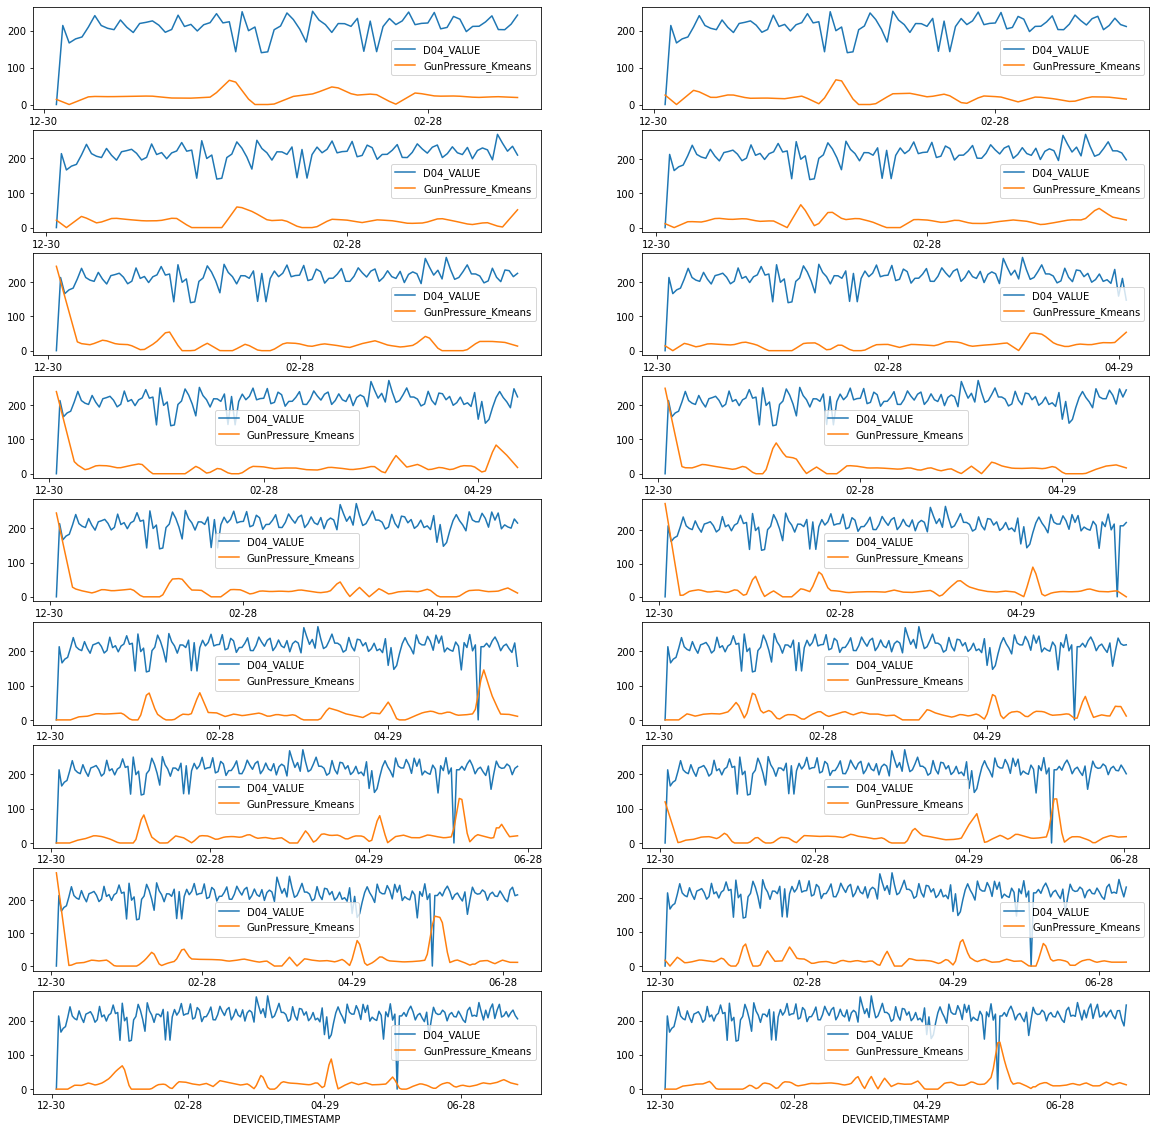

In [9]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs:
    df_part[['D04_VALUE','GunPressure_Kmeans']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0


### KMeans anomaly score with fixed cluster size

In [10]:
# setting up the slightly modified anomaly scorer
import logging
logger = logging.getLogger(__name__)
from iotfunctions.anomaly import view_as_windows
from pyod.models.cblof import CBLOF
from iotfunctions.anomaly import AnomalyScorer

KMeans_normalizer = 1

class KMeansAnomalyScoreFixClusterSize(anomaly.AnomalyScorer):
    
    
    def __init__(self, input_item, windowsize, output_item, expr=None):
        
        super().__init__(input_item, windowsize, [output_item])

        logger.debug(input_item)

        self.whoami = 'KMeansFixClusterSize'


    def score(self, temperature):     

        scores = []     
        for output_item in self.output_items:     
            scores.append(np.zeros(temperature.shape))     

        try:     
            # Chop into overlapping windows     
            slices = view_as_windows(temperature, self.windowsize, self.step)     

            if self.windowsize > 1:     
                n_cluster = 40     
            else:     
                n_cluster = 20     

            n_cluster = 15     

            n_cluster = np.minimum(n_cluster, slices.shape[0] // 2)

            logger.debug(self.whoami + 'params, Clusters: ' + str(n_cluster) + ', Slices: ' + str(slices.shape))

            cblofwin = CBLOF(n_clusters=n_cluster, n_jobs=-1)
            try:
                cblofwin.fit(slices)
            except Exception as e:
                logger.info('KMeans failed with ' + str(e))
                self.trace_append('KMeans failed with' + str(e))
                return scores

            pred_score = cblofwin.decision_scores_.copy() * KMeans_normalizer

            scores[0] = pred_score

            logger.debug('KMeans score max: ' + str(pred_score.max()))
            
            print("score length ", scores[0].shape, " Temp ", temperature.shape)

        except Exception as e:
            logger.error(self.whoami + ' failed with ' + str(e))

        return scores

In [11]:
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test2 = KMeansAnomalyScoreFixClusterSize('D04_VALUE', 5, 'GunPressure_Kmeans_Fixed')
et2 = test2._build_entity_type(columns = [Column('D04_VALUE',Float())], **jobsettings)
test2._entity_type = et2
test2.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2022-10-24T19:23:25.303 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:25.303 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-24T19:23:25.304 DEBUG __main__.__init__ D04_VALUE
2022-10-24T19:23:25.304 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:25.304 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:25.305 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172325
2022-10-24T19:23:25.305 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:25.305 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:25.306 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:25.307 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREF

In [12]:
EngineLogging.configure_console_logging(logging.DEBUG)

dfs[0] = test2.execute(df=dfs[0])
EngineLogging.configure_console_logging(logging.INFO)


2022-10-24T19:23:25.311 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:25.312 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-24T19:23:25.313 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:25.318 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               '2022-10-18 06:56:00', '2022-10-18 06:57:00',
               '2022-10-18 06:58:00', '2022-10-18 06:59:00',
               '2022-10-18 07:00:00', '2022-10-18 07:01:00',
               '2022-10-18 07:02:00', '2022-10-18 07:03:00',
               '2022-10-18 07:0

In [13]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et2 = test2._build_entity_type(columns = [Column('GunPressure_Kmeans_Fixed',Float())], **jobsettings)
    test2._entity_type = et2
    dfs[i] = test2.execute(df=dfs[i])

2022-10-24T19:23:25.463 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:25.465 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:25.466 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:25.467 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172325
2022-10-24T19:23:25.467 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:25.468 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:25.468 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:25.469 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:25.469 DEBUG iotfunctions.anomaly.execute Execute

2022-10-24T19:23:25.691 DEBUG iotfunctions.anomaly._calc 825
2022-10-24T19:23:25.692 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 13, Slices: (26, 5)
2022-10-24T19:23:25.809 DEBUG __main__.score KMeans score max: 72.43059807757352
score length  (26,)  Temp  (82,)
2022-10-24T19:23:25.810 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:25.818 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:25.822 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:25.823 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:25.823 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:25.823 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172325
2022-10-24T19:23:25.824 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:25.824 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:25.824 INFO iotfuncti

2022-10-24T19:23:25.998 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:25.998 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:25.998 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:25.998 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-24T19:23:25.999 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:26.004 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00'

2022-10-24T19:23:26.284 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:26.292 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               ...
               '2022-10-18 09:10:00', '2022-10-18 09:11:00',
               '2022-10-18 09:12:00', '2022-10-18 09:13:00',
               '2022-10-18 09:14:00', '2022-10-18 09:15:00',
               '2022-10-18 09:16:00', '2022-10-18 09:17:00',
               '2022-10-18 09:18:00', '2022-10-18 09:19:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=138, freq=None)
2022-10-24T19:23:26.293 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: 

2022-10-24T19:23:26.632 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: prepare Data
2022-10-24T19:23:26.639 DEBUG iotfunctions.anomaly._calc KMeansFixClusterSize, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_Kmeans_Fixed'], Overlap: 2, Inputsize: 165
2022-10-24T19:23:26.640 DEBUG iotfunctions.anomaly._calc 1655
2022-10-24T19:23:26.642 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 15, Slices: (54, 5)
2022-10-24T19:23:26.777 DEBUG __main__.score KMeans score max: 151.7861821304891
score length  (54,)  Temp  (165,)
2022-10-24T19:23:26.778 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:26.790 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:26.801 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:26.802 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:26.802 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:26.802 DEBUG iotfunctions.ut

score length  (59,)  Temp  (180,)
2022-10-24T19:23:27.151 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:27.159 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:27.165 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:27.168 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:27.169 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:27.170 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172327
2022-10-24T19:23:27.170 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:27.171 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:27.171 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:27.172 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Gr

2022-10-24T19:23:27.388 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:27.388 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:27.389 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:27.389 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:27.390 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-24T19:23:27.391 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:27.396 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-1

In [14]:
dfs[0].columns

Index(['DEVICETYPE', 'SHIFTNAME', 'SHIFTID', 'EQKEY', 'EQID', 'EQNAME',
       'TOOLNAME', 'AVI_PRG_NUM', 'AVI_PRG_TEXT', 'ACT_PRG_NUM',
       'ACT_PRG_TEXT', 'FAULT_CODE', 'FAULT_CODE_TEXT', 'JOB_STATUS',
       'JOB_STATUS_TEXT', 'DATACOUNT', 'D01_TOOLDATANAME', 'D01_VALUE',
       'D01_UOM', 'D01_DATA_STATUS', 'D01_DATA_STATUS_TEXT',
       'D02_TOOLDATANAME', 'D02_VALUE', 'D02_UOM', 'D02_DATA_STATUS',
       'D02_DATA_STATUS_TEXT', 'D03_TOOLDATANAME', 'D03_VALUE', 'D03_UOM',
       'D03_DATA_STATUS', 'D03_DATA_STATUS_TEXT', 'D04_TOOLDATANAME',
       'D04_VALUE', 'D04_UOM', 'D04_DATA_STATUS', 'D04_DATA_STATUS_TEXT',
       'SHOPKEY', 'LINEKEY', 'LINEID', 'LINENAME', 'SHORTNAME', 'ASSEMBLY_NUM',
       'VIN_NUM', 'ICSRESPONSECODE', 'ICSRESPONSETEXT', 'IICSPROCESSTIME',
       'CYCLE_TIME', 'CYCLE_COUNTER', 'BODYNUM', 'CARRIERNUM', 'BADGENUM',
       'GunPressure_Kmeans', 'GunPressure_Kmeans_Fixed'],
      dtype='object')

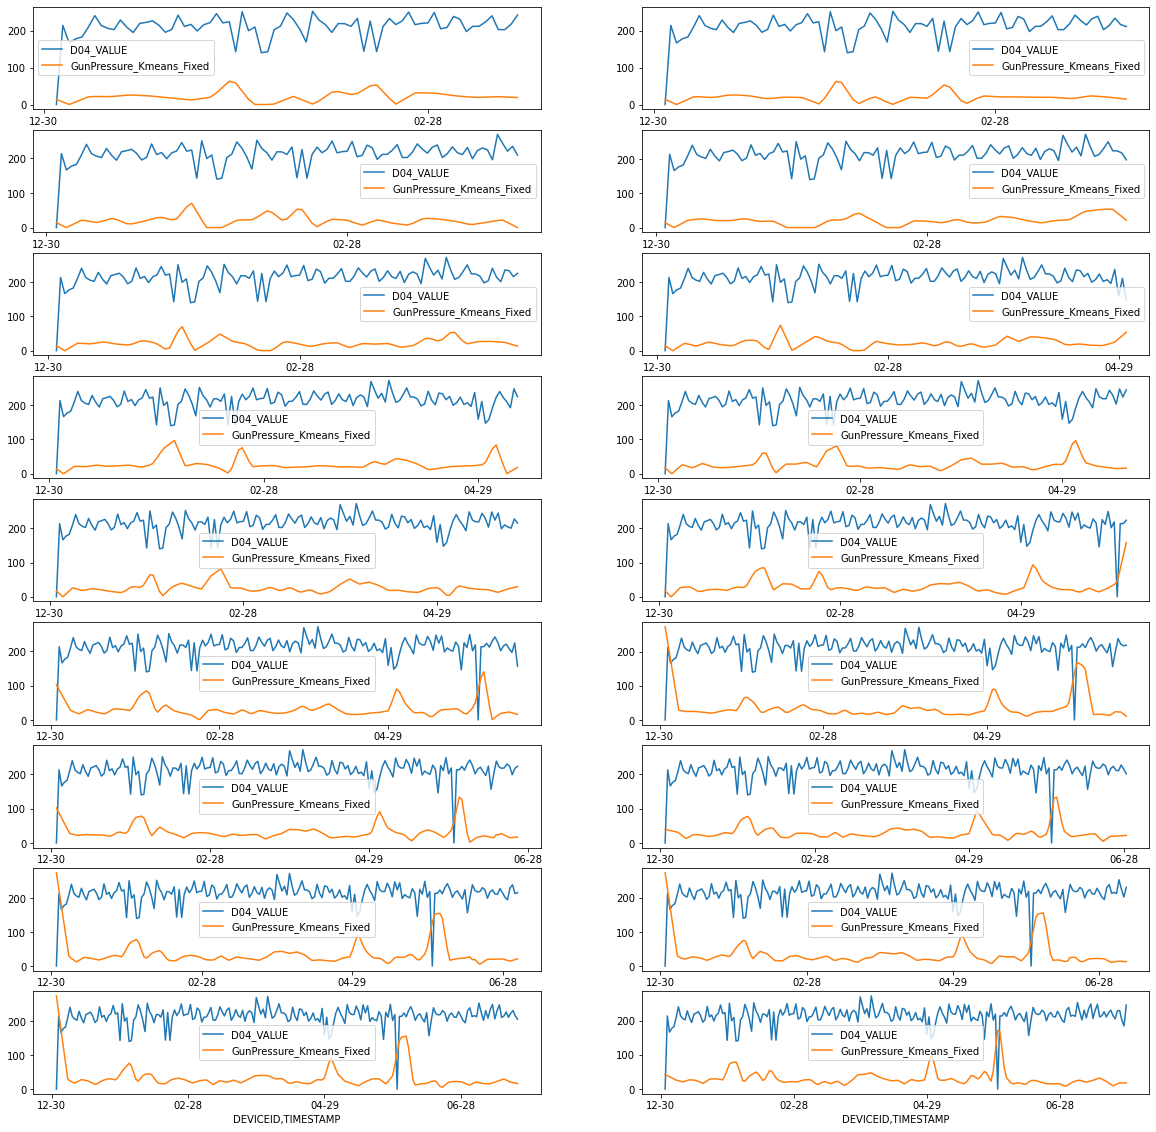

In [15]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs:
    df_part[['D04_VALUE','GunPressure_Kmeans_Fixed']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0

### Try MatrixProfile as alternative anomaly scorer

In [16]:
from iotfunctions.anomaly import MatrixProfileAnomalyScore
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test3 = KMeansAnomalyScoreFixClusterSize('D04_VALUE', 5, 'GunPressure_MatrixProfile')
et3 = test3._build_entity_type(columns = [Column('D04_VALUE',Float())], **jobsettings)
test3._entity_type = et3
test3.auto_train = True

EngineLogging.configure_console_logging(logging.INFO)

2022-10-24T19:23:29.153 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:29.154 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-24T19:23:29.154 DEBUG __main__.__init__ D04_VALUE
2022-10-24T19:23:29.155 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:29.155 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:29.156 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172329
2022-10-24T19:23:29.156 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:29.157 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:29.157 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:29.157 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREF

In [17]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et3 = test3._build_entity_type(columns = [Column('GunPressure_Kmeans_MatrixProfile',Float())], **jobsettings)
    test3._entity_type = et3
    dfs[i] = test3.execute(df=dfs[i])

2022-10-24T19:23:29.162 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:29.163 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:29.163 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:29.164 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172329
2022-10-24T19:23:29.164 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:29.164 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:29.165 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:29.165 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:29.166 DEBUG iotfunctions.anomaly.execute Execute

2022-10-24T19:23:29.265 DEBUG iotfunctions.anomaly._calc 825
2022-10-24T19:23:29.266 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 13, Slices: (26, 5)
2022-10-24T19:23:29.330 DEBUG __main__.score KMeans score max: 71.24976502105498
score length  (26,)  Temp  (82,)
2022-10-24T19:23:29.331 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:29.339 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:29.348 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:29.350 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:29.351 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:29.351 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172329
2022-10-24T19:23:29.352 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:29.352 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:29.353 INFO iotfuncti

2022-10-24T19:23:29.553 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:29.553 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:29.553 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:29.554 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-24T19:23:29.555 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:29.564 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00'

2022-10-24T19:23:29.970 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:29.989 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               ...
               '2022-10-18 09:10:00', '2022-10-18 09:11:00',
               '2022-10-18 09:12:00', '2022-10-18 09:13:00',
               '2022-10-18 09:14:00', '2022-10-18 09:15:00',
               '2022-10-18 09:16:00', '2022-10-18 09:17:00',
               '2022-10-18 09:18:00', '2022-10-18 09:19:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=138, freq=None)
2022-10-24T19:23:29.991 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: 

2022-10-24T19:23:30.342 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: prepare Data
2022-10-24T19:23:30.347 DEBUG iotfunctions.anomaly._calc KMeansFixClusterSize, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_MatrixProfile'], Overlap: 2, Inputsize: 165
2022-10-24T19:23:30.348 DEBUG iotfunctions.anomaly._calc 1655
2022-10-24T19:23:30.349 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 15, Slices: (54, 5)
2022-10-24T19:23:30.402 DEBUG __main__.score KMeans score max: 151.7861821304891
score length  (54,)  Temp  (165,)
2022-10-24T19:23:30.403 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:30.416 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:30.428 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:30.430 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:30.430 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:30.431 DEBUG iotfunctions.u

2022-10-24T19:23:30.648 DEBUG __main__.score KMeans score max: 151.7861821304891
score length  (59,)  Temp  (180,)
2022-10-24T19:23:30.649 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:30.659 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:30.665 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:30.666 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:30.667 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:30.668 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172330
2022-10-24T19:23:30.668 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:30.668 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:30.669 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:30.670 DEBUG iotfunctions.metadata.__init__ Initialized entity typ

2022-10-24T19:23:30.994 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221024172330
2022-10-24T19:23:30.994 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:30.995 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:30.995 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:30.995 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:30.996 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-24T19:23:30.996 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-24T19:23:31.004 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18

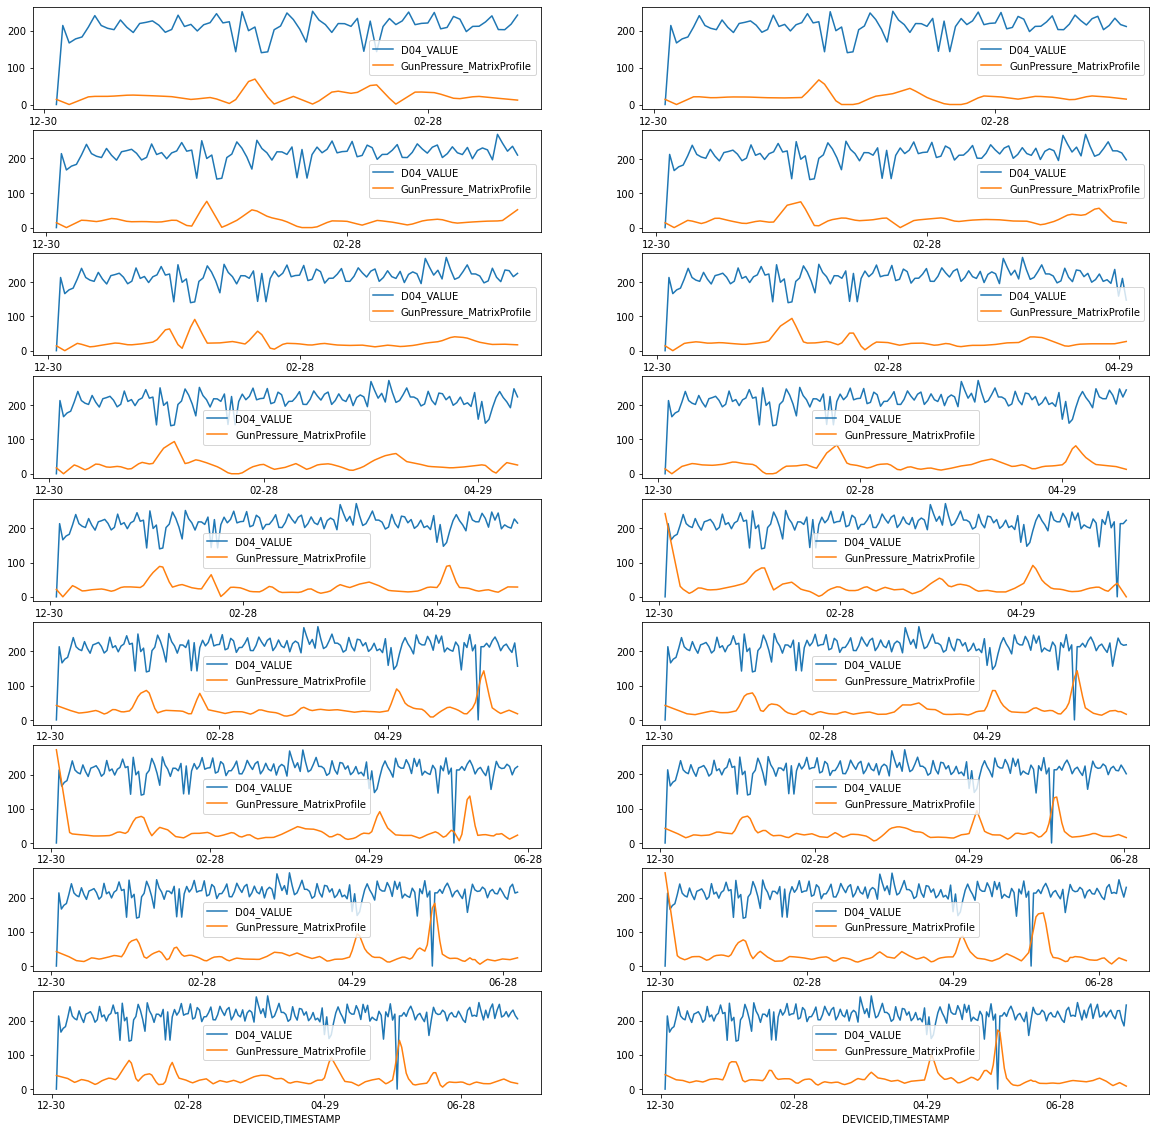

In [18]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs:
    df_part[['D04_VALUE','GunPressure_MatrixProfile']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0

<AxesSubplot:xlabel='DEVICEID,TIMESTAMP'>

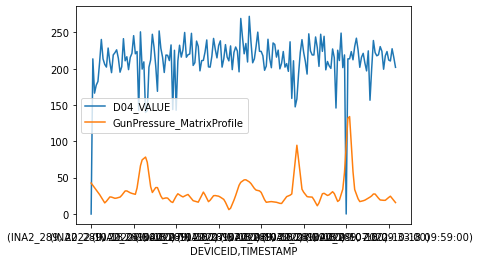

In [19]:
dfs[13][['D04_VALUE','GunPressure_MatrixProfile']].plot()

### Do true sliding window of roughly equal size make a difference ?

when passed to the regular KMeans anomaly scorer

In [20]:
reg_startpoints = np.arange(0, 120, 7)
reg_startpoints
dfs_reg = []
for s in reg_startpoints:
    dfs_reg.append(df_i[s:s+150].copy())

In [21]:
dfs_reg[0]

DEVICETYPE SHIFTNAME  SHIFTID  EQKEY  EQID  \
DEVICEID TIMESTAMP                                                        
INA2_289 2022-10-18 06:36:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:37:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:39:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:40:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:49:00  DT_000001   Shift 1        1    251  1011   
...                                 ...       ...      ...    ...   ...   
         2022-10-18 09:28:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:29:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:30:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:31:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:32:00  DT_000001   Shift 1        1    251  1011   

                                        EQNAME       TOOLNAME  AVI_PRG_NUM  \
DEVICEID TIMESTAMP                                                           
INA2_289 2022-10-18 06:36:00  LLC and WWF Fill  T01- LLC Fill            3   
         2022-10-18 06:37:00  LLC and WWF Fill  T01- LLC Fill            5   
         2022-10-18 06:39:00  LLC and WWF Fill  T01- LLC Fill            7   
         2022-10-18 06:40:00  LLC and WWF Fill  T01- LLC Fill            1   
         2022-10-18 06:49:00  LLC and WWF Fill  T01- LLC Fill            7   
...                                        ...            ...          ...   
         2022-10-18 09:28:00  LLC and WWF Fill  T01- LLC Fill            7   
         2022-10-18 09:29:00  LLC and WWF Fill  T01- LLC Fill            1   
         2022-10-18 09:30:00  LLC and WWF Fill  T01- LLC Fill            5   
         2022-10-18 09:31:00  LLC and WWF Fill  T01- LLC Fill            2   
         2022-10-18 09:32:00  LLC and WWF Fill  T01- LLC Fill            7   

                                               AVI_PRG_TEXT  ACT_PRG_NUM  ...  \
DEVICEID TIMESTAMP                                                        ...   
INA2_289 2022-10-18 06:36:00       3 - Sienna No Tow or HTR            3  ...   
         2022-10-18 06:37:00           5 - Highlander HV US            5  ...   
         2022-10-18 06:39:00          7 - Highlander Gas US            7  ...   
         2022-10-18 06:40:00          1 - Sienna US Tow&HTR            1  ...   
         2022-10-18 06:49:00          7 - Highlander Gas US            7  ...   
...                                                     ...          ...  ...   
         2022-10-18 09:28:00          7 - Highlander Gas US            7  ...   
         2022-10-18 09:29:00          1 - Sienna US Tow&HTR            1  ...   
         2022-10-18 09:30:00           5 - Highlander HV US            5  ...   
         2022-10-18 09:31:00  2 - Sienna CAN Tow&HTR no WWF            2  ...   
         2022-10-18 09:32:00          7 - Highlander Gas US            7  ...   

                             ASSEMBLY_NUM            VIN_NUM ICSRESPONSECODE  \
DEVICEID TIMESTAMP                                                             
INA2_289 2022-10-18 06:36:00         1651  5TDGRKEC6NS117153             NaN   
         2022-10-18 06:37:00         1652  5TDGARAH5NS515259             NaN   
         2022-10-18 06:39:00         1653  5TDBZRBH6NS578727             NaN   
         2022-10-18 06:40:00         1654  5TDESKFC9NS062319             NaN   
         2022-10-18 06:49:00         1655  5TDHZRAH9NS551064             NaN   
...                                   ...                ...             ...   
         2022-10-18 09:28:00         1796  5TDHZRBH7NS578844             NaN   
         2022-10-18 09:29:00         1797  5TDYSKFC4NS062340             NaN   
         2022-10-18 09:30:00         1798  5TDGARAH2NS515266             NaN   
         2022-10-18 09:31:00         1799  5TDGSKFC9NS062328             NaN   
         2022-10-18 09:3

In [22]:
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test3 = MatrixProfileAnomalyScore('D04_VALUE', 5, 'GunPressure_MP_Equal')
et3 = test3._build_entity_type(columns = [Column('GunPressure_MP_Equal',Float())], **jobsettings)
test3._entity_type = et3
test3.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2022-10-24T19:23:33.234 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:33.235 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-24T19:23:33.235 DEBUG iotfunctions.anomaly.__init__ Input item: D04_VALUE
2022-10-24T19:23:33.236 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:33.236 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:33.236 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221024172333
2022-10-24T19:23:33.236 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:33.237 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:33.237 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:33.237 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MA

In [23]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et3 = test3._build_entity_type(columns = [Column('GunPressure_MP_Equal',Float())], **jobsettings)
    test3._entity_type = et3
    dfs_reg[i] = test3.execute(df=dfs_reg[i])

2022-10-24T19:23:33.243 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-24T19:23:33.244 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:33.244 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:33.244 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221024172333
2022-10-24T19:23:33.245 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:33.245 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:33.246 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:33.246 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:33.246 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile

2022-10-24T19:23:33.261 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:33.262 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:33.262 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=197)
2022-10-24T19:23:33.262 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:33.263 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=197)
2022-10-24T19:23:33.264 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:33.264 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=197)
2022-10-24T19:23:33.265 DEBUG numba.core.byteflow.dispatch stack ['$T_A2.0']
2022-10-24T19:23:33.266 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=1, lineno=197)
2022-10-24T19:23:33.267 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2022-10-24T19:23:33.268 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=BINARY_SUBSCR(arg=None

2022-10-24T19:23:33.332 DEBUG numba.core.byteflow.dispatch stack ['$70load_attr.29', '$n_threads72.30', '$l74.31', '$const76.32']
2022-10-24T19:23:33.333 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=LOAD_CONST(arg=5, lineno=202)
2022-10-24T19:23:33.333 DEBUG numba.core.byteflow.dispatch stack ['$70load_attr.29', '$78build_tuple.33']
2022-10-24T19:23:33.334 DEBUG numba.core.byteflow.dispatch dispatch pc=82, inst=LOAD_GLOBAL(arg=4, lineno=202)
2022-10-24T19:23:33.334 DEBUG numba.core.byteflow.dispatch stack ['$70load_attr.29', '$78build_tuple.33', '$const80.34']
2022-10-24T19:23:33.334 DEBUG numba.core.byteflow.dispatch dispatch pc=84, inst=LOAD_ATTR(arg=8, lineno=202)
2022-10-24T19:23:33.334 DEBUG numba.core.byteflow.dispatch stack ['$70load_attr.29', '$78build_tuple.33', '$const80.34', '$82load_global.35']
2022-10-24T19:23:33.335 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_CONST(arg=4, lineno=202)
2022-10-24T19:23:33.335 DEBUG numba.core.byteflow.dispatch st

2022-10-24T19:23:33.387 DEBUG numba.core.byteflow.dispatch stack ['$phi132.0']
2022-10-24T19:23:33.388 DEBUG numba.core.byteflow.dispatch dispatch pc=136, inst=LOAD_FAST(arg=0, lineno=210)
2022-10-24T19:23:33.388 DEBUG numba.core.byteflow.dispatch stack ['$phi132.0', '$134load_global.2']
2022-10-24T19:23:33.388 DEBUG numba.core.byteflow.dispatch dispatch pc=138, inst=LOAD_FAST(arg=1, lineno=211)
2022-10-24T19:23:33.389 DEBUG numba.core.byteflow.dispatch stack ['$phi132.0', '$134load_global.2', '$T_A136.3']
2022-10-24T19:23:33.389 DEBUG numba.core.byteflow.dispatch dispatch pc=140, inst=LOAD_FAST(arg=2, lineno=212)
2022-10-24T19:23:33.389 DEBUG numba.core.byteflow.dispatch stack ['$phi132.0', '$134load_global.2', '$T_A136.3', '$T_B138.4']
2022-10-24T19:23:33.390 DEBUG numba.core.byteflow.dispatch dispatch pc=142, inst=LOAD_FAST(arg=3, lineno=213)
2022-10-24T19:23:33.390 DEBUG numba.core.byteflow.dispatch stack ['$phi132.0', '$134load_global.2', '$T_A136.3', '$T_B138.4', '$m140.5']
2022-

2022-10-24T19:23:33.418 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=194 nstack_initial=1), State(pc_initial=130 nstack_initial=1)])
2022-10-24T19:23:33.418 DEBUG numba.core.byteflow.run stack: ['$phi194.0']
2022-10-24T19:23:33.419 DEBUG numba.core.byteflow.dispatch dispatch pc=194, inst=FOR_ITER(arg=123, lineno=226)
2022-10-24T19:23:33.419 DEBUG numba.core.byteflow.dispatch stack ['$phi194.0']
2022-10-24T19:23:33.420 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=442, stack=(), blockstack=(), npush=0), Edge(pc=196, stack=('$phi194.0', '$194for_iter.2'), blockstack=(), npush=0)]
2022-10-24T19:23:33.420 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=130 nstack_initial=1), State(pc_initial=442 nstack_initial=0), State(pc_initial=196 nstack_initial=2)])
2022-10-24T19:23:33.420 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=442 nstack_initial=0), State(pc_initial=196 nstack_initial=2)])
2022-10-24T19:23:33.421 DEBUG numba.core.byte

2022-10-24T19:23:33.446 DEBUG numba.core.byteflow.dispatch stack ['$phi196.0']
2022-10-24T19:23:33.446 DEBUG numba.core.byteflow.dispatch dispatch pc=200, inst=LOAD_FAST(arg=10, lineno=227)
2022-10-24T19:23:33.449 DEBUG numba.core.byteflow.dispatch stack ['$phi196.0', '$198load_global.2']
2022-10-24T19:23:33.449 DEBUG numba.core.byteflow.dispatch dispatch pc=202, inst=CALL_FUNCTION(arg=1, lineno=227)
2022-10-24T19:23:33.450 DEBUG numba.core.byteflow.dispatch stack ['$phi196.0', '$198load_global.2', '$l200.3']
2022-10-24T19:23:33.450 DEBUG numba.core.byteflow.dispatch dispatch pc=204, inst=GET_ITER(arg=None, lineno=227)
2022-10-24T19:23:33.450 DEBUG numba.core.byteflow.dispatch stack ['$phi196.0', '$202call_function.4']
2022-10-24T19:23:33.450 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=206, stack=('$phi196.0', '$204get_iter.5'), blockstack=(), npush=0)]
2022-10-24T19:23:33.451 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=206 nstack_initial=2)])
2022-10-24T

2022-10-24T19:23:33.481 DEBUG numba.core.byteflow.dispatch dispatch pc=252, inst=LOAD_CONST(arg=1, lineno=229)
2022-10-24T19:23:33.482 DEBUG numba.core.byteflow.dispatch stack ['$phi238.0', '$phi238.1', '$248binary_subscr.7', '$P250.8']
2022-10-24T19:23:33.482 DEBUG numba.core.byteflow.dispatch dispatch pc=254, inst=LOAD_FAST(arg=17, lineno=229)
2022-10-24T19:23:33.482 DEBUG numba.core.byteflow.dispatch stack ['$phi238.0', '$phi238.1', '$248binary_subscr.7', '$P250.8', '$const252.9']
2022-10-24T19:23:33.483 DEBUG numba.core.byteflow.dispatch dispatch pc=256, inst=LOAD_CONST(arg=1, lineno=229)
2022-10-24T19:23:33.483 DEBUG numba.core.byteflow.dispatch stack ['$phi238.0', '$phi238.1', '$248binary_subscr.7', '$P250.8', '$const252.9', '$i254.10']
2022-10-24T19:23:33.483 DEBUG numba.core.byteflow.dispatch dispatch pc=258, inst=BUILD_TUPLE(arg=3, lineno=229)
2022-10-24T19:23:33.486 DEBUG numba.core.byteflow.dispatch stack ['$phi238.0', '$phi238.1', '$248binary_subscr.7', '$P250.8', '$const25

2022-10-24T19:23:33.514 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=286 nstack_initial=2), State(pc_initial=314 nstack_initial=2), State(pc_initial=362 nstack_initial=2)])
2022-10-24T19:23:33.514 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=314 nstack_initial=2), State(pc_initial=362 nstack_initial=2)])
2022-10-24T19:23:33.515 DEBUG numba.core.byteflow.run stack: ['$phi314.0', '$phi314.1']
2022-10-24T19:23:33.515 DEBUG numba.core.byteflow.dispatch dispatch pc=314, inst=LOAD_FAST(arg=12, lineno=233)
2022-10-24T19:23:33.516 DEBUG numba.core.byteflow.dispatch stack ['$phi314.0', '$phi314.1']
2022-10-24T19:23:33.517 DEBUG numba.core.byteflow.dispatch dispatch pc=316, inst=LOAD_FAST(arg=16, lineno=233)
2022-10-24T19:23:33.517 DEBUG numba.core.byteflow.dispatch stack ['$phi314.0', '$phi314.1', '$P314.2']
2022-10-24T19:23:33.517 DEBUG numba.core.byteflow.dispatch dispatch pc=318, inst=LOAD_FAST(arg=17, lineno=233)
2022-10-24T19:23:33.518 DEBUG numba.core.b

2022-10-24T19:23:33.541 DEBUG numba.core.byteflow.dispatch dispatch pc=376, inst=LOAD_FAST(arg=16, lineno=236)
2022-10-24T19:23:33.541 DEBUG numba.core.byteflow.dispatch stack ['$phi362.0', '$phi362.1', '$372binary_subscr.7', '$P374.8']
2022-10-24T19:23:33.541 DEBUG numba.core.byteflow.dispatch dispatch pc=378, inst=LOAD_FAST(arg=17, lineno=236)
2022-10-24T19:23:33.541 DEBUG numba.core.byteflow.dispatch stack ['$phi362.0', '$phi362.1', '$372binary_subscr.7', '$P374.8', '$thread_idx376.9']
2022-10-24T19:23:33.542 DEBUG numba.core.byteflow.dispatch dispatch pc=380, inst=LOAD_CONST(arg=7, lineno=236)
2022-10-24T19:23:33.542 DEBUG numba.core.byteflow.dispatch stack ['$phi362.0', '$phi362.1', '$372binary_subscr.7', '$P374.8', '$thread_idx376.9', '$i378.10']
2022-10-24T19:23:33.542 DEBUG numba.core.byteflow.dispatch dispatch pc=382, inst=BUILD_TUPLE(arg=3, lineno=236)
2022-10-24T19:23:33.542 DEBUG numba.core.byteflow.dispatch stack ['$phi362.0', '$phi362.1', '$372binary_subscr.7', '$P374.8',

2022-10-24T19:23:33.568 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=438, stack=('$phi390.0', '$phi390.1'), blockstack=(), npush=0)]
2022-10-24T19:23:33.568 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=438 nstack_initial=2), State(pc_initial=438 nstack_initial=2)])
2022-10-24T19:23:33.569 DEBUG numba.core.byteflow.run stack: ['$phi438.0', '$phi438.1']
2022-10-24T19:23:33.569 DEBUG numba.core.byteflow.dispatch dispatch pc=438, inst=JUMP_ABSOLUTE(arg=104, lineno=238)
2022-10-24T19:23:33.569 DEBUG numba.core.byteflow.dispatch stack ['$phi438.0', '$phi438.1']
2022-10-24T19:23:33.569 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=206, stack=('$phi438.0', '$phi438.1'), blockstack=(), npush=0)]
2022-10-24T19:23:33.570 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=438 nstack_initial=2), State(pc_initial=206 nstack_initial=2)])
2022-10-24T19:23:33.570 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=206 nstack_initial=2)])
202

2022-10-24T19:23:33.575 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$128get_iter.55',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi132.0': {('$128get_iter.55',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi132.1': {('$130for_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi194.0': {('$192get_iter.4',
                            State(pc_initial=184 nstack_initial=0)),
                           ('$phi362.0',
                            State(pc_initial=362 nstack_initial=2)),
                           ('$phi390.0',
                            State(pc_initial=390 nstack_initial=2))},
             '$phi196.0': {('$192get_iter.4',
                            State(pc_initial=184 nstack_initial=0)),
                           ('$phi362.0',
                            State(pc_initial=362 

2022-10-24T19:23:33.577 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi130.0': {('$128get_iter.55', State(pc_initial=0 nstack_initial=0))},
 '$phi132.1': {('$130for_iter.2', State(pc_initial=130 nstack_initial=1))},
 '$phi194.0': {('$192get_iter.4', State(pc_initial=184 nstack_initial=0))},
 '$phi196.1': {('$194for_iter.2', State(pc_initial=194 nstack_initial=1))},
 '$phi206.1': {('$204get_iter.5', State(pc_initial=196 nstack_initial=2))},
 '$phi208.2': {('$206for_iter.3', State(pc_initial=206 nstack_initial=2))}}
2022-10-24T19:23:33.578 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi130.0': '$128get_iter.55'},
             State(pc_initial=130 nstack_initial=1): {'$phi132.1': '$130for_iter.2'},
             State(pc_initial=184 nstack_initial=0): {'$phi194.0': '$192get_iter.4'},
             State(pc_initial=194 nstack_initial=1): {'$phi196.1': '$194for_iter.2'},
             State(pc_i

2022-10-24T19:23:33.584 DEBUG numba.core.byteflow.run block_infos State(pc_initial=206 nstack_initial=2):
AdaptBlockInfo(insts=((206, {'iterator': '$phi206.1', 'pair': '$206for_iter.2', 'indval': '$206for_iter.3', 'pred': '$206for_iter.4'}),), outgoing_phis={'$phi208.2': '$206for_iter.3'}, blockstack=(), active_try_block=None, outgoing_edgepushed={440: ('$phi206.0',), 208: ('$phi206.0', '$phi206.1', '$206for_iter.3')})
2022-10-24T19:23:33.586 DEBUG numba.core.byteflow.run block_infos State(pc_initial=208 nstack_initial=3):
AdaptBlockInfo(insts=((208, {'value': '$phi208.2'}), (210, {'res': '$P210.3'}), (212, {'res': '$const212.4'}), (214, {'res': '$i214.5'}), (216, {'res': '$const216.6'}), (218, {'items': ['$const212.4', '$i214.5', '$const216.6'], 'res': '$218build_tuple.7'}), (220, {'index': '$218build_tuple.7', 'target': '$P210.3', 'res': '$220binary_subscr.8'}), (222, {'res': '$P222.9'}), (224, {'res': '$thread_idx224.10'}), (226, {'res': '$i226.11'}), (228, {'res': '$const228.12'}),

2022-10-24T19:23:33.590 DEBUG numba.core.byteflow.run block_infos State(pc_initial=442 nstack_initial=0):
AdaptBlockInfo(insts=((442, {'res': '$442load_global.0'}), (444, {'item': '$442load_global.0', 'res': '$444load_method.1'}), (446, {'res': '$P446.2'}), (448, {'res': '$const448.3'}), (450, {'res': '$const450.4'}), (452, {'res': '$const452.5'}), (454, {'start': '$const450.4', 'stop': '$const452.5', 'step': None, 'res': '$454build_slice.7', 'slicevar': '$454build_slice.6'}), (456, {'res': '$const456.8'}), (458, {'res': '$const458.9'}), (460, {'start': '$const456.8', 'stop': '$const458.9', 'step': None, 'res': '$460build_slice.11', 'slicevar': '$460build_slice.10'}), (462, {'items': ['$const448.3', '$454build_slice.7', '$460build_slice.11'], 'res': '$462build_tuple.12'}), (464, {'index': '$462build_tuple.12', 'target': '$P446.2', 'res': '$464binary_subscr.13'}), (466, {'res': '$const466.14'}), (468, {'res': '$p468.15'}), (470, {'lhs': '$const466.14', 'rhs': '$p468.15', 'res': '$470bin

2022-10-24T19:23:33.642 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:33.644 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a20303280>
2022-10-24T19:23:33.644 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:33.644 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:33.645 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:33.645 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A_subseq_isfinite = arg(3, name=T_A_subseq_isfinite)
2022-10-24T19:23:33.646 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B_subseq_isfinite = arg(4, name=T_B_subseq_isfinite)
2022-10-24T19:23:33.646 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p = arg(5, name=p)
2022-10-24T19:23:33.647 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: diags = arg(6, name=diags)
2022-10-24T19:23:33.647 DEBU

2022-10-24T19:23:33.670 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.2 = pair_first(value=$130for_iter.1)
2022-10-24T19:23:33.670 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.3 = pair_second(value=$130for_iter.1)
2022-10-24T19:23:33.671 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi132.1 = $130for_iter.2
2022-10-24T19:23:33.671 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $130for_iter.3, 132, 184
2022-10-24T19:23:33.671 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 132
2022-10-24T19:23:33.672 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a20303280>
2022-10-24T19:23:33.672 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: thread_idx = $phi132.1
2022-10-24T19:23:33.672 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134load_global.2 = global(_compute_diagonal: CPUDispatcher(<function _compute_diagonal at 0x7f2a9d15fa30>))
2022-10-24T19:23:33.673 DEBUG

2022-10-24T19:23:33.699 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $236pred, 238, 286
2022-10-24T19:23:33.699 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 238
2022-10-24T19:23:33.699 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a20303280>
2022-10-24T19:23:33.700 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const244.5 = const(int, 0)
2022-10-24T19:23:33.700 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $246build_tuple.6 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const244.5, aamp.py:229)])
2022-10-24T19:23:33.701 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $248binary_subscr.7 = getitem(value=P, index=$246build_tuple.6, fn=<built-in function getitem>)
2022-10-24T19:23:33.701 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const252.9 = const(int, 0)
2022-10-24T19:23:33.702 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const256.11 = const(

2022-10-24T19:23:33.726 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $388pred, 390, 438
2022-10-24T19:23:33.726 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 390
2022-10-24T19:23:33.726 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a20303280>
2022-10-24T19:23:33.727 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const396.5 = const(int, 2)
2022-10-24T19:23:33.727 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $398build_tuple.6 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const396.5, aamp.py:237)])
2022-10-24T19:23:33.727 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $400binary_subscr.7 = getitem(value=P, index=$398build_tuple.6, fn=<built-in function getitem>)
2022-10-24T19:23:33.728 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const404.9 = const(int, 0)
2022-10-24T19:23:33.728 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const408.11 = const(

2022-10-24T19:23:33.755 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$108load_global.46': [<numba.core.ir.Assign object at 0x7f2a2022f040>],
             '$110load_method.47': [<numba.core.ir.Assign object at 0x7f2a2022f1c0>],
             '$122load_global.52': [<numba.core.ir.Assign object at 0x7f2a2022f9a0>],
             '$126call_function.54': [<numba.core.ir.Assign object at 0x7f2a2022fca0>],
             '$128get_iter.55': [<numba.core.ir.Assign object at 0x7f2a2022fdc0>],
             '$130for_iter.1': [<numba.core.ir.Assign object at 0x7f2a2022c4c0>],
             '$130for_iter.2': [<numba.core.ir.Assign object at 0x7f2a2022d780>],
             '$130for_iter.3': [<numba.core.ir.Assign object at 0x7f2a2022e8c0>],
             '$134load_global.2': [<numba.core.ir.Assign object at 0x7f2a2022ff40>],
             '$14load_attr.5': [<numba.core.ir.Assign object at 0x7f2a20212ec0>],
             '$156build_tuple.13': [<numba.core.ir.Assign o

2022-10-24T19:23:33.756 DEBUG numba.core.ssa._find_defs_violators SSA violators {'thread_idx'}
2022-10-24T19:23:33.756 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var thread_idx
2022-10-24T19:23:33.756 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:33.757 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a201fce50>
2022-10-24T19:23:33.757 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:33.758 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:33.758 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:33.759 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A_subseq_isfinite = arg(3, name=T_A_subseq_isfinite)
2022-10-24T19:23:33.760 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B_subseq_isfinite = arg(4, name=T_B_subseq_isfinite)
2022-10-24T19:23:33.761 DEBUG numba.core.s

2022-10-24T19:23:33.782 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.1 = iternext(value=$phi130.0)
2022-10-24T19:23:33.782 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.2 = pair_first(value=$130for_iter.1)
2022-10-24T19:23:33.783 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.3 = pair_second(value=$130for_iter.1)
2022-10-24T19:23:33.783 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi132.1 = $130for_iter.2
2022-10-24T19:23:33.783 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $130for_iter.3, 132, 184
2022-10-24T19:23:33.784 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 132
2022-10-24T19:23:33.784 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a201fce50>
2022-10-24T19:23:33.784 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: thread_idx = $phi132.1
2022-10-24T19:23:33.785 DEBUG numba.core.ssa.on_assign first assign: thread_idx
2022-10-24T19:23:33

2022-10-24T19:23:33.810 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool236 = global(bool: <class 'bool'>)
2022-10-24T19:23:33.811 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $236pred = call bool236($234compare_op.15, func=bool236, args=(Var($234compare_op.15, aamp.py:228),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:33.811 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $236pred, 238, 286
2022-10-24T19:23:33.812 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 238
2022-10-24T19:23:33.812 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a201fce50>
2022-10-24T19:23:33.813 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const244.5 = const(int, 0)
2022-10-24T19:23:33.813 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $246build_tuple.6 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const244.5, aamp.py:229)])
2022-10-24T19:23:33.814 DEBUG num

2022-10-24T19:23:33.837 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool388 = global(bool: <class 'bool'>)
2022-10-24T19:23:33.837 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $388pred = call bool388($386compare_op.14, func=bool388, args=(Var($386compare_op.14, aamp.py:236),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:33.838 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $388pred, 390, 438
2022-10-24T19:23:33.838 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 390
2022-10-24T19:23:33.838 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a201fce50>
2022-10-24T19:23:33.838 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const396.5 = const(int, 2)
2022-10-24T19:23:33.839 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $398build_tuple.6 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const396.5, aamp.py:237)])
2022-10-24T19:23:33.839 DEBUG num

2022-10-24T19:23:33.861 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $496return_value.31 = cast(value=$494build_tuple.30)
2022-10-24T19:23:33.862 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $496return_value.31
2022-10-24T19:23:33.862 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
            {132: [<numba.core.ir.Assign object at 0x7f2a201fce20>],
             196: [<numba.core.ir.Assign object at 0x7f2a201fcfd0>]})
2022-10-24T19:23:33.863 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:33.863 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a201fce50>
2022-10-24T19:23:33.864 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:33.864 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:33.864 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:3

2022-10-24T19:23:33.891 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 130
2022-10-24T19:23:33.892 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 130
2022-10-24T19:23:33.892 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a201fce50>
2022-10-24T19:23:33.893 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.1 = iternext(value=$phi130.0)
2022-10-24T19:23:33.894 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.2 = pair_first(value=$130for_iter.1)
2022-10-24T19:23:33.894 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130for_iter.3 = pair_second(value=$130for_iter.1)
2022-10-24T19:23:33.895 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi132.1 = $130for_iter.2
2022-10-24T19:23:33.896 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $130for_iter.3, 132, 184
2022-10-24T19:23:33.897 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 132
2022-10-24T19:23:33

2022-10-24T19:23:33.928 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const216.6 = const(int, 0)
2022-10-24T19:23:33.929 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $218build_tuple.7 = build_tuple(items=[Var($const212.4, aamp.py:228), Var(i, aamp.py:227), Var($const216.6, aamp.py:228)])
2022-10-24T19:23:33.929 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $220binary_subscr.8 = getitem(value=P, index=$218build_tuple.7, fn=<built-in function getitem>)
2022-10-24T19:23:33.930 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const228.12 = const(int, 0)
2022-10-24T19:23:33.930 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $230build_tuple.13 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const228.12, aamp.py:228)])
2022-10-24T19:23:33.930 DEBUG numba.core.ssa._find_def find_def var='thread_idx' stmt=$230build_tuple.13 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const228.12, aamp.py:228)])
2022-10-24T19:23:33.

2022-10-24T19:23:33.966 DEBUG numba.core.ssa._find_def find_def var='thread_idx' stmt=$306build_tuple.12 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const304.11, aamp.py:232)])
2022-10-24T19:23:33.966 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 286
2022-10-24T19:23:33.967 DEBUG numba.core.ssa._find_def_from_top idom 208 from label 286
2022-10-24T19:23:33.967 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 208
2022-10-24T19:23:33.967 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 208
2022-10-24T19:23:33.967 DEBUG numba.core.ssa._find_def_from_top idom 206 from label 208
2022-10-24T19:23:33.968 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 206
2022-10-24T19:23:33.968 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 206
2022-10-24T19:23:33.968 DEBUG numba.core.ssa._find_def_from_top idom 196 from label 206
2022-10-24T19:23:33.969 DEBUG numba.core.ssa._find_def

2022-10-24T19:23:33.988 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $382build_tuple.12 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const380.11, aamp.py:236)])
2022-10-24T19:23:33.989 DEBUG numba.core.ssa._find_def find_def var='thread_idx' stmt=$382build_tuple.12 = build_tuple(items=[Var(thread_idx, aamp.py:207), Var(i, aamp.py:227), Var($const380.11, aamp.py:236)])
2022-10-24T19:23:33.989 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 362
2022-10-24T19:23:33.989 DEBUG numba.core.ssa._find_def_from_top idom 286 from label 362
2022-10-24T19:23:33.990 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 286
2022-10-24T19:23:33.990 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 286
2022-10-24T19:23:33.991 DEBUG numba.core.ssa._find_def_from_top idom 208 from label 286
2022-10-24T19:23:33.991 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 208
2022-10-24T19:23:33.994 DEBUG numba.

2022-10-24T19:23:34.031 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 438
2022-10-24T19:23:34.031 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 438
2022-10-24T19:23:34.031 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a201fce50>
2022-10-24T19:23:34.032 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 206
2022-10-24T19:23:34.033 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 440
2022-10-24T19:23:34.033 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a201fce50>
2022-10-24T19:23:34.034 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 194
2022-10-24T19:23:34.034 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 442
2022-10-24T19:23:34.034 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a201fce50>
2022-10-24T19:23:34.035 DEBUG numba.core.ssa._run_ssa_block_pass on stmt:

2022-10-24T19:23:34.072 DEBUG numba.core.byteflow.find_use_defs defmap: {}
2022-10-24T19:23:34.072 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:34.073 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:34.073 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:34.074 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-24T19:23:34.074 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:34.075 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'res': '$shape4.1'}), (6, {'res': '$fill_value6.2'}), (8, {'res': '$dtype8.3'}), (10, {'func': '$2load_global.0', 'args': ['$shape4.1', '$fill_value6.2', '$dtype8.3'], 'res': '$10call_function.4'}), (12, {'retval': '$10cal

2022-10-24T19:23:34.121 DEBUG numba.core.byteflow.dispatch stack ['$28call_function.11']
2022-10-24T19:23:34.121 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=32, stack=('$30get_iter.12',), blockstack=(), npush=0)]
2022-10-24T19:23:34.122 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=32 nstack_initial=1)])
2022-10-24T19:23:34.122 DEBUG numba.core.byteflow.run stack: ['$phi32.0']
2022-10-24T19:23:34.123 DEBUG numba.core.byteflow.dispatch dispatch pc=32, inst=FOR_ITER(arg=6, lineno=4222)
2022-10-24T19:23:34.123 DEBUG numba.core.byteflow.dispatch stack ['$phi32.0']
2022-10-24T19:23:34.123 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=46, stack=(), blockstack=(), npush=0), Edge(pc=34, stack=('$phi32.0', '$32for_iter.2'), blockstack=(), npush=0)]
2022-10-24T19:23:34.124 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=46 nstack_initial=0), State(pc_initial=34 nstack_initial=2)])
2022-10-24T19:23:34.124 DEBUG numba.core.byteflow.run stack: [

2022-10-24T19:23:34.143 DEBUG numba.core.interpreter.interpret label 0:
    shape = arg(0, name=shape)               ['shape']
    value = arg(1, name=value)               ['value']
    dtype = arg(2, name=dtype)               ['dtype']
    $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>) ['$2load_global.0']
    $4load_method.1 = getattr(value=$2load_global.0, attr=empty) ['$2load_global.0', '$4load_method.1']
    arr = call $4load_method.1(shape, dtype, func=$4load_method.1, args=[Var(shape, arrayobj.py:4220), Var(dtype, arrayobj.py:4220)], kws=(), vararg=None, varkwarg=None, target=None) ['$4load_method.1', 'arr', 'dtype', 'shape']
    arr_flat = getattr(value=arr, attr=flat) ['arr', 'arr_flat']
    $20load_global.7 = global(range: <class 'range'>) ['$20load_global.7']
    $22load_global.8 = global(len: <built-in function len>) ['$22load_global.8']
    $26call_function.10 = call $22load_global.8(arr_flat, func=$2

2022-10-24T19:23:34.181 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:34.182 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:34.182 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=4101)
2022-10-24T19:23:34.182 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:34.183 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=4101)
2022-10-24T19:23:34.183 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:34.183 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=4101)
2022-10-24T19:23:34.183 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:34.184 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=4101)
2022-10-24T19:23:34.184 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$shape4.1']
2022-10-24T19:23:34.184 DEBUG numba.core.byteflow.dispatch dispatch pc=8,

2022-10-24T19:23:34.426 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:34.427 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:34.428 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:34.428 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-24T19:23:34.430 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:34.431 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'res': '$shape4.1'}), (6, {'res': '$fill_value6.2'}), (8, {'res': '$dtype8.3'}), (10, {'func': '$2load_global.0', 'args': ['$shape4.1', '$fill_value6.2', '$dtype8.3'], 'res': '$10call_function.4'}), (12, {'retval': '$10call_function.4', 'castval': '$12return_value.5'})), outgoing_phis={}, blockst

2022-10-24T19:23:34.479 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=32, stack=('$30get_iter.12',), blockstack=(), npush=0)]
2022-10-24T19:23:34.480 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=32 nstack_initial=1)])
2022-10-24T19:23:34.480 DEBUG numba.core.byteflow.run stack: ['$phi32.0']
2022-10-24T19:23:34.480 DEBUG numba.core.byteflow.dispatch dispatch pc=32, inst=FOR_ITER(arg=6, lineno=4222)
2022-10-24T19:23:34.482 DEBUG numba.core.byteflow.dispatch stack ['$phi32.0']
2022-10-24T19:23:34.483 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=46, stack=(), blockstack=(), npush=0), Edge(pc=34, stack=('$phi32.0', '$32for_iter.2'), blockstack=(), npush=0)]
2022-10-24T19:23:34.485 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=46 nstack_initial=0), State(pc_initial=34 nstack_initial=2)])
2022-10-24T19:23:34.486 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:34.486 DEBUG numba.core.byteflow.dispatch dispatch pc=46, inst=LOAD_FA

2022-10-24T19:23:34.506 DEBUG numba.core.interpreter.interpret label 0:
    shape = arg(0, name=shape)               ['shape']
    value = arg(1, name=value)               ['value']
    dtype = arg(2, name=dtype)               ['dtype']
    $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>) ['$2load_global.0']
    $4load_method.1 = getattr(value=$2load_global.0, attr=empty) ['$2load_global.0', '$4load_method.1']
    arr = call $4load_method.1(shape, dtype, func=$4load_method.1, args=[Var(shape, arrayobj.py:4220), Var(dtype, arrayobj.py:4220)], kws=(), vararg=None, varkwarg=None, target=None) ['$4load_method.1', 'arr', 'dtype', 'shape']
    arr_flat = getattr(value=arr, attr=flat) ['arr', 'arr_flat']
    $20load_global.7 = global(range: <class 'range'>) ['$20load_global.7']
    $22load_global.8 = global(len: <built-in function len>) ['$22load_global.8']
    $26call_function.10 = call $22load_global.8(arr_flat, func=$2

2022-10-24T19:23:34.559 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:34.561 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:34.562 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=4101)
2022-10-24T19:23:34.562 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:34.566 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=4101)
2022-10-24T19:23:34.568 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:34.569 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=4101)
2022-10-24T19:23:34.570 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:34.571 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=4101)
2022-10-24T19:23:34.572 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$shape4.1']
2022-10-24T19:23:34.573 DEBUG numba.core.byteflow.dispatch dispatch pc=8,

2022-10-24T19:23:34.866 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:34.867 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:34.868 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=1786)
2022-10-24T19:23:34.869 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:34.869 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=1786)
2022-10-24T19:23:34.871 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:34.872 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_ATTR(arg=1, lineno=1786)
2022-10-24T19:23:34.874 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:34.876 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=1786)
2022-10-24T19:23:34.877 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2022-10-24T19:23:34.878 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_ATTR

2022-10-24T19:23:34.945 DEBUG numba.core.byteflow.dispatch stack ['$phi58.0', '$58load_global.1']
2022-10-24T19:23:34.946 DEBUG numba.core.byteflow.dispatch dispatch pc=62, inst=LOAD_FAST(arg=1, lineno=1790)
2022-10-24T19:23:34.947 DEBUG numba.core.byteflow.dispatch stack ['$phi58.0', '$58load_global.1', '$n_B60.2']
2022-10-24T19:23:34.948 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=BINARY_SUBTRACT(arg=None, lineno=1790)
2022-10-24T19:23:34.948 DEBUG numba.core.byteflow.dispatch stack ['$phi58.0', '$58load_global.1', '$n_B60.2', '$m62.3']
2022-10-24T19:23:34.950 DEBUG numba.core.byteflow.dispatch dispatch pc=66, inst=LOAD_CONST(arg=3, lineno=1790)
2022-10-24T19:23:34.950 DEBUG numba.core.byteflow.dispatch stack ['$phi58.0', '$58load_global.1', '$64binary_subtract.4']
2022-10-24T19:23:34.951 DEBUG numba.core.byteflow.dispatch dispatch pc=68, inst=BINARY_ADD(arg=None, lineno=1790)
2022-10-24T19:23:34.951 DEBUG numba.core.byteflow.dispatch stack ['$phi58.0', '$58load_global.1'

2022-10-24T19:23:35.015 DEBUG numba.core.byteflow.dispatch stack ['$phi94.0', '$120call_function.14', '$diag_ndist_counts122.15', '$diag_idx124.16']
2022-10-24T19:23:35.017 DEBUG numba.core.byteflow.dispatch dispatch pc=128, inst=JUMP_ABSOLUTE(arg=20, lineno=1792)
2022-10-24T19:23:35.019 DEBUG numba.core.byteflow.dispatch stack ['$phi94.0']
2022-10-24T19:23:35.020 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=38, stack=('$phi94.0',), blockstack=(), npush=0)]
2022-10-24T19:23:35.022 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=38 nstack_initial=1), State(pc_initial=38 nstack_initial=1)])
2022-10-24T19:23:35.023 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=38 nstack_initial=1)])
2022-10-24T19:23:35.025 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-24T19:23:35.027 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initia

2022-10-24T19:23:35.058 DEBUG numba.core.byteflow.run block_infos State(pc_initial=94 nstack_initial=1):
AdaptBlockInfo(insts=((94, {'res': '$94load_global.1'}), (96, {'res': '$n_B96.2'}), (98, {'res': '$m98.3'}), (100, {'lhs': '$n_B96.2', 'rhs': '$m98.3', 'res': '$100binary_subtract.4'}), (102, {'res': '$const102.5'}), (104, {'lhs': '$100binary_subtract.4', 'rhs': '$const102.5', 'res': '$104binary_add.6'}), (106, {'res': '$n_A106.7'}), (108, {'res': '$m108.8'}), (110, {'lhs': '$n_A106.7', 'rhs': '$m108.8', 'res': '$110binary_subtract.9'}), (112, {'res': '$const112.10'}), (114, {'lhs': '$110binary_subtract.9', 'rhs': '$const112.10', 'res': '$114binary_add.11'}), (116, {'res': '$k116.12'}), (118, {'lhs': '$114binary_add.11', 'rhs': '$k116.12', 'res': '$118binary_add.13'}), (120, {'func': '$94load_global.1', 'args': ['$104binary_add.6', '$118binary_add.13'], 'res': '$120call_function.14'}), (122, {'res': '$diag_ndist_counts122.15'}), (124, {'res': '$diag_idx124.16'}), (126, {'target': '$

2022-10-24T19:23:35.096 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-10-24T19:23:35.097 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_attr.3 = getattr(value=diags, attr=shape)
2022-10-24T19:23:35.097 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const10.4 = const(int, 0)
2022-10-24T19:23:35.098 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<built-in function getitem>)
2022-10-24T19:23:35.098 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14load_global.6 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:35.099 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16load_attr.7 = getattr(value=$14load_global.6, attr=int64)
2022-10-24T19:23:35.100 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: diag_ndist_counts = call $4load_attr.1($12bi

2022-10-24T19:23:35.168 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 38
2022-10-24T19:23:35.171 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$100binary_subtract.4': [<numba.core.ir.Assign object at 0x7f2a1dc13b80>],
             '$104binary_add.6': [<numba.core.ir.Assign object at 0x7f2a1dc13e80>],
             '$110binary_subtract.9': [<numba.core.ir.Assign object at 0x7f2a1dc18280>],
             '$114binary_add.11': [<numba.core.ir.Assign object at 0x7f2a1dc18580>],
             '$118binary_add.13': [<numba.core.ir.Assign object at 0x7f2a1dc18820>],
             '$120call_function.14': [<numba.core.ir.Assign object at 0x7f2a1dc189d0>],
             '$12binary_subscr.5': [<numba.core.ir.Assign object at 0x7f2a1dc19cc0>],
             '$132return_value.1': [<numba.core.ir.Assign object at 0x7f2a1dc18df0>],
             '$14load_global.6': [<numba.core.ir.Assign object at 0x7f2a1dddfdf0>],
             '$16load_attr.7': [<numba.core

2022-10-24T19:23:35.241 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:35.242 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:35.243 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:35.243 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-24T19:23:35.244 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:35.245 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'item': '$2load_global.0', 'res': '$4load_attr.1'}), (6, {'res': '$shape6.2'}), (8, {'res': '$dtype8.3'}), (10, {'res': '$const10.4'}), (12, {'func': '$4load_attr.1', 'args': ['$shape6.2', '$dtype8.3'], 'names': '$const10.4', 'res': '$12call_function_kw.5'}), (14, {'value': '$12call_function_kw.5

2022-10-24T19:23:35.295 DEBUG numba.core.interpreter.interpret label 0:
    shape = arg(0, name=shape)               ['shape']
    dtype = arg(1, name=dtype)               ['dtype']
    $2load_global.0 = global(numpy_empty_nd: <intrinsic numpy_empty_nd>) ['$2load_global.0']
    $8load_deref.3 = freevar(retty: array(int64, 1d, C)) ['$8load_deref.3']
    $10call_function.4 = call $2load_global.0(shape, dtype, $8load_deref.3, func=$2load_global.0, args=[Var(shape, arrayobj.py:4101), Var(dtype, arrayobj.py:4101), Var($8load_deref.3, arrayobj.py:4101)], kws=(), vararg=None, varkwarg=None, target=None) ['$10call_function.4', '$2load_global.0', '$8load_deref.3', 'dtype', 'shape']
    $12return_value.5 = cast(value=$10call_function.4) ['$10call_function.4', '$12return_value.5']
    return $12return_value.5                 ['$12return_value.5']

2022-10-24T19:23:35.301 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:35.302 DEBUG numba.core.ssa._run_ss

2022-10-24T19:23:35.394 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:35.666 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=1825)
           2	LOAD_GLOBAL(arg=0, lineno=1825)
           4	LOAD_ATTR(arg=1, lineno=1825)
           6	LOAD_FAST(arg=1, lineno=1825)
           8	LOAD_CONST(arg=1, lineno=1825)
          10	BUILD_TUPLE(arg=2, lineno=1825)
          12	LOAD_GLOBAL(arg=0, lineno=1825)
          14	LOAD_ATTR(arg=2, lineno=1825)
          16	LOAD_CONST(arg=2, lineno=1825)
          18	CALL_FUNCTION_KW(arg=2, lineno=1825)
          20	STORE_FAST(arg=3, lineno=1825)
          22	LOAD_FAST(arg=0, lineno=1826)
          24	LOAD_ATTR(arg=3, lineno=1826)
          26	LOAD_CONST(arg=3, lineno=1826)
          28	BINARY_SUBSCR(arg=None, lineno=1826)
          30	LOAD_CONST(arg=3, lineno=1826)
          32	COMPARE_OP(arg=4, lineno=1826)
          34	POP_JUMP_IF_FALSE(arg=126, lineno=1826)
          36	LOAD_FAST(arg=1, lin

2022-10-24T19:23:35.675 DEBUG numba.core.byteflow.dispatch stack ['$18call_function_kw.8']
2022-10-24T19:23:35.675 DEBUG numba.core.byteflow.dispatch dispatch pc=22, inst=LOAD_FAST(arg=0, lineno=1826)
2022-10-24T19:23:35.675 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:35.676 DEBUG numba.core.byteflow.dispatch dispatch pc=24, inst=LOAD_ATTR(arg=3, lineno=1826)
2022-10-24T19:23:35.676 DEBUG numba.core.byteflow.dispatch stack ['$a22.9']
2022-10-24T19:23:35.676 DEBUG numba.core.byteflow.dispatch dispatch pc=26, inst=LOAD_CONST(arg=3, lineno=1826)
2022-10-24T19:23:35.676 DEBUG numba.core.byteflow.dispatch stack ['$24load_attr.10']
2022-10-24T19:23:35.677 DEBUG numba.core.byteflow.dispatch dispatch pc=28, inst=BINARY_SUBSCR(arg=None, lineno=1826)
2022-10-24T19:23:35.677 DEBUG numba.core.byteflow.dispatch stack ['$24load_attr.10', '$const26.11']
2022-10-24T19:23:35.677 DEBUG numba.core.byteflow.dispatch dispatch pc=30, inst=LOAD_CONST(arg=3, lineno=1826)
2022-10-24T19:23:35.6

2022-10-24T19:23:35.704 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_CONST(arg=4, lineno=1829)
2022-10-24T19:23:35.704 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:35.705 DEBUG numba.core.byteflow.dispatch dispatch pc=88, inst=LOAD_GLOBAL(arg=0, lineno=1829)
2022-10-24T19:23:35.705 DEBUG numba.core.byteflow.dispatch stack ['$const86.20']
2022-10-24T19:23:35.705 DEBUG numba.core.byteflow.dispatch dispatch pc=90, inst=LOAD_METHOD(arg=7, lineno=1829)
2022-10-24T19:23:35.705 DEBUG numba.core.byteflow.dispatch stack ['$const86.20', '$88load_global.21']
2022-10-24T19:23:35.709 DEBUG numba.core.byteflow.dispatch dispatch pc=92, inst=LOAD_FAST(arg=4, lineno=1829)
2022-10-24T19:23:35.709 DEBUG numba.core.byteflow.dispatch stack ['$const86.20', '$90load_method.22']
2022-10-24T19:23:35.710 DEBUG numba.core.byteflow.dispatch dispatch pc=94, inst=LOAD_FAST(arg=5, lineno=1829)
2022-10-24T19:23:35.710 DEBUG numba.core.byteflow.dispatch stack ['$const86.20', '$90load_me

2022-10-24T19:23:35.735 DEBUG numba.core.byteflow.dispatch stack ['$160load_method.54']
2022-10-24T19:23:35.736 DEBUG numba.core.byteflow.dispatch dispatch pc=164, inst=LOAD_CONST(arg=3, lineno=1835)
2022-10-24T19:23:35.736 DEBUG numba.core.byteflow.dispatch stack ['$160load_method.54', '$diff_idx162.55']
2022-10-24T19:23:35.736 DEBUG numba.core.byteflow.dispatch dispatch pc=166, inst=COMPARE_OP(arg=2, lineno=1835)
2022-10-24T19:23:35.737 DEBUG numba.core.byteflow.dispatch stack ['$160load_method.54', '$diff_idx162.55', '$const164.56']
2022-10-24T19:23:35.737 DEBUG numba.core.byteflow.dispatch dispatch pc=168, inst=CALL_METHOD(arg=1, lineno=1835)
2022-10-24T19:23:35.737 DEBUG numba.core.byteflow.dispatch stack ['$160load_method.54', '$166compare_op.57']
2022-10-24T19:23:35.738 DEBUG numba.core.byteflow.dispatch dispatch pc=170, inst=POP_JUMP_IF_FALSE(arg=126, lineno=1835)
2022-10-24T19:23:35.738 DEBUG numba.core.byteflow.dispatch stack ['$168call_method.58']
2022-10-24T19:23:35.738 DEB

2022-10-24T19:23:35.770 DEBUG numba.core.byteflow.dispatch dispatch pc=232, inst=STORE_SUBSCR(arg=None, lineno=1838)
2022-10-24T19:23:35.770 DEBUG numba.core.byteflow.dispatch stack ['$214binary_subscr.20', '$array_ranges216.21', '$230build_tuple.29']
2022-10-24T19:23:35.771 DEBUG numba.core.byteflow.dispatch dispatch pc=234, inst=LOAD_FAST(arg=2, lineno=1839)
2022-10-24T19:23:35.772 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:35.773 DEBUG numba.core.byteflow.dispatch dispatch pc=236, inst=POP_JUMP_IF_FALSE(arg=126, lineno=1839)
2022-10-24T19:23:35.775 DEBUG numba.core.byteflow.dispatch stack ['$truncate234.30']
2022-10-24T19:23:35.776 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=238, stack=(), blockstack=(), npush=0), Edge(pc=250, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:35.777 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=250 nstack_initial=0), State(pc_initial=238 nstack_initial=0), State(pc_initial=250 nstack_initial=0)])
2022

2022-10-24T19:23:35.798 DEBUG numba.core.byteflow.run block_infos State(pc_initial=172 nstack_initial=0):
AdaptBlockInfo(insts=((172, {'res': '$172load_global.0'}), (174, {'item': '$172load_global.0', 'res': '$174load_method.1'}), (176, {'res': '$diff_idx176.2'}), (178, {'func': '$174load_method.1', 'args': ['$diff_idx176.2'], 'res': '$178call_method.3'}), (180, {'res': '$const180.4'}), (182, {'lhs': '$178call_method.3', 'rhs': '$const180.4', 'res': '$182binary_add.5'}), (184, {'value': '$182binary_add.5'}), (186, {'res': '$a186.6'}), (188, {'item': '$a186.6', 'res': '$188load_attr.7'}), (190, {'res': '$const190.8'}), (192, {'index': '$const190.8', 'target': '$188load_attr.7', 'res': '$192binary_subscr.9'}), (194, {'res': '$array_ranges194.10'}), (196, {'res': '$row_truncation_idx196.11'}), (198, {'res': '$const198.12'}), (200, {'start': '$row_truncation_idx196.11', 'stop': '$const198.12', 'step': None, 'res': '$200build_slice.14', 'slicevar': '$200build_slice.13'}), (202, {'res': '$co

2022-10-24T19:23:35.828 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:35.829 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1dd2ec20>
2022-10-24T19:23:35.829 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:35.829 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n_chunks = arg(1, name=n_chunks)
2022-10-24T19:23:35.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: truncate = arg(2, name=truncate)
2022-10-24T19:23:35.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:35.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-10-24T19:23:35.830 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const8.3 = const(int, 2)
2022-10-24T19:23:35.831 DEBUG nu

2022-10-24T19:23:35.849 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: array_ranges[(slice(1, None, None), 0)] = idx
2022-10-24T19:23:35.849 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const122.37 = const(NoneType, None)
2022-10-24T19:23:35.854 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const124.38 = const(int, -1)
2022-10-24T19:23:35.855 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $126build_slice.39 = global(slice: <class 'slice'>)
2022-10-24T19:23:35.855 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $126build_slice.40 = call $126build_slice.39($const122.37, $const124.38, func=$126build_slice.39, args=(Var($const122.37, core.py:1831), Var($const124.38, core.py:1831)), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:35.855 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const128.41 = const(int, 1)
2022-10-24T19:23:35.856 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130build_tuple.42 = build_tuple(items=[Var($126build_slice.40, core

2022-10-24T19:23:35.885 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $236pred, 238, 250
2022-10-24T19:23:35.885 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 238
2022-10-24T19:23:35.885 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1dd2ec20>
2022-10-24T19:23:35.886 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const240.1 = const(NoneType, None)
2022-10-24T19:23:35.886 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $244build_slice.3 = global(slice: <class 'slice'>)
2022-10-24T19:23:35.889 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $244build_slice.4 = call $244build_slice.3($const240.1, row_truncation_idx, func=$244build_slice.3, args=(Var($const240.1, core.py:1840), Var(row_truncation_idx, core.py:1836)), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:35.892 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: array_ranges = getitem(value=array_ranges, index=$244bu

2022-10-24T19:23:35.901 DEBUG numba.core.ssa._find_defs_violators SSA violators {'array_ranges'}
2022-10-24T19:23:35.902 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var array_ranges
2022-10-24T19:23:35.903 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:35.904 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dd23b50>
2022-10-24T19:23:35.904 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:35.905 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n_chunks = arg(1, name=n_chunks)
2022-10-24T19:23:35.905 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: truncate = arg(2, name=truncate)
2022-10-24T19:23:35.906 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:35.907 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_

2022-10-24T19:23:35.945 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $110build_slice.31 = global(slice: <class 'slice'>)
2022-10-24T19:23:35.946 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $110build_slice.32 = call $110build_slice.31($const106.29, $const108.30, func=$110build_slice.31, args=(Var($const106.29, core.py:1830), Var($const108.30, core.py:1830)), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:35.946 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const112.33 = const(int, 0)
2022-10-24T19:23:35.946 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114build_tuple.34 = build_tuple(items=[Var($110build_slice.32, core.py:1830), Var($const112.33, core.py:1830)])
2022-10-24T19:23:35.947 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: array_ranges[(slice(1, None, None), 0)] = idx
2022-10-24T19:23:35.947 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const122.37 = const(NoneType, None)
2022-10-24T19:23:35.947 DEBUG numba.core.ssa._run_ssa_block

2022-10-24T19:23:35.986 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const228.28 = const(int, 1)
2022-10-24T19:23:35.986 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $230build_tuple.29 = build_tuple(items=[Var($226build_slice.27, core.py:1838), Var($const228.28, core.py:1838)])
2022-10-24T19:23:35.987 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: array_ranges[$230build_tuple.29] = $214binary_subscr.20
2022-10-24T19:23:35.987 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool236 = global(bool: <class 'bool'>)
2022-10-24T19:23:35.987 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $236pred = call bool236(truncate, func=bool236, args=(Var(truncate, core.py:1825),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:35.988 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $236pred, 238, 250
2022-10-24T19:23:35.989 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 238
2022-10-24T19:23:35.990 DEBUG numba.core.ssa._run_ssa_block_

2022-10-24T19:23:36.012 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.15 = const(int, 1)
2022-10-24T19:23:36.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const78.16 = const(int, -1)
2022-10-24T19:23:36.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $80build_slice.17 = global(slice: <class 'slice'>)
2022-10-24T19:23:36.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $80build_slice.18 = call $80build_slice.17($const76.15, $const78.16, func=$80build_slice.17, args=(Var($const76.15, core.py:1828), Var($const78.16, core.py:1828)), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:36.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: insert = static_getitem(value=$74call_method.14, index=slice(1, -1, None), index_var=$80build_slice.18, fn=<built-in function getitem>)
2022-10-24T19:23:36.014 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const86.20 = const(int, 1)
2022-10-24T19:23:36.014 DEBUG numba.core.ssa._run_ssa_block_pass on stm

2022-10-24T19:23:36.050 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $170pred, 172, 250
2022-10-24T19:23:36.050 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 172
2022-10-24T19:23:36.051 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dc10220>
2022-10-24T19:23:36.051 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $172load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:36.052 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $174load_method.1 = getattr(value=$172load_global.0, attr=argmin)
2022-10-24T19:23:36.054 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178call_method.3 = call $174load_method.1(diff_idx, func=$174load_method.1, args=[Var(diff_idx, core.py:1834)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:36.056 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const180.4 = const(int, 2)

2022-10-24T19:23:36.104 DEBUG numba.core.ssa._find_def_from_top idom 36 from label 44
2022-10-24T19:23:36.106 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 36
2022-10-24T19:23:36.106 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 36
2022-10-24T19:23:36.106 DEBUG numba.core.ssa._find_def_from_top idom 0 from label 36
2022-10-24T19:23:36.107 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 0
2022-10-24T19:23:36.107 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 250
2022-10-24T19:23:36.108 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 250
2022-10-24T19:23:36.109 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dc10220>
2022-10-24T19:23:36.110 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $252return_value.1 = cast(value=array_ranges)
2022-10-24T19:23:36.110 DEBUG numba.core.ssa._find_def find_def var='array_ranges' stmt=$252return_value.1 = cast(va

2022-10-24T19:23:36.148 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:36.148 DEBUG numba.core.byteflow.dispatch dispatch pc=26, inst=RETURN_VALUE(arg=None, lineno=4171)
2022-10-24T19:23:36.148 DEBUG numba.core.byteflow.dispatch stack ['$arr24.9']
2022-10-24T19:23:36.149 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:36.149 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-24T19:23:36.149 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
2022-10-24T19:23:36.150 DEBUG numba.core.byteflow.find_use_defs defmap: {}
2022-10-24T19:23:36.150 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:36.150 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:36.151 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:

2022-10-24T19:23:36.197 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:36.197 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'res': '$shape4.1'}), (6, {'res': '$dtype6.2'}), (8, {'res': '$8load_deref.3'}), (10, {'func': '$2load_global.0', 'args': ['$shape4.1', '$dtype6.2', '$8load_deref.3'], 'res': '$10call_function.4'}), (12, {'retval': '$10call_function.4', 'castval': '$12return_value.5'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:36.198 DEBUG numba.core.interpreter.interpret label 0:
    shape = arg(0, name=shape)               ['shape']
    dtype = arg(1, name=dtype)               ['dtype']
    $2load_global.0 = global(numpy_empty_nd: <intrinsic numpy_empty_nd>) ['$2load_global.0']
    $8load_deref.3 = freevar(retty: array(int64, 2d, C)) ['$8load_deref.3']
 

2022-10-24T19:23:36.340 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $12return_value.4
2022-10-24T19:23:36.341 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$12return_value.4': [<numba.core.ir.Assign object at 0x7f2a1dce0b50>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7f2a1dce05b0>],
             '$6call_function.2': [<numba.core.ir.Assign object at 0x7f2a1dce08b0>],
             '$const10.3': [<numba.core.ir.Assign object at 0x7f2a1dce09d0>],
             'self': [<numba.core.ir.Assign object at 0x7f2a1dce0430>]})
2022-10-24T19:23:36.341 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:36.467 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=3)
           2	LOAD_GLOBAL(arg=0, lineno=3)
           4	LOAD_FAST(arg=0, lineno=3)
           6	LOAD_FAST(arg=1, lineno=3)
           8	LOAD_FAST(arg=2, lineno=3)
          10	CALL_FUNCTION(arg=3, linen

2022-10-24T19:23:36.502 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:36.502 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:36.503 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=4563)
2022-10-24T19:23:36.503 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:36.504 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=4563)
2022-10-24T19:23:36.504 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:36.505 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=4563)
2022-10-24T19:23:36.505 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:36.506 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=2, lineno=4563)
2022-10-24T19:23:36.506 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2022-10-24T19:23:36.506 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_

2022-10-24T19:23:36.536 DEBUG numba.core.byteflow.dispatch stack ['$68load_method.4', '$delta70.5']
2022-10-24T19:23:36.537 DEBUG numba.core.byteflow.dispatch dispatch pc=74, inst=CALL_METHOD(arg=2, lineno=4576)
2022-10-24T19:23:36.538 DEBUG numba.core.byteflow.dispatch stack ['$68load_method.4', '$delta70.5', '$div72.6']
2022-10-24T19:23:36.538 DEBUG numba.core.byteflow.dispatch dispatch pc=76, inst=STORE_FAST(arg=6, lineno=4576)
2022-10-24T19:23:36.538 DEBUG numba.core.byteflow.dispatch stack ['$74call_method.7']
2022-10-24T19:23:36.539 DEBUG numba.core.byteflow.dispatch dispatch pc=78, inst=LOAD_GLOBAL(arg=3, lineno=4577)
2022-10-24T19:23:36.539 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:36.539 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=LOAD_CONST(arg=2, lineno=4577)
2022-10-24T19:23:36.540 DEBUG numba.core.byteflow.dispatch stack ['$78load_global.8']
2022-10-24T19:23:36.540 DEBUG numba.core.byteflow.dispatch dispatch pc=82, inst=LOAD_FAST(arg=2, linen

2022-10-24T19:23:36.575 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:36.576 DEBUG numba.core.byteflow.dispatch dispatch pc=130, inst=LOAD_FAST(arg=3, lineno=4582)
2022-10-24T19:23:36.577 DEBUG numba.core.byteflow.dispatch stack ['$stop128.0']
2022-10-24T19:23:36.578 DEBUG numba.core.byteflow.dispatch dispatch pc=132, inst=LOAD_CONST(arg=4, lineno=4582)
2022-10-24T19:23:36.578 DEBUG numba.core.byteflow.dispatch stack ['$stop128.0', '$arr130.1']
2022-10-24T19:23:36.579 DEBUG numba.core.byteflow.dispatch dispatch pc=134, inst=STORE_SUBSCR(arg=None, lineno=4582)
2022-10-24T19:23:36.579 DEBUG numba.core.byteflow.dispatch stack ['$stop128.0', '$arr130.1', '$const132.2']
2022-10-24T19:23:36.580 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=136, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:36.580 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=136 nstack_initial=0), State(pc_initial=120 nstack_initial=0), State(pc_initial=88 nstack_initial=1), St

2022-10-24T19:23:36.592 DEBUG numba.core.byteflow.run block_infos State(pc_initial=88 nstack_initial=1):
AdaptBlockInfo(insts=((88, {'iterator': '$phi88.0', 'pair': '$88for_iter.1', 'indval': '$88for_iter.2', 'pred': '$88for_iter.3'}),), outgoing_phis={'$phi90.1': '$88for_iter.2'}, blockstack=(), active_try_block=None, outgoing_edgepushed={110: (), 90: ('$phi88.0', '$88for_iter.2')})
2022-10-24T19:23:36.592 DEBUG numba.core.byteflow.run block_infos State(pc_initial=90 nstack_initial=2):
AdaptBlockInfo(insts=((90, {'value': '$phi90.1'}), (92, {'res': '$start92.2'}), (94, {'res': '$i94.3'}), (96, {'res': '$step96.4'}), (98, {'lhs': '$i94.3', 'rhs': '$step96.4', 'res': '$98binary_multiply.5'}), (100, {'lhs': '$start92.2', 'rhs': '$98binary_multiply.5', 'res': '$100binary_add.6'}), (102, {'res': '$arr102.7'}), (104, {'res': '$i104.8'}), (106, {'target': '$arr102.7', 'index': '$i104.8', 'value': '$100binary_add.6'}), (108, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoi

2022-10-24T19:23:36.613 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1db393f0>
2022-10-24T19:23:36.614 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: start = arg(0, name=start)
2022-10-24T19:23:36.614 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: stop = arg(1, name=stop)
2022-10-24T19:23:36.614 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num = arg(2, name=num)
2022-10-24T19:23:36.615 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:36.615 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=empty)
2022-10-24T19:23:36.615 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_deref.3 = freevar(dtype: float64)
2022-10-24T19:23:36.616 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr = call $4load_method.1(num, $8load_deref.3, fu

2022-10-24T19:23:36.635 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool126 = global(bool: <class 'bool'>)
2022-10-24T19:23:36.636 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $126pred = call bool126($124compare_op.2, func=bool126, args=(Var($124compare_op.2, arrayobj.py:4581),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:36.636 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $126pred, 128, 136
2022-10-24T19:23:36.636 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 128
2022-10-24T19:23:36.637 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1db393f0>
2022-10-24T19:23:36.637 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const132.2 = const(int, -1)
2022-10-24T19:23:36.637 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr[-1] = stop.1
2022-10-24T19:23:36.638 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 136
2022-10-24T19:23:36.638 DEBUG numba.core.ssa._r

2022-10-24T19:23:36.668 DEBUG numba.core.interpreter.interpret label 0:
    shape = arg(0, name=shape)               ['shape']
    dtype = arg(1, name=dtype)               ['dtype']
    $2load_global.0 = global(numpy_empty_nd: <intrinsic numpy_empty_nd>) ['$2load_global.0']
    $8load_deref.3 = freevar(retty: array(float64, 1d, C)) ['$8load_deref.3']
    $10call_function.4 = call $2load_global.0(shape, dtype, $8load_deref.3, func=$2load_global.0, args=[Var(shape, arrayobj.py:4101), Var(dtype, arrayobj.py:4101), Var($8load_deref.3, arrayobj.py:4101)], kws=(), vararg=None, varkwarg=None, target=None) ['$10call_function.4', '$2load_global.0', '$8load_deref.3', 'dtype', 'shape']
    $12return_value.5 = cast(value=$10call_function.4) ['$10call_function.4', '$12return_value.5']
    return $12return_value.5                 ['$12return_value.5']

2022-10-24T19:23:36.673 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:36.674 DEBUG numba.core.ssa._run_

2022-10-24T19:23:36.923 DEBUG numba.core.byteflow.dispatch stack ['$20load_method.6', '$24load_attr.8', '$26load_global.9']
2022-10-24T19:23:36.924 DEBUG numba.core.byteflow.dispatch dispatch pc=30, inst=CALL_METHOD(arg=2, lineno=3908)
2022-10-24T19:23:36.924 DEBUG numba.core.byteflow.dispatch stack ['$20load_method.6', '$24load_attr.8', '$28load_attr.10']
2022-10-24T19:23:36.924 DEBUG numba.core.byteflow.dispatch dispatch pc=32, inst=STORE_FAST(arg=6, lineno=3908)
2022-10-24T19:23:36.925 DEBUG numba.core.byteflow.dispatch stack ['$30call_method.11']
2022-10-24T19:23:36.925 DEBUG numba.core.byteflow.dispatch dispatch pc=34, inst=LOAD_FAST(arg=1, lineno=3909)
2022-10-24T19:23:36.925 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:36.927 DEBUG numba.core.byteflow.dispatch dispatch pc=36, inst=LOAD_ATTR(arg=5, lineno=3909)
2022-10-24T19:23:36.928 DEBUG numba.core.byteflow.dispatch stack ['$v34.12']
2022-10-24T19:23:36.928 DEBUG numba.core.byteflow.dispatch dispatch pc=38, ins

2022-10-24T19:23:36.954 DEBUG numba.core.byteflow.dispatch stack ['$phi60.0', '$90load_method.16']
2022-10-24T19:23:36.956 DEBUG numba.core.byteflow.dispatch dispatch pc=94, inst=STORE_FAST(arg=7, lineno=3912)
2022-10-24T19:23:36.956 DEBUG numba.core.byteflow.dispatch stack ['$phi60.0', '$92call_method.17']
2022-10-24T19:23:36.957 DEBUG numba.core.byteflow.dispatch dispatch pc=96, inst=LOAD_FAST(arg=9, lineno=3913)
2022-10-24T19:23:36.957 DEBUG numba.core.byteflow.dispatch stack ['$phi60.0']
2022-10-24T19:23:36.957 DEBUG numba.core.byteflow.dispatch dispatch pc=98, inst=LOAD_METHOD(arg=8, lineno=3913)
2022-10-24T19:23:36.957 DEBUG numba.core.byteflow.dispatch stack ['$phi60.0', '$outview96.18']
2022-10-24T19:23:36.958 DEBUG numba.core.byteflow.dispatch dispatch pc=100, inst=LOAD_FAST(arg=4, lineno=3913)
2022-10-24T19:23:36.958 DEBUG numba.core.byteflow.dispatch stack ['$phi60.0', '$98load_method.19']
2022-10-24T19:23:36.958 DEBUG numba.core.byteflow.dispatch dispatch pc=102, inst=CALL_

2022-10-24T19:23:36.969 DEBUG numba.core.byteflow.run block_infos State(pc_initial=108 nstack_initial=0):
AdaptBlockInfo(insts=((108, {'res': '$out108.0'}), (110, {'retval': '$out108.0', 'castval': '$110return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:36.971 DEBUG numba.core.interpreter.interpret label 0:
    a = arg(0, name=a)                       ['a']
    v = arg(1, name=v)                       ['v']
    side = arg(2, name=side)                 ['side']
    $2load_global.0 = global(len: <built-in function len>) ['$2load_global.0']
    n = call $2load_global.0(a, func=$2load_global.0, args=[Var(a, arraymath.py:3905)], kws=(), vararg=None, varkwarg=None, target=None) ['$2load_global.0', 'a', 'n']
    lo = const(int, 0)                       ['lo']
    hi = n                                   ['hi', 'n']
    $18load_global.5 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__i

2022-10-24T19:23:36.992 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $52build_tuple.20 = build_tuple(items=[Var(v, arraymath.py:3905), Var(out, arraymath.py:3908)])
2022-10-24T19:23:36.993 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $54call_method.21 = call $46load_method.17($52build_tuple.20, func=$46load_method.17, args=[Var($52build_tuple.20, arraymath.py:3910)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:36.993 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $56get_iter.22 = getiter(value=$54call_method.21)
2022-10-24T19:23:36.993 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi58.0 = $56get_iter.22
2022-10-24T19:23:36.994 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 58
2022-10-24T19:23:36.994 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 58
2022-10-24T19:23:36.995 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1dbf20b0>
2022-10-24T19:23:36.995 DEBUG n

2022-10-24T19:23:37.011 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:37.011 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v = arg(1, name=v)
2022-10-24T19:23:37.012 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: side = arg(2, name=side)
2022-10-24T19:23:37.012 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(len: <built-in function len>)
2022-10-24T19:23:37.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n = call $2load_global.0(a, func=$2load_global.0, args=[Var(a, arraymath.py:3905)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo = const(int, 0)
2022-10-24T19:23:37.013 DEBUG numba.core.ssa.on_assign first assign: lo
2022-10-24T19:23:37.015 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: lo = const(int, 0)
2022-10-24T19:23:37.015 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: hi = n
2022-10-24T19:23:37.016 DEBUG numb

2022-10-24T19:23:37.048 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:37.049 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v = arg(1, name=v)
2022-10-24T19:23:37.049 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: side = arg(2, name=side)
2022-10-24T19:23:37.049 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(len: <built-in function len>)
2022-10-24T19:23:37.050 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n = call $2load_global.0(a, func=$2load_global.0, args=[Var(a, arraymath.py:3905)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.050 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo = const(int, 0)
2022-10-24T19:23:37.050 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: hi = n
2022-10-24T19:23:37.051 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18load_global.5 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-2

2022-10-24T19:23:37.070 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $98load_method.19 = getattr(value=outview, attr=itemset)
2022-10-24T19:23:37.070 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $102call_method.21 = call $98load_method.19(lo, func=$98load_method.19, args=[Var(lo, arraymath.py:3906)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.071 DEBUG numba.core.ssa._find_def find_def var='lo' stmt=$102call_method.21 = call $98load_method.19(lo, func=$98load_method.19, args=[Var(lo, arraymath.py:3906)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.071 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $102call_method.21 = call $98load_method.19(lo.1, func=$98load_method.19, args=[Var(lo.1, arraymath.py:3911)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.072 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 58
2022-10-24T19:23:37.072 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewr

2022-10-24T19:23:37.090 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v_last = call $90load_method.16(func=$90load_method.16, args=[], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.091 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: v_last.1 = call $90load_method.16(func=$90load_method.16, args=[], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.091 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $98load_method.19 = getattr(value=outview, attr=itemset)
2022-10-24T19:23:37.091 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $102call_method.21 = call $98load_method.19(lo.1, func=$98load_method.19, args=[Var(lo.1, arraymath.py:3911)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.091 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 58
2022-10-24T19:23:37.092 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 108
2022-10-24T19:23:37.092 DEBUG numba.core.ssa._run_ssa_block_pass Runni

2022-10-24T19:23:37.105 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 60
2022-10-24T19:23:37.105 DEBUG numba.core.ssa._find_def_from_top idom 58 from label 60
2022-10-24T19:23:37.106 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 58
2022-10-24T19:23:37.106 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 58
2022-10-24T19:23:37.106 DEBUG numba.core.ssa._find_def_from_top insert phi node v_last.2 = phi(incoming_values=[], incoming_blocks=[]) at 58
2022-10-24T19:23:37.107 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 0
2022-10-24T19:23:37.107 DEBUG numba.core.ssa._find_def_from_top incoming_def v_last = static_getitem(value=$36load_attr.13, index=0, index_var=$const38.14, fn=<built-in function getitem>)
2022-10-24T19:23:37.107 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 60
2022-10-24T19:23:37.107 DEBUG numba.core.ssa._find_def_from_top incoming_def v_last.1 = call $90load_method.16(fu

2022-10-24T19:23:37.142 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10call_function.4': [<numba.core.ir.Assign object at 0x7f2a1db97970>],
             '$12return_value.5': [<numba.core.ir.Assign object at 0x7f2a1db96f80>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7f2a1db97eb0>],
             '$8load_deref.3': [<numba.core.ir.Assign object at 0x7f2a1db97a90>],
             'dtype': [<numba.core.ir.Assign object at 0x7f2a1db96d40>],
             'shape': [<numba.core.ir.Assign object at 0x7f2a1db96c20>]})
2022-10-24T19:23:37.142 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:37.187 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=3860)
           2	LOAD_GLOBAL(arg=0, lineno=3860)
           4	LOAD_METHOD(arg=1, lineno=3860)
           6	LOAD_FAST(arg=1, lineno=3860)
           8	CALL_METHOD(arg=1, lineno=3860)
          10	POP_JUMP_IF_FALSE(arg=31, l

2022-10-24T19:23:37.201 DEBUG numba.core.byteflow.dispatch stack ['$64compare_op.2']
2022-10-24T19:23:37.201 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=68, stack=(), blockstack=(), npush=0), Edge(pc=74, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:37.201 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=24 nstack_initial=1), State(pc_initial=68 nstack_initial=0), State(pc_initial=74 nstack_initial=0)])
2022-10-24T19:23:37.202 DEBUG numba.core.byteflow.run stack: ['$phi24.0']
2022-10-24T19:23:37.202 DEBUG numba.core.byteflow.dispatch dispatch pc=24, inst=FOR_ITER(arg=15, lineno=3863)
2022-10-24T19:23:37.202 DEBUG numba.core.byteflow.dispatch stack ['$phi24.0']
2022-10-24T19:23:37.203 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=56, stack=(), blockstack=(), npush=0), Edge(pc=26, stack=('$phi24.0', '$24for_iter.2'), blockstack=(), npush=0)]
2022-10-24T19:23:37.203 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=68 nstack_initial=0

2022-10-24T19:23:37.237 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=86 nstack_initial=0), State(pc_initial=94 nstack_initial=0), State(pc_initial=46 nstack_initial=1), State(pc_initial=54 nstack_initial=1), State(pc_initial=106 nstack_initial=0), State(pc_initial=154 nstack_initial=0)])
2022-10-24T19:23:37.237 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:37.238 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_FAST(arg=4, lineno=3872)
2022-10-24T19:23:37.238 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:37.239 DEBUG numba.core.byteflow.dispatch dispatch pc=88, inst=LOAD_CONST(arg=3, lineno=3872)
2022-10-24T19:23:37.239 DEBUG numba.core.byteflow.dispatch stack ['$hi86.0']
2022-10-24T19:23:37.239 DEBUG numba.core.byteflow.dispatch dispatch pc=90, inst=BINARY_ADD(arg=None, lineno=3872)
2022-10-24T19:23:37.240 DEBUG numba.core.byteflow.dispatch stack ['$hi86.0', '$const88.1']
2022-10-24T19:23:37.240 DEBUG numba.core.byteflow.dispatch

2022-10-24T19:23:37.270 DEBUG numba.core.byteflow.dispatch stack ['$phi96.0']
2022-10-24T19:23:37.271 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=98, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:37.272 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=96 nstack_initial=1), State(pc_initial=24 nstack_initial=1), State(pc_initial=132 nstack_initial=0), State(pc_initial=142 nstack_initial=0), State(pc_initial=98 nstack_initial=0)])
2022-10-24T19:23:37.272 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=24 nstack_initial=1), State(pc_initial=132 nstack_initial=0), State(pc_initial=142 nstack_initial=0), State(pc_initial=98 nstack_initial=0)])
2022-10-24T19:23:37.277 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=132 nstack_initial=0), State(pc_initial=142 nstack_initial=0), State(pc_initial=98 nstack_initial=0)])
2022-10-24T19:23:37.278 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:37.278 DEBUG numba.core.byteflow.di

2022-10-24T19:23:37.312 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi24.0': {('$22get_iter.5',
                           State(pc_initial=12 nstack_initial=0))},
             '$phi26.0': {('$22get_iter.5',
                           State(pc_initial=12 nstack_initial=0))},
             '$phi26.1': {('$24for_iter.2',
                           State(pc_initial=24 nstack_initial=1))},
             '$phi46.0': {('$22get_iter.5',
                           State(pc_initial=12 nstack_initial=0))},
             '$phi54.0': {('$22get_iter.5',
                           State(pc_initial=12 nstack_initial=0))},
             '$phi96.0': {('$90binary_add.2',
                           State(pc_initial=86 nstack_initial=0)),
                          ('$n94.0', State(pc_initial=94 nstack_initial=0))}})
2022-10-24T19:23:37.313 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi24.0': {('$22get_iter.5', State(pc_initial=12 nstac

2022-10-24T19:23:37.321 DEBUG numba.core.byteflow.run block_infos State(pc_initial=142 nstack_initial=0):
AdaptBlockInfo(insts=((142, {'res': '$mid142.0'}), (144, {'value': '$mid142.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={146: ()})
2022-10-24T19:23:37.322 DEBUG numba.core.byteflow.run block_infos State(pc_initial=146 nstack_initial=0):
AdaptBlockInfo(insts=((146, {'res': '$hi146.0'}), (148, {'res': '$lo148.1'}), (150, {'lhs': '$hi146.0', 'rhs': '$lo148.1', 'res': '$150compare_op.2'}), (152, {'pred': '$150compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={154: (), 106: ()})
2022-10-24T19:23:37.322 DEBUG numba.core.byteflow.run block_infos State(pc_initial=154 nstack_initial=0):
AdaptBlockInfo(insts=((154, {'res': '$lo154.0'}), (156, {'retval': '$lo154.0', 'castval': '$156return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:37.328 DEBUG n

2022-10-24T19:23:37.359 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:37.361 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1dbf02b0>
2022-10-24T19:23:37.362 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:37.362 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v = arg(1, name=v)
2022-10-24T19:23:37.363 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v_last = arg(2, name=v_last)
2022-10-24T19:23:37.363 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo = arg(3, name=lo)
2022-10-24T19:23:37.364 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: hi = arg(4, name=hi)
2022-10-24T19:23:37.364 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n = arg(5, name=n)
2022-10-24T19:23:37.365 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)


2022-10-24T19:23:37.395 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo = const(int, 0)
2022-10-24T19:23:37.396 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $82compare_op.3 = hi < n
2022-10-24T19:23:37.396 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool84 = global(bool: <class 'bool'>)
2022-10-24T19:23:37.396 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84pred = call bool84($82compare_op.3, func=bool84, args=(Var($82compare_op.3, arraymath.py:3872),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.396 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $84pred, 86, 94
2022-10-24T19:23:37.397 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 86
2022-10-24T19:23:37.397 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1dbf02b0>
2022-10-24T19:23:37.397 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-24T19:23:37.398 DEBUG numba.core

2022-10-24T19:23:37.430 DEBUG numba.core.ssa._find_defs_violators SSA violators {'lo', '$phi96.0', 'hi'}
2022-10-24T19:23:37.430 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var lo
2022-10-24T19:23:37.430 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:37.431 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dcd1960>
2022-10-24T19:23:37.431 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:37.431 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v = arg(1, name=v)
2022-10-24T19:23:37.432 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v_last = arg(2, name=v_last)
2022-10-24T19:23:37.432 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo = arg(3, name=lo)
2022-10-24T19:23:37.432 DEBUG numba.core.ssa.on_assign first assign: lo
2022-10-24T19:23:37.433 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: lo = arg(3, name=lo)
2022-10-24T19:23:37.433 DEBU

2022-10-24T19:23:37.468 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 98
2022-10-24T19:23:37.469 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 74
2022-10-24T19:23:37.470 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dcd1960>
2022-10-24T19:23:37.470 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo = const(int, 0)
2022-10-24T19:23:37.470 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: lo.1 = const(int, 0)
2022-10-24T19:23:37.471 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $82compare_op.3 = hi < n
2022-10-24T19:23:37.471 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool84 = global(bool: <class 'bool'>)
2022-10-24T19:23:37.472 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84pred = call bool84($82compare_op.3, func=bool84, args=(Var($82compare_op.3, arraymath.py:3872),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.472 DEBUG numba.core.ssa._run_ssa_block

2022-10-24T19:23:37.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=isnan)
2022-10-24T19:23:37.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8call_method.3 = call $4load_method.1(v, func=$4load_method.1, args=[Var(v, arraymath.py:3860)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool10 = global(bool: <class 'bool'>)
2022-10-24T19:23:37.497 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10pred = call bool10($8call_method.3, func=bool10, args=(Var($8call_method.3, arraymath.py:3860),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.497 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $10pred, 12, 60
2022-10-24T19:23:37.497 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 12
2022-10-24T19:23:37.498 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x

2022-10-24T19:23:37.522 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi96.0 = $90binary_add.2
2022-10-24T19:23:37.522 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 96
2022-10-24T19:23:37.522 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-24T19:23:37.523 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dcd1960>
2022-10-24T19:23:37.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi96.0 = n
2022-10-24T19:23:37.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 96
2022-10-24T19:23:37.523 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 96
2022-10-24T19:23:37.524 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dcd1960>
2022-10-24T19:23:37.524 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: hi = $phi96.0
2022-10-24T19:23:37.524 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 98
2022-10-24T19:23:37.524 DEBU

2022-10-24T19:23:37.544 DEBUG numba.core.ssa._find_def find_def var='lo' stmt=$150compare_op.2 = hi > lo
2022-10-24T19:23:37.548 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $150compare_op.2 = hi > lo.5
2022-10-24T19:23:37.548 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool152 = global(bool: <class 'bool'>)
2022-10-24T19:23:37.548 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $152pred = call bool152($150compare_op.2, func=bool152, args=(Var($150compare_op.2, arraymath.py:3874),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.549 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $152pred, 106, 154
2022-10-24T19:23:37.549 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 154
2022-10-24T19:23:37.549 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dcd1960>
2022-10-24T19:23:37.550 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $156return_value.1 = cast(value=lo)
2022-10-

2022-10-24T19:23:37.569 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dcd5c60>
2022-10-24T19:23:37.569 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 24
2022-10-24T19:23:37.569 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 56
2022-10-24T19:23:37.570 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dcd5c60>
2022-10-24T19:23:37.570 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const56.0 = const(int, 0)
2022-10-24T19:23:37.570 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $58return_value.1 = cast(value=$const56.0)
2022-10-24T19:23:37.570 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $58return_value.1
2022-10-24T19:23:37.571 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 60
2022-10-24T19:23:37.571 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dcd5c60>
2022-10-2

2022-10-24T19:23:37.591 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dcd5c60>
2022-10-24T19:23:37.591 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: lo.5 = phi(incoming_values=[Var(lo.2, arraymath.py:3878), Var(lo.4, arraymath.py:3875)], incoming_blocks=[132, 142])
2022-10-24T19:23:37.591 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $150compare_op.2 = hi > lo.5
2022-10-24T19:23:37.592 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool152 = global(bool: <class 'bool'>)
2022-10-24T19:23:37.592 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $152pred = call bool152($150compare_op.2, func=bool152, args=(Var($150compare_op.2, arraymath.py:3874),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.592 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $152pred, 106, 154
2022-10-24T19:23:37.593 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 154
2022-10-24T19:23:37.593 DEBUG num

2022-10-24T19:23:37.611 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $58return_value.1 = cast(value=$const56.0)
2022-10-24T19:23:37.611 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $58return_value.1
2022-10-24T19:23:37.612 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 60
2022-10-24T19:23:37.612 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dcd1960>
2022-10-24T19:23:37.612 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $64compare_op.2 = v_last < v
2022-10-24T19:23:37.613 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool66 = global(bool: <class 'bool'>)
2022-10-24T19:23:37.613 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $66pred = call bool66($64compare_op.2, func=bool66, args=(Var($64compare_op.2, arraymath.py:3868),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:37.613 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $66pred, 68, 74
2022-10-24T19:23:37.614

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2022-10-24T19:23:38.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: major = $phi166.1
2022-10-24T19:23:38.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $168load_global.2 = global(range: <class 'range'>)
2022-10-24T19:23:38.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const172.4 = const(int, 1)
2022-10-24T19:23:38.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $174binary_subtract.5 = size - $const172.4
2022-10-24T19:23:38.480 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $176call_function.6 = call $168load_global.2($174binary_subtract.5, func=$168load_global.2, args=[Var($174binary_subtract.5, arraymath.py:3709)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:38.481 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178get_iter.7 = getiter(value=$176call_function.6)
2022-10-24T19:23:38.481 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi180.1 = $178get_iter.7
2022-10-24T19:23:38.481 DEBUG numba.core.ssa._run_ssa_block_pass on 

2022-10-24T19:23:38.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $260binary_subscr.8 = getitem(value=work, index=$258binary_add.7, fn=<built-in function getitem>)
2022-10-24T19:23:38.497 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $266binary_subscr.11 = getitem(value=work, index=i, fn=<built-in function getitem>)
2022-10-24T19:23:38.497 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $268binary_subtract.12 = $260binary_subscr.8 - $266binary_subscr.11
2022-10-24T19:23:38.497 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: work[i] = $268binary_subtract.12
2022-10-24T19:23:38.497 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 248
2022-10-24T19:23:38.497 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 278
2022-10-24T19:23:38.498 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1da2f310>
2022-10-24T19:23:38.498 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 228
2022-10-24T19:23:38.498 

2022-10-24T19:23:38.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $62binary_subtract.14 = size - n
2022-10-24T19:23:38.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const64.15 = const(int, 0)
2022-10-24T19:23:38.523 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $66call_function.16 = call $56load_global.11($62binary_subtract.14, $const64.15, func=$56load_global.11, args=[Var($62binary_subtract.14, arraymath.py:3695), Var($const64.15, arraymath.py:3695)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:38.524 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $68build_tuple.17 = build_tuple(items=[Var($66call_function.16, arraymath.py:3695)])
2022-10-24T19:23:38.524 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: out_shape = $54binary_subscr.10 + $68build_tuple.17
2022-10-24T19:23:38.524 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.19 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__ini

2022-10-24T19:23:38.541 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178get_iter.7 = getiter(value=$176call_function.6)
2022-10-24T19:23:38.541 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi180.1 = $178get_iter.7
2022-10-24T19:23:38.542 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 180
2022-10-24T19:23:38.542 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 180
2022-10-24T19:23:38.542 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1da2f310>
2022-10-24T19:23:38.542 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $180for_iter.2 = iternext(value=$phi180.1)
2022-10-24T19:23:38.543 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $180for_iter.3 = pair_first(value=$180for_iter.2)
2022-10-24T19:23:38.543 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $180for_iter.4 = pair_second(value=$180for_iter.2)
2022-10-24T19:23:38.543 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi182.2 = $180for_iter

2022-10-24T19:23:38.564 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $266binary_subscr.11 = getitem(value=work, index=i.1, fn=<built-in function getitem>)
2022-10-24T19:23:38.564 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $268binary_subtract.12 = $260binary_subscr.8 - $266binary_subscr.11
2022-10-24T19:23:38.564 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: work[i] = $268binary_subtract.12
2022-10-24T19:23:38.565 DEBUG numba.core.ssa._find_def find_def var='i' stmt=work[i] = $268binary_subtract.12
2022-10-24T19:23:38.565 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: work[i.1] = $268binary_subtract.12
2022-10-24T19:23:38.565 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 248
2022-10-24T19:23:38.565 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 278
2022-10-24T19:23:38.566 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1da2f310>
2022-10-24T19:23:38.566 DEBUG numba.core.ssa._run_s

2022-10-24T19:23:38.610 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10call_function.4': [<numba.core.ir.Assign object at 0x7f2a1d9641c0>],
             '$12return_value.5': [<numba.core.ir.Assign object at 0x7f2a1d9642e0>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7f2a1d93fbe0>],
             '$8load_deref.3': [<numba.core.ir.Assign object at 0x7f2a1d93ffa0>],
             'dtype': [<numba.core.ir.Assign object at 0x7f2a1d93fa60>],
             'shape': [<numba.core.ir.Assign object at 0x7f2a1d93f940>]})
2022-10-24T19:23:38.612 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:38.658 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=4101)
           2	LOAD_GLOBAL(arg=0, lineno=4101)
           4	LOAD_FAST(arg=0, lineno=4101)
           6	LOAD_FAST(arg=1, lineno=4101)
           8	LOAD_DEREF(arg=0, lineno=4101)
          10	CALL_FUNCTION(arg=3, lineno=41

2022-10-24T19:23:39.311 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:39.312 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=966)
2022-10-24T19:23:39.312 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:39.312 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=966)
2022-10-24T19:23:39.312 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2022-10-24T19:23:39.313 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=CALL_METHOD(arg=1, lineno=966)
2022-10-24T19:23:39.313 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$a6.2']
2022-10-24T19:23:39.313 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=GET_ITER(arg=None, lineno=966)
2022-10-24T19:23:39.314 DEBUG numba.core.byteflow.dispatch stack ['$8call_method.3']
2022-10-24T19:23:39.314 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=12, stack=('$10get_iter.4',), blockstack=(), npush=0)]
2022-10-2

2022-10-24T19:23:39.347 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi12.0': {('$10get_iter.4', State(pc_initial=0 nstack_initial=0))},
 '$phi14.1': {('$12for_iter.2', State(pc_initial=12 nstack_initial=1))}}
2022-10-24T19:23:39.348 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi12.0': '$10get_iter.4'},
             State(pc_initial=12 nstack_initial=1): {'$phi14.1': '$12for_iter.2'}})
2022-10-24T19:23:39.349 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:39.350 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'item': '$2load_global.0', 'res': '$4load_method.1'}), (6, {'res': '$a6.2'}), (8, {'func': '$4load_method.1', 'args': ['$a6.2'], 'res': '$8call_method.3'}), (10, {'value': '$8call_method.3', 'res': '$10get_iter.4'}

2022-10-24T19:23:39.399 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d9becb0>
2022-10-24T19:23:39.401 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const26.1 = const(bool, True)
2022-10-24T19:23:39.403 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $28return_value.2 = cast(value=$const26.1)
2022-10-24T19:23:39.407 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $28return_value.2
2022-10-24T19:23:39.415 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 30
2022-10-24T19:23:39.417 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d9becb0>
2022-10-24T19:23:39.418 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 12
2022-10-24T19:23:39.419 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 32
2022-10-24T19:23:39.420 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d9be

2022-10-24T19:23:39.561 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:39.562 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:39.563 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=688)
2022-10-24T19:23:39.563 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:39.564 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=688)
2022-10-24T19:23:39.564 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:39.565 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=688)
2022-10-24T19:23:39.565 DEBUG numba.core.byteflow.dispatch stack ['$arry2.0']
2022-10-24T19:23:39.566 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=1, lineno=688)
2022-10-24T19:23:39.566 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2022-10-24T19:23:39.566 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=COMPARE_OP(arg=2, lin

2022-10-24T19:23:39.604 DEBUG numba.core.byteflow.dispatch stack ['$phi60.0']
2022-10-24T19:23:39.605 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=90, stack=(), blockstack=(), npush=0), Edge(pc=62, stack=('$phi60.0', '$60for_iter.2'), blockstack=(), npush=0)]
2022-10-24T19:23:39.605 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=90 nstack_initial=0), State(pc_initial=62 nstack_initial=2)])
2022-10-24T19:23:39.605 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:39.606 DEBUG numba.core.byteflow.dispatch dispatch pc=90, inst=LOAD_FAST(arg=3, lineno=703)
2022-10-24T19:23:39.606 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:39.606 DEBUG numba.core.byteflow.dispatch dispatch pc=92, inst=RETURN_VALUE(arg=None, lineno=703)
2022-10-24T19:23:39.607 DEBUG numba.core.byteflow.dispatch stack ['$min_idx90.0']
2022-10-24T19:23:39.607 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:39.608 DEBUG numba.core.byteflow.run pending: deque

2022-10-24T19:23:39.633 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi26.0': {('$24get_iter.2',
                           State(pc_initial=20 nstack_initial=0))},
             '$phi28.0': {('$24get_iter.2',
                           State(pc_initial=20 nstack_initial=0))},
             '$phi28.1': {('$26for_iter.2',
                           State(pc_initial=26 nstack_initial=1))},
             '$phi60.0': {('$58get_iter.3',
                           State(pc_initial=50 nstack_initial=0))},
             '$phi62.0': {('$58get_iter.3',
                           State(pc_initial=50 nstack_initial=0))},
             '$phi62.1': {('$60for_iter.2',
                           State(pc_initial=60 nstack_initial=1))},
             '$phi72.0': {('$58get_iter.3',
                           State(pc_initial=50 nstack_initial=0))},
             '$phi80.0': {('$58get_iter.3',
                           State(pc_initial=50 nstack_initi

2022-10-24T19:23:39.662 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:39.663 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a20301c30>
2022-10-24T19:23:39.663 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arry = arg(0, name=arry)
2022-10-24T19:23:39.663 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_attr.1 = getattr(value=arry, attr=size)
2022-10-24T19:23:39.664 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const6.2 = const(int, 0)
2022-10-24T19:23:39.664 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8compare_op.3 = $4load_attr.1 == $const6.2
2022-10-24T19:23:39.664 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool10 = global(bool: <class 'bool'>)
2022-10-24T19:23:39.665 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10pred = call bool10($8compare_op.3, func=bool10, args=(Var($8compare_op.3, arraymath.py:688),), kws=(), vararg=None, varkwarg=None, target=No

2022-10-24T19:23:39.695 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: idx = $84inplace_add.3
2022-10-24T19:23:39.695 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 60
2022-10-24T19:23:39.695 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 90
2022-10-24T19:23:39.696 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a20301c30>
2022-10-24T19:23:39.696 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92return_value.1 = cast(value=min_idx)
2022-10-24T19:23:39.697 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $92return_value.1
2022-10-24T19:23:39.698 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10pred': [<numba.core.ir.Assign object at 0x7f2a203aa3b0>],
             '$12load_global.0': [<numba.core.ir.Assign object at 0x7f2a203aadd0>],
             '$16call_function.2': [<numba.core.ir.Assign object at 0x7f2a203aa650>],
             '$22load_attr.1':

2022-10-24T19:23:39.723 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 42
2022-10-24T19:23:39.724 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a20300f40>
2022-10-24T19:23:39.724 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $42load_global.0 = global(RuntimeError: <class 'RuntimeError'>)
2022-10-24T19:23:39.725 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const44.1 = const(str, unreachable)
2022-10-24T19:23:39.725 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $46call_function.2 = call $42load_global.0($const44.1, func=$42load_global.0, args=[Var($const44.1, arraymath.py:695)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:39.725 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'RuntimeError'>('unreachable')
2022-10-24T19:23:39.726 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 50
2022-10-24T19:23:39.726 DEBUG numba.core.ssa._run_ssa

2022-10-24T19:23:39.751 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26for_iter.2 = pair_first(value=$26for_iter.1)
2022-10-24T19:23:39.752 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26for_iter.3 = pair_second(value=$26for_iter.1)
2022-10-24T19:23:39.753 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi28.1 = $26for_iter.2
2022-10-24T19:23:39.753 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $26for_iter.3, 28, 42
2022-10-24T19:23:39.754 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 28
2022-10-24T19:23:39.754 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a20300f40>
2022-10-24T19:23:39.754 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v = $phi28.1
2022-10-24T19:23:39.755 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: min_value = v
2022-10-24T19:23:39.755 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: min_idx = const(int, 0)
2022-10-24T19:23:39.755 DEBUG numba.core.ssa._run_ssa_b

2022-10-24T19:23:39.784 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $92return_value.1
2022-10-24T19:23:39.785 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var min_idx
2022-10-24T19:23:39.785 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:39.785 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a205903d0>
2022-10-24T19:23:39.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arry = arg(0, name=arry)
2022-10-24T19:23:39.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $4load_attr.1 = getattr(value=arry, attr=size)
2022-10-24T19:23:39.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const6.2 = const(int, 0)
2022-10-24T19:23:39.787 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8compare_op.3 = $4load_attr.1 == $const6.2
2022-10-24T19:23:39.787 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool10 = global(bool: <class 'bool'>)
2022-10-24T19:23:39.787 DEBUG numba.

2022-10-24T19:23:39.814 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: min_idx.1 = idx
2022-10-24T19:23:39.814 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 80
2022-10-24T19:23:39.814 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 80
2022-10-24T19:23:39.815 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a205903d0>
2022-10-24T19:23:39.815 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: min_value.3 = phi(incoming_values=[Var(min_value.1, arraymath.py:700), Var(min_value.2, arraymath.py:698)], incoming_blocks=[72, 62])
2022-10-24T19:23:39.815 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.2 = const(int, 1)
2022-10-24T19:23:39.816 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84inplace_add.3 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=idx, rhs=$const82.2, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:39.816 DEBUG numba.core

2022-10-24T19:23:39.838 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi62.1 = $60for_iter.2
2022-10-24T19:23:39.838 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $60for_iter.3, 62, 90
2022-10-24T19:23:39.839 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 62
2022-10-24T19:23:39.839 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a20300f40>
2022-10-24T19:23:39.840 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v = $phi62.1
2022-10-24T19:23:39.840 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $68compare_op.4 = v < min_value.2
2022-10-24T19:23:39.840 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool70 = global(bool: <class 'bool'>)
2022-10-24T19:23:39.841 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70pred = call bool70($68compare_op.4, func=bool70, args=(Var($68compare_op.4, arraymath.py:699),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:39.841 DEBUG numba.core.ss

2022-10-24T19:23:39.867 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1de5b610>
2022-10-24T19:23:39.867 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26for_iter.1 = iternext(value=$phi26.0)
2022-10-24T19:23:39.868 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26for_iter.2 = pair_first(value=$26for_iter.1)
2022-10-24T19:23:39.868 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26for_iter.3 = pair_second(value=$26for_iter.1)
2022-10-24T19:23:39.868 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi28.1 = $26for_iter.2
2022-10-24T19:23:39.869 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $26for_iter.3, 28, 42
2022-10-24T19:23:39.869 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 28
2022-10-24T19:23:39.869 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1de5b610>
2022-10-24T19:23:39.869 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v 

2022-10-24T19:23:39.898 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10pred = call bool10($8compare_op.3, func=bool10, args=(Var($8compare_op.3, arraymath.py:688),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:39.898 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $10pred, 12, 20
2022-10-24T19:23:39.899 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 12
2022-10-24T19:23:39.899 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a20300f40>
2022-10-24T19:23:39.899 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12load_global.0 = global(ValueError: <class 'ValueError'>)
2022-10-24T19:23:39.900 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const14.1 = const(str, attempt to get argmin of an empty sequence)
2022-10-24T19:23:39.900 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16call_function.2 = call $12load_global.0($const14.1, func=$12load_global.0, args=[Var($const14.1, arrayma

2022-10-24T19:23:39.938 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a20300f40>
2022-10-24T19:23:39.938 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: min_idx.3 = phi(incoming_values=[Var(min_idx.1, arraymath.py:701), Var(min_idx.2, arraymath.py:703)], incoming_blocks=[72, 62])
2022-10-24T19:23:39.940 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: min_value.3 = phi(incoming_values=[Var(min_value.1, arraymath.py:700), Var(min_value.2, arraymath.py:698)], incoming_blocks=[72, 62])
2022-10-24T19:23:39.941 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.2 = const(int, 1)
2022-10-24T19:23:39.941 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84inplace_add.3 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=idx, rhs=$const82.2, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:39.945 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: idx = $84inplace_add.3
2022-10-24T19:23:39.95

2022-10-24T19:23:39.993 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $60for_iter.3 = pair_second(value=$60for_iter.1)
2022-10-24T19:23:39.994 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi62.1 = $60for_iter.2
2022-10-24T19:23:39.994 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $60for_iter.3, 62, 90
2022-10-24T19:23:39.995 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 62
2022-10-24T19:23:39.995 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a203d41c0>
2022-10-24T19:23:39.996 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: v.1 = $phi62.1
2022-10-24T19:23:39.996 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $68compare_op.4 = v.1 < min_value.2
2022-10-24T19:23:39.997 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool70 = global(bool: <class 'bool'>)
2022-10-24T19:23:39.997 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70pred = call bool70($68compare_op.4, func=bool70, args=(Va

2022-10-24T19:23:40.032 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'RuntimeError'>('unreachable')
2022-10-24T19:23:40.033 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 50
2022-10-24T19:23:40.034 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a20300f40>
2022-10-24T19:23:40.034 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: idx = const(int, 0)
2022-10-24T19:23:40.035 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $56load_attr.2 = getattr(value=arry, attr=flat)
2022-10-24T19:23:40.035 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $58get_iter.3 = getiter(value=$56load_attr.2)
2022-10-24T19:23:40.036 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi60.0 = $58get_iter.3
2022-10-24T19:23:40.036 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 60
2022-10-24T19:23:40.037 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 60
2022-10-24T19:23:40.037 DEBUG num

2022-10-24T19:23:40.272 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:40.272 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:40.272 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=377)
2022-10-24T19:23:40.273 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:40.273 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=377)
2022-10-24T19:23:40.274 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:40.274 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=377)
2022-10-24T19:23:40.275 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:40.276 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=377)
2022-10-24T19:23:40.276 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2022-10-24T19:23:40.277 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_ATTR

2022-10-24T19:23:40.315 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi30.0': {('$28get_iter.11',
                           State(pc_initial=0 nstack_initial=0)),
                          ('$phi30.0', State(pc_initial=30 nstack_initial=1))},
             '$phi32.0': {('$28get_iter.11',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.1': {('$30for_iter.2',
                           State(pc_initial=30 nstack_initial=1))}})
2022-10-24T19:23:40.315 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi30.0': {('$28get_iter.11',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.0': {('$28get_iter.11',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.1': {('$30for_iter.2',
                           State(pc_initial=30 nstack_initial=1))}})
2022-10-24T19:23:40.3

2022-10-24T19:23:40.334 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10load_deref.4 = freevar(dtype: int64)
2022-10-24T19:23:40.334 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: out = call $4load_method.1($8load_attr.3, $10load_deref.4, func=$4load_method.1, args=[Var($8load_attr.3, arraymath.py:377), Var($10load_deref.4, arraymath.py:377)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:40.335 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: c = freevar(zero: 0)
2022-10-24T19:23:40.335 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20load_global.7 = global(enumerate: <class 'enumerate'>)
2022-10-24T19:23:40.337 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $24load_attr.9 = getattr(value=arr, attr=flat)
2022-10-24T19:23:40.337 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26call_function.10 = call $20load_global.7($24load_attr.9, func=$20load_global.7, args=[Var($24load_attr.9, arraymath.py:379)], kws=(), vararg=None, varkwarg=None, target=Non

2022-10-24T19:23:40.370 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi30.0 = $28get_iter.11
2022-10-24T19:23:40.370 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 30
2022-10-24T19:23:40.371 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 30
2022-10-24T19:23:40.371 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff45930>
2022-10-24T19:23:40.371 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30for_iter.1 = iternext(value=$phi30.0)
2022-10-24T19:23:40.372 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30for_iter.2 = pair_first(value=$30for_iter.1)
2022-10-24T19:23:40.372 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30for_iter.3 = pair_second(value=$30for_iter.1)
2022-10-24T19:23:40.373 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi32.1 = $30for_iter.2
2022-10-24T19:23:40.374 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $30for_iter.3, 32, 56
2022-10-24T19:23:40.375 DE

2022-10-24T19:23:40.414 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 32
2022-10-24T19:23:40.416 DEBUG numba.core.ssa._find_def_from_top incoming_def c.1 = $42inplace_add.7
2022-10-24T19:23:40.417 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $42inplace_add.7 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=c.2, rhs=v, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:40.417 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: c.1 = $42inplace_add.7
2022-10-24T19:23:40.417 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: out[idx] = c
2022-10-24T19:23:40.418 DEBUG numba.core.ssa._find_def find_def var='c' stmt=out[idx] = c
2022-10-24T19:23:40.418 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: out[idx] = c.1
2022-10-24T19:23:40.419 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 30
2022-10-24T19:23:40.419 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 56
2022-10-24T19:

2022-10-24T19:23:40.593 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:40.594 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:40.594 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=171)
2022-10-24T19:23:40.595 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:40.595 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_DEREF(arg=0, lineno=171)
2022-10-24T19:23:40.595 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:40.596 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=STORE_FAST(arg=1, lineno=171)
2022-10-24T19:23:40.596 DEBUG numba.core.byteflow.dispatch stack ['$2load_deref.0']
2022-10-24T19:23:40.597 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_GLOBAL(arg=0, lineno=172)
2022-10-24T19:23:40.597 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:40.599 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_METHOD(arg=1, lineno=1

2022-10-24T19:23:40.623 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_deref.0'}), (4, {'value': '$2load_deref.0'}), (6, {'res': '$6load_global.1'}), (8, {'item': '$6load_global.1', 'res': '$8load_method.2'}), (10, {'res': '$arr10.3'}), (12, {'func': '$8load_method.2', 'args': ['$arr10.3'], 'res': '$12call_method.4'}), (14, {'value': '$12call_method.4', 'res': '$14get_iter.5'})), outgoing_phis={'$phi16.0': '$14get_iter.5'}, blockstack=(), active_try_block=None, outgoing_edgepushed={16: ('$14get_iter.5',)})
2022-10-24T19:23:40.623 DEBUG numba.core.byteflow.run block_infos State(pc_initial=16 nstack_initial=1):
AdaptBlockInfo(insts=((16, {'iterator': '$phi16.0', 'pair': '$16for_iter.1', 'indval': '$16for_iter.2', 'pred': '$16for_iter.3'}),), outgoing_phis={'$phi18.1': '$16for_iter.2'}, blockstack=(), active_try_block=None, outgoing_edgepushed={34: (), 18: ('$phi16.0', '$16for_iter.2')})
2022-10-24T19:23:4

2022-10-24T19:23:40.660 DEBUG numba.core.ssa._find_defs_violators SSA violators {'c'}
2022-10-24T19:23:40.660 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var c
2022-10-24T19:23:40.660 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:40.660 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a7c469000>
2022-10-24T19:23:40.661 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr = arg(0, name=arr)
2022-10-24T19:23:40.661 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: c = freevar(zero: 0)
2022-10-24T19:23:40.661 DEBUG numba.core.ssa.on_assign first assign: c
2022-10-24T19:23:40.662 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: c = freevar(zero: 0)
2022-10-24T19:23:40.662 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $6load_global.1 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:40.662 DEBUG numba.core.ssa._

2022-10-24T19:23:40.687 DEBUG numba.core.ssa._find_def_from_top incoming_def c.1 = $28inplace_add.6
2022-10-24T19:23:40.688 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $28inplace_add.6 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=c.2, rhs=$26call_method.5, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:40.688 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: c.1 = $28inplace_add.6
2022-10-24T19:23:40.688 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 16
2022-10-24T19:23:40.688 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 34
2022-10-24T19:23:40.689 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a7c469000>
2022-10-24T19:23:40.689 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $36return_value.1 = cast(value=c)
2022-10-24T19:23:40.689 DEBUG numba.core.ssa._find_def find_def var='c' stmt=$36return_value.1 = cast(value=c)
2022-10-24T19:23:40.69

2022-10-24T19:23:40.819 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:40.820 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:40.820 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-24T19:23:40.820 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:40.821 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$const2.0'}), (4, {'res': '$_96call_method_25_14.1'}), (6, {'lhs': '$const2.0', 'rhs': '$_96call_method_25_14.1', 'res': '$6binary_add.2'}), (8, {'retval': '$6binary_add.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:40.822 DEBUG numba.core.interpreter.interpret label 0:
    _96call_method_25_1 = arg(0, name=_96call_method_25_1) ['_96ca

2022-10-24T19:23:41.467 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:41.468 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:41.468 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=89)
2022-10-24T19:23:41.468 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:41.469 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=89)
2022-10-24T19:23:41.469 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:41.469 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=89)
2022-10-24T19:23:41.470 DEBUG numba.core.byteflow.dispatch stack ['$T_A2.0']
2022-10-24T19:23:41.470 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=1, lineno=89)
2022-10-24T19:23:41.470 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2022-10-24T19:23:41.471 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=BINARY_SUBSCR(arg=None, li

2022-10-24T19:23:41.516 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=BINARY_SUBTRACT(arg=None, lineno=96)
2022-10-24T19:23:41.516 DEBUG numba.core.byteflow.dispatch stack ['$phi54.0', '$54load_global.1', '$const56.2', '$58load_global.3', '$n_A60.4', '$m62.5']
2022-10-24T19:23:41.516 DEBUG numba.core.byteflow.dispatch dispatch pc=66, inst=LOAD_CONST(arg=2, lineno=96)
2022-10-24T19:23:41.517 DEBUG numba.core.byteflow.dispatch stack ['$phi54.0', '$54load_global.1', '$const56.2', '$58load_global.3', '$64binary_subtract.6']
2022-10-24T19:23:41.517 DEBUG numba.core.byteflow.dispatch dispatch pc=68, inst=BINARY_ADD(arg=None, lineno=96)
2022-10-24T19:23:41.518 DEBUG numba.core.byteflow.dispatch stack ['$phi54.0', '$54load_global.1', '$const56.2', '$58load_global.3', '$64binary_subtract.6', '$const66.7']
2022-10-24T19:23:41.518 DEBUG numba.core.byteflow.dispatch dispatch pc=70, inst=LOAD_FAST(arg=14, lineno=96)
2022-10-24T19:23:41.518 DEBUG numba.core.byteflow.dispatch stack ['$phi54

2022-10-24T19:23:41.560 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$92load_global.1', '$96unary_negative.3', '$98load_global.4', '$108binary_add.9', '$118binary_add.14', '$k120.15']
2022-10-24T19:23:41.561 DEBUG numba.core.byteflow.dispatch dispatch pc=124, inst=CALL_FUNCTION(arg=2, lineno=98)
2022-10-24T19:23:41.563 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$92load_global.1', '$96unary_negative.3', '$98load_global.4', '$108binary_add.9', '$122binary_subtract.16']
2022-10-24T19:23:41.565 DEBUG numba.core.byteflow.dispatch dispatch pc=126, inst=CALL_FUNCTION(arg=2, lineno=98)
2022-10-24T19:23:41.566 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$92load_global.1', '$96unary_negative.3', '$124call_function.17']
2022-10-24T19:23:41.567 DEBUG numba.core.byteflow.dispatch dispatch pc=128, inst=STORE_FAST(arg=17, lineno=98)
2022-10-24T19:23:41.568 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$126call_function.18']
2022-10-24T19:23:41.568 DEBUG numba

2022-10-24T19:23:41.605 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8']
2022-10-24T19:23:41.605 DEBUG numba.core.byteflow.dispatch dispatch pc=180, inst=LOAD_FAST(arg=16, lineno=103)
2022-10-24T19:23:41.605 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8', '$i178.9']
2022-10-24T19:23:41.606 DEBUG numba.core.byteflow.dispatch dispatch pc=182, inst=BINARY_ADD(arg=None, lineno=103)
2022-10-24T19:23:41.606 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8', '$i178.9', '$k180.10']
2022-10-24T19:23:41.607 DEBUG numba.core.byteflow.dispatch dispatch pc=184, inst=LOAD_FAST(arg=2, lineno=103)
2022-10-24T19:23:41.607 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8', '$182binary_add.11']
2022-10-24T19:23:41.607 DEBUG numb

2022-10-24T19:23:41.632 DEBUG numba.core.byteflow.dispatch dispatch pc=226, inst=LOAD_FAST(arg=19, lineno=107)
2022-10-24T19:23:41.633 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3']
2022-10-24T19:23:41.633 DEBUG numba.core.byteflow.dispatch dispatch pc=228, inst=LOAD_GLOBAL(arg=3, lineno=108)
2022-10-24T19:23:41.634 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$p_norm226.4']
2022-10-24T19:23:41.634 DEBUG numba.core.byteflow.dispatch dispatch pc=230, inst=LOAD_METHOD(arg=7, lineno=108)
2022-10-24T19:23:41.635 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$p_norm226.4', '$228load_global.5']
2022-10-24T19:23:41.635 DEBUG numba.core.byteflow.dispatch dispatch pc=232, inst=LOAD_FAST(arg=1, lineno=108)
2022-10-24T19:23:41.635 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$p_norm226.4', '$230load_method.6']
2022-10-24T19

2022-10-24T19:23:41.661 DEBUG numba.core.byteflow.dispatch dispatch pc=284, inst=BINARY_SUBTRACT(arg=None, lineno=109)
2022-10-24T19:23:41.661 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$264binary_subtract.23', '$268load_method.25', '$T_B270.26', '$280binary_add.31', '$const282.32']
2022-10-24T19:23:41.661 DEBUG numba.core.byteflow.dispatch dispatch pc=286, inst=BINARY_SUBSCR(arg=None, lineno=109)
2022-10-24T19:23:41.662 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$264binary_subtract.23', '$268load_method.25', '$T_B270.26', '$284binary_subtract.33']
2022-10-24T19:23:41.662 DEBUG numba.core.byteflow.dispatch dispatch pc=288, inst=LOAD_FAST(arg=0, lineno=109)
2022-10-24T19:23:41.662 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$264binary_subtract.23', '$268load_method.25', '$286binary_subscr.34']
2022-10-24T19:23:41.666 DEBUG numba.core.byteflow.dispat

2022-10-24T19:23:41.689 DEBUG numba.core.byteflow.run stack: ['$phi330.0', '$phi330.1']
2022-10-24T19:23:41.690 DEBUG numba.core.byteflow.dispatch dispatch pc=330, inst=LOAD_FAST(arg=3, lineno=115)
2022-10-24T19:23:41.690 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1']
2022-10-24T19:23:41.690 DEBUG numba.core.byteflow.dispatch dispatch pc=332, inst=LOAD_FAST(arg=18, lineno=115)
2022-10-24T19:23:41.690 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1', '$T_A_subseq_isfinite330.2']
2022-10-24T19:23:41.691 DEBUG numba.core.byteflow.dispatch dispatch pc=334, inst=BINARY_SUBSCR(arg=None, lineno=115)
2022-10-24T19:23:41.691 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1', '$T_A_subseq_isfinite330.2', '$i332.3']
2022-10-24T19:23:41.691 DEBUG numba.core.byteflow.dispatch dispatch pc=336, inst=POP_JUMP_IF_FALSE(arg=298, lineno=115)
2022-10-24T19:23:41.692 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1', '$334binary_subsc

2022-10-24T19:23:41.719 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1', '$p_norm372.2', '$P374.3', '$thread_idx376.4', '$i378.5']
2022-10-24T19:23:41.720 DEBUG numba.core.byteflow.dispatch dispatch pc=382, inst=BUILD_TUPLE(arg=3, lineno=118)
2022-10-24T19:23:41.720 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1', '$p_norm372.2', '$P374.3', '$thread_idx376.4', '$i378.5', '$const380.6']
2022-10-24T19:23:41.722 DEBUG numba.core.byteflow.dispatch dispatch pc=384, inst=STORE_SUBSCR(arg=None, lineno=118)
2022-10-24T19:23:41.723 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1', '$p_norm372.2', '$P374.3', '$382build_tuple.7']
2022-10-24T19:23:41.723 DEBUG numba.core.byteflow.dispatch dispatch pc=386, inst=LOAD_FAST(arg=18, lineno=119)
2022-10-24T19:23:41.723 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1']
2022-10-24T19:23:41.724 DEBUG numba.core.byteflow.dispatch dispatch pc=388, inst=LOAD_FAST(arg=16, lineno=119)
202

2022-10-24T19:23:41.747 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3']
2022-10-24T19:23:41.748 DEBUG numba.core.byteflow.dispatch dispatch pc=438, inst=LOAD_FAST(arg=18, lineno=123)
2022-10-24T19:23:41.748 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3', '$thread_idx436.4']
2022-10-24T19:23:41.749 DEBUG numba.core.byteflow.dispatch dispatch pc=440, inst=LOAD_FAST(arg=16, lineno=123)
2022-10-24T19:23:41.749 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3', '$thread_idx436.4', '$i438.5']
2022-10-24T19:23:41.749 DEBUG numba.core.byteflow.dispatch dispatch pc=442, inst=BINARY_ADD(arg=None, lineno=123)
2022-10-24T19:23:41.749 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3', '$thread_idx436.4', '$i438.5', '$k440.6']
2022-10-24T19:23:41.750 DEBUG numba.core.byteflow.dispatch dispatch pc=444, inst=LOAD_CONST(arg

2022-10-24T19:23:41.778 DEBUG numba.core.byteflow.dispatch dispatch pc=498, inst=BINARY_SUBSCR(arg=None, lineno=128)
2022-10-24T19:23:41.778 DEBUG numba.core.byteflow.dispatch stack ['$phi482.0', '$phi482.1', '$p_norm482.2', '$P484.3', '$496build_tuple.9']
2022-10-24T19:23:41.778 DEBUG numba.core.byteflow.dispatch dispatch pc=500, inst=COMPARE_OP(arg=0, lineno=128)
2022-10-24T19:23:41.779 DEBUG numba.core.byteflow.dispatch stack ['$phi482.0', '$phi482.1', '$p_norm482.2', '$498binary_subscr.10']
2022-10-24T19:23:41.779 DEBUG numba.core.byteflow.dispatch dispatch pc=502, inst=POP_JUMP_IF_FALSE(arg=272, lineno=128)
2022-10-24T19:23:41.779 DEBUG numba.core.byteflow.dispatch stack ['$phi482.0', '$phi482.1', '$500compare_op.11']
2022-10-24T19:23:41.782 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=506, stack=('$phi482.0', '$phi482.1'), blockstack=(), npush=0), Edge(pc=542, stack=('$phi482.0', '$phi482.1'), blockstack=(), npush=0)]
2022-10-24T19:23:41.783 DEBUG numba.core.byteflow.r

2022-10-24T19:23:41.804 DEBUG numba.core.byteflow.dispatch stack ['$phi542.0', '$phi542.1', '$556compare_op.9']
2022-10-24T19:23:41.805 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=562, stack=('$phi542.0', '$phi542.1'), blockstack=(), npush=0), Edge(pc=594, stack=('$phi542.0', '$phi542.1'), blockstack=(), npush=0)]
2022-10-24T19:23:41.805 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=542 nstack_initial=2), State(pc_initial=562 nstack_initial=2), State(pc_initial=594 nstack_initial=2)])
2022-10-24T19:23:41.806 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=562 nstack_initial=2), State(pc_initial=594 nstack_initial=2)])
2022-10-24T19:23:41.806 DEBUG numba.core.byteflow.run stack: ['$phi562.0', '$phi562.1']
2022-10-24T19:23:41.807 DEBUG numba.core.byteflow.dispatch dispatch pc=562, inst=LOAD_FAST(arg=19, lineno=134)
2022-10-24T19:23:41.807 DEBUG numba.core.byteflow.dispatch stack ['$phi562.0', '$phi562.1']
2022-10-24T19:23:41.807 DEBUG numba.cor

2022-10-24T19:23:41.821 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$phi36.0', State(pc_initial=36 nstack_initial=2))},
             '$phi134.0': {('$phi330.0',
                            State(pc_initial=330 nstack_initial=2)),
                           ('$phi340.0',
                            State(pc_initial=340 nstack_initial=2)),
                           ('$phi36.0', State(pc_initial=36 nstack_initial=2)),
                           ('$phi404.0',
                            State(pc_initial=404 nstack_initial=2)),
                           ('$phi468.0',
                            State(pc_initial=468 nstack_initial=2)),
                           ('$phi542.0',
                            State(pc_initial=542 nstack_initial=2)),
                           ('$phi562.0',
                            State(pc_initial=562 nstack_initial=2))},
             '$phi134.1': {('$132get_iter.2',
                   

2022-10-24T19:23:41.825 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0)),
                           ('$phi134.0',
                            State(pc_initial=134 nstack_initial=2))},
             '$phi134.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0)),
                           ('$phi134.0',
                            State(pc_initial=134 nstack_initial=2))},
             '$phi134.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi136.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.2': {('$134for_iter.3',
                            State(pc_initial=13

2022-10-24T19:23:41.828 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi134.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi134.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi136.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.2': {('$134for_iter.3',
                            State(pc_initial=134 nstack_initial=2))},
             '$phi146.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi146.1': {('$132get_iter.2',
                            State(pc_

2022-10-24T19:23:41.836 DEBUG numba.core.byteflow.run block_infos State(pc_initial=36 nstack_initial=2):
AdaptBlockInfo(insts=((36, {'value': '$phi36.1'}), (38, {'res': '$diags38.2'}), (40, {'res': '$diag_idx40.3'}), (42, {'index': '$diag_idx40.3', 'target': '$diags38.2', 'res': '$42binary_subscr.4'}), (44, {'value': '$42binary_subscr.4'}), (46, {'res': '$k46.5'}), (48, {'res': '$const48.6'}), (50, {'lhs': '$k46.5', 'rhs': '$const48.6', 'res': '$50compare_op.7'}), (52, {'pred': '$50compare_op.7'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={54: ('$phi36.0',), 92: ('$phi36.0',)})
2022-10-24T19:23:41.837 DEBUG numba.core.byteflow.run block_infos State(pc_initial=54 nstack_initial=1):
AdaptBlockInfo(insts=((54, {'res': '$54load_global.1'}), (56, {'res': '$const56.2'}), (58, {'res': '$58load_global.3'}), (60, {'res': '$n_A60.4'}), (62, {'res': '$m62.5'}), (64, {'lhs': '$n_A60.4', 'rhs': '$m62.5', 'res': '$64binary_subtract.6'}), (66, {'res': '$const66.7'}

2022-10-24T19:23:41.841 DEBUG numba.core.byteflow.run block_infos State(pc_initial=316 nstack_initial=2):
AdaptBlockInfo(insts=((316, {'res': '$p_norm316.2'}), (318, {'res': '$318load_global.3'}), (320, {'item': '$318load_global.3', 'res': '$320load_attr.4'}), (322, {'lhs': '$p_norm316.2', 'rhs': '$320load_attr.4', 'res': '$322compare_op.5'}), (324, {'pred': '$322compare_op.5'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={326: ('$phi316.0', '$phi316.1'), 330: ('$phi316.0', '$phi316.1')})
2022-10-24T19:23:41.841 DEBUG numba.core.byteflow.run block_infos State(pc_initial=326 nstack_initial=2):
AdaptBlockInfo(insts=((326, {'res': '$const326.2'}), (328, {'value': '$const326.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={330: ('$phi326.0', '$phi326.1')})
2022-10-24T19:23:41.842 DEBUG numba.core.byteflow.run block_infos State(pc_initial=330 nstack_initial=2):
AdaptBlockInfo(insts=((330, {'res': '$T_A_subseq_isfinite330.2

2022-10-24T19:23:41.846 DEBUG numba.core.byteflow.run block_infos State(pc_initial=542 nstack_initial=2):
AdaptBlockInfo(insts=((542, {'res': '$p_norm542.2'}), (544, {'res': '$P544.3'}), (546, {'res': '$thread_idx546.4'}), (548, {'res': '$i548.5'}), (550, {'res': '$const550.6'}), (552, {'items': ['$thread_idx546.4', '$i548.5', '$const550.6'], 'res': '$552build_tuple.7'}), (554, {'index': '$552build_tuple.7', 'target': '$P544.3', 'res': '$554binary_subscr.8'}), (556, {'lhs': '$p_norm542.2', 'rhs': '$554binary_subscr.8', 'res': '$556compare_op.9'}), (558, {'pred': '$556compare_op.9'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={562: ('$phi542.0', '$phi542.1'), 594: ('$phi542.0', '$phi542.1')})
2022-10-24T19:23:41.846 DEBUG numba.core.byteflow.run block_infos State(pc_initial=562 nstack_initial=2):
AdaptBlockInfo(insts=((562, {'res': '$p_norm562.2'}), (564, {'res': '$P564.3'}), (566, {'res': '$thread_idx566.4'}), (568, {'res': '$i568.5'}), (570, {'res': 

2022-10-24T19:23:41.909 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:41.910 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1db444c0>
2022-10-24T19:23:41.911 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:41.911 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:41.911 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:41.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A_subseq_isfinite = arg(3, name=T_A_subseq_isfinite)
2022-10-24T19:23:41.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B_subseq_isfinite = arg(4, name=T_B_subseq_isfinite)
2022-10-24T19:23:41.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p = arg(5, name=p)
2022-10-24T19:23:41.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: diags = arg(6, name=diags)
2022-10-24T19:23:41.913 DEBU

2022-10-24T19:23:41.929 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const116.13 = const(int, 1)
2022-10-24T19:23:41.929 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118binary_add.14 = $114binary_subtract.12 + $const116.13
2022-10-24T19:23:41.930 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $122binary_subtract.16 = $118binary_add.14 - k
2022-10-24T19:23:41.930 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $124call_function.17 = call $98load_global.4($108binary_add.9, $122binary_subtract.16, func=$98load_global.4, args=[Var($108binary_add.9, aamp.py:98), Var($122binary_subtract.16, aamp.py:98)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:41.930 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: iter_range = call $92load_global.1($96unary_negative.3, $124call_function.17, func=$92load_global.1, args=[Var($96unary_negative.3, aamp.py:98), Var($124call_function.17, aamp.py:98)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:41.

2022-10-24T19:23:41.960 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1db444c0>
2022-10-24T19:23:41.960 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $222load_global.2 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:41.961 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $224load_method.3 = getattr(value=$222load_global.2, attr=abs)
2022-10-24T19:23:41.961 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $228load_global.5 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:41.961 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $230load_method.6 = getattr(value=$228load_global.5, attr=absolute)
2022-10-24T19:23:41.962 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $238binary_add.10 = i + k
2022-10-24T19:23:41.962 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const240.11 = cons

2022-10-24T19:23:41.989 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 354
2022-10-24T19:23:41.990 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1db444c0>
2022-10-24T19:23:41.990 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const362.6 = const(int, 0)
2022-10-24T19:23:41.991 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $364build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const362.6, aamp.py:117)])
2022-10-24T19:23:41.991 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $366binary_subscr.8 = getitem(value=P, index=$364build_tuple.7, fn=<built-in function getitem>)
2022-10-24T19:23:41.991 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $368compare_op.9 = p_norm < $366binary_subscr.8
2022-10-24T19:23:41.992 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool370 = global(bool: <class 'bool'>)
2022-10-24T19:23:41.992 DEBUG numba.core.ssa._run_ssa_block_pas

2022-10-24T19:23:42.019 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1db444c0>
2022-10-24T19:23:42.019 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $516binary_add.7 = i + k
2022-10-24T19:23:42.020 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const518.8 = const(int, 1)
2022-10-24T19:23:42.020 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $520build_tuple.9 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($516binary_add.7, aamp.py:129), Var($const518.8, aamp.py:129)])
2022-10-24T19:23:42.020 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: P[$520build_tuple.9] = p_norm
2022-10-24T19:23:42.021 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $534binary_add.15 = i + k
2022-10-24T19:23:42.021 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const536.16 = const(int, 1)
2022-10-24T19:23:42.022 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $538build_tuple.17 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($

2022-10-24T19:23:42.045 DEBUG numba.core.ssa._find_defs_violators SSA violators {'iter_range', 'p_norm'}
2022-10-24T19:23:42.045 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var iter_range
2022-10-24T19:23:42.045 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:42.046 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.046 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:42.046 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:42.047 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:42.047 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A_subseq_isfinite = arg(3, name=T_A_subseq_isfinite)
2022-10-24T19:23:42.047 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B_subseq_isfinite = arg(4, name=T_B_subseq_isfinite)
2022-10-24T19:23:42.047 DEBUG nu

2022-10-24T19:23:42.078 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $104binary_subtract.7 = n_A - m
2022-10-24T19:23:42.079 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const106.8 = const(int, 1)
2022-10-24T19:23:42.079 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $108binary_add.9 = $104binary_subtract.7 + $const106.8
2022-10-24T19:23:42.080 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114binary_subtract.12 = n_B - m
2022-10-24T19:23:42.080 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const116.13 = const(int, 1)
2022-10-24T19:23:42.080 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118binary_add.14 = $114binary_subtract.12 + $const116.13
2022-10-24T19:23:42.081 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $122binary_subtract.16 = $118binary_add.14 - k
2022-10-24T19:23:42.081 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $124call_function.17 = call $98load_global.4($108binary_add.9, $122binary_subtract.16, func=$98load_global.4, args=[Var($108bi

2022-10-24T19:23:42.105 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $206binary_subtract.25 = $190binary_subscr.16 - $204binary_subscr.24
2022-10-24T19:23:42.105 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $212call_function_kw.28 = call $168load_attr.4($206binary_subtract.25, func=$168load_attr.4, args=[Var($206binary_subtract.25, aamp.py:103)], kws=[('ord', Var(p, aamp.py:89))], vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.106 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p_norm = $212call_function_kw.28 ** p
2022-10-24T19:23:42.106 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 316
2022-10-24T19:23:42.109 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 222
2022-10-24T19:23:42.110 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.110 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $222load_global.2 = global(np: <module 'numpy' from '/home/markus

2022-10-24T19:23:42.125 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $346binary_add.5 = i + k
2022-10-24T19:23:42.125 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $348binary_subscr.6 = getitem(value=T_B_subseq_isfinite, index=$346binary_add.5, fn=<built-in function getitem>)
2022-10-24T19:23:42.126 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool350 = global(bool: <class 'bool'>)
2022-10-24T19:23:42.126 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $350pred = call bool350($348binary_subscr.6, func=bool350, args=(Var($348binary_subscr.6, aamp.py:115),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.126 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $350pred, 354, 594
2022-10-24T19:23:42.126 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 354
2022-10-24T19:23:42.127 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.127 DEBUG numba.core.

2022-10-24T19:23:42.154 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $500compare_op.11 = p_norm < $498binary_subscr.10
2022-10-24T19:23:42.154 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool502 = global(bool: <class 'bool'>)
2022-10-24T19:23:42.154 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $502pred = call bool502($500compare_op.11, func=bool502, args=(Var($500compare_op.11, aamp.py:128),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.155 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $502pred, 506, 542
2022-10-24T19:23:42.155 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 506
2022-10-24T19:23:42.155 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.156 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $516binary_add.7 = i + k
2022-10-24T19:23:42.156 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const518.8 = const(int, 1)
2022-1

2022-10-24T19:23:42.183 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $22load_global.8 = global(range: <class 'range'>)
2022-10-24T19:23:42.184 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $28call_function.11 = call $22load_global.8(diags_start_idx, diags_stop_idx, func=$22load_global.8, args=[Var(diags_start_idx, aamp.py:89), Var(diags_stop_idx, aamp.py:89)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.184 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30get_iter.12 = getiter(value=$28call_function.11)
2022-10-24T19:23:42.184 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi32.0 = $30get_iter.12
2022-10-24T19:23:42.185 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 32
2022-10-24T19:23:42.185 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 32
2022-10-24T19:23:42.185 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.186 DEBUG numba.core.ssa._

2022-10-24T19:23:42.209 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $132get_iter.2 = getiter(value=iter_range.2)
2022-10-24T19:23:42.209 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi134.1 = $132get_iter.2
2022-10-24T19:23:42.209 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 134
2022-10-24T19:23:42.210 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 134
2022-10-24T19:23:42.210 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.210 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134for_iter.2 = iternext(value=$phi134.1)
2022-10-24T19:23:42.211 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134for_iter.3 = pair_first(value=$134for_iter.2)
2022-10-24T19:23:42.211 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134for_iter.4 = pair_second(value=$134for_iter.2)
2022-10-24T19:23:42.211 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi136.2 = $134for_iter.

2022-10-24T19:23:42.225 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const250.16 = const(int, 1)
2022-10-24T19:23:42.226 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $252binary_subtract.17 = i - $const250.16
2022-10-24T19:23:42.226 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $254binary_subscr.18 = getitem(value=T_A, index=$252binary_subtract.17, fn=<built-in function getitem>)
2022-10-24T19:23:42.226 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $256binary_subtract.19 = $244binary_subscr.13 - $254binary_subscr.18
2022-10-24T19:23:42.226 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $258call_method.20 = call $230load_method.6($256binary_subtract.19, func=$230load_method.6, args=[Var($256binary_subtract.19, aamp.py:108)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.227 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $262binary_power.22 = $258call_method.20 ** p
2022-10-24T19:23:42.227 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2

2022-10-24T19:23:42.255 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dc12a70>
2022-10-24T19:23:42.255 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const380.6 = const(int, 0)
2022-10-24T19:23:42.256 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $382build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const380.6, aamp.py:118)])
2022-10-24T19:23:42.256 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: P[$382build_tuple.7] = p_norm
2022-10-24T19:23:42.257 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $390binary_add.10 = i + k
2022-10-24T19:23:42.257 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const398.14 = const(int, 0)
2022-10-24T19:23:42.257 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $400build_tuple.15 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const398.14, aamp.py:119)])
2022-10-24T19:23:42.258 DEBUG numba.core.ssa._run_ssa_block_pass on stmt

2022-10-24T19:23:42.281 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const550.6 = const(int, 2)
2022-10-24T19:23:42.281 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $552build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const550.6, aamp.py:133)])
2022-10-24T19:23:42.282 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $554binary_subscr.8 = getitem(value=P, index=$552build_tuple.7, fn=<built-in function getitem>)
2022-10-24T19:23:42.282 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $556compare_op.9 = p_norm < $554binary_subscr.8
2022-10-24T19:23:42.284 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool558 = global(bool: <class 'bool'>)
2022-10-24T19:23:42.284 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $558pred = call bool558($556compare_op.9, func=bool558, args=(Var($556compare_op.9, aamp.py:133),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.284 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: b

2022-10-24T19:23:42.314 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $52pred = call bool52($50compare_op.7, func=bool52, args=(Var($50compare_op.7, aamp.py:95),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.315 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $52pred, 54, 92
2022-10-24T19:23:42.315 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 54
2022-10-24T19:23:42.315 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fcad870>
2022-10-24T19:23:42.316 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $54load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:42.316 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const56.2 = const(int, 0)
2022-10-24T19:23:42.317 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $58load_global.3 = global(min: <built-in function min>)
2022-10-24T19:23:42.317 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $64binary_subtract.6 = n_A 

2022-10-24T19:23:42.346 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $160compare_op.5 = i == $158unary_negative.4
2022-10-24T19:23:42.347 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool162 = global(bool: <class 'bool'>)
2022-10-24T19:23:42.347 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $162pred = call bool162($160compare_op.5, func=bool162, args=(Var($160compare_op.5, aamp.py:101),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.347 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $162pred, 164, 222
2022-10-24T19:23:42.350 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 164
2022-10-24T19:23:42.351 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fcad870>
2022-10-24T19:23:42.352 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $164load_global.2 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:

2022-10-24T19:23:42.380 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p_norm = call $224load_method.3($310binary_add.46, func=$224load_method.3, args=[Var($310binary_add.46, aamp.py:107)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.380 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: p_norm.1 = call $224load_method.3($310binary_add.46, func=$224load_method.3, args=[Var($310binary_add.46, aamp.py:107)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.381 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 316
2022-10-24T19:23:42.381 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 316
2022-10-24T19:23:42.381 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fcad870>
2022-10-24T19:23:42.382 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $318load_global.3 = global(config: <module 'stumpy.config' from '/home/markus/.local/lib/python3.10/site-packages/stumpy

2022-10-24T19:23:42.403 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $430pred = call bool430($428compare_op.11, func=bool430, args=(Var($428compare_op.11, aamp.py:122),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.403 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $430pred, 432, 468
2022-10-24T19:23:42.404 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 432
2022-10-24T19:23:42.404 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fcad870>
2022-10-24T19:23:42.404 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $442binary_add.7 = i + k
2022-10-24T19:23:42.404 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const444.8 = const(int, 0)
2022-10-24T19:23:42.405 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $446build_tuple.9 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($442binary_add.7, aamp.py:123), Var($const444.8, aamp.py:123)])
2022-10-24T19:23:42.405 DEBUG num

2022-10-24T19:23:42.424 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 32
2022-10-24T19:23:42.424 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 598
2022-10-24T19:23:42.424 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fcad870>
2022-10-24T19:23:42.425 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const598.0 = const(NoneType, None)
2022-10-24T19:23:42.425 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $600return_value.1 = cast(value=$const598.0)
2022-10-24T19:23:42.425 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $600return_value.1
2022-10-24T19:23:42.425 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
            {164: [<numba.core.ir.Assign object at 0x7f2a1db45e40>],
             222: [<numba.core.ir.Assign object at 0x7f2a1db46470>],
             326: [<numba.core.ir.Assign object at 0x7f2a1db45030>]})
2022-10-24T19:23:42.426 DEBUG numba.core.ssa._

2022-10-24T19:23:42.449 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:42.449 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $96unary_negative.3 = unary(fn=<built-in function neg>, value=k)
2022-10-24T19:23:42.449 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $98load_global.4 = global(min: <built-in function min>)
2022-10-24T19:23:42.450 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $104binary_subtract.7 = n_A - m
2022-10-24T19:23:42.450 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const106.8 = const(int, 1)
2022-10-24T19:23:42.450 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $108binary_add.9 = $104binary_subtract.7 + $const106.8
2022-10-24T19:23:42.450 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114binary_subtract.12 = n_B - m
2022-10-24T19:23:42.451 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const116.13 = const(int, 1)
2022-10-24T19:23:42.451 DEBUG numba.core.ssa._run_ssa_block_

2022-10-24T19:23:42.472 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $204binary_subscr.24 = getitem(value=T_A, index=$202build_slice.23, fn=<built-in function getitem>)
2022-10-24T19:23:42.472 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $206binary_subtract.25 = $190binary_subscr.16 - $204binary_subscr.24
2022-10-24T19:23:42.478 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $212call_function_kw.28 = call $168load_attr.4($206binary_subtract.25, func=$168load_attr.4, args=[Var($206binary_subtract.25, aamp.py:103)], kws=[('ord', Var(p, aamp.py:89))], vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.478 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p_norm = $212call_function_kw.28 ** p
2022-10-24T19:23:42.479 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 316
2022-10-24T19:23:42.479 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 222
2022-10-24T19:23:42.480 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAV

2022-10-24T19:23:42.509 DEBUG numba.core.ssa._find_def_from_top incoming_def p_norm.5 = phi(incoming_values=[Var(p_norm.6, aamp.py:106), Var(p_norm.2, aamp.py:113)], incoming_blocks=[316, 326])
2022-10-24T19:23:42.510 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $264binary_subtract.23 = p_norm.3 - $262binary_power.22
2022-10-24T19:23:42.510 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $266load_global.24 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:42.510 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $268load_method.25 = getattr(value=$266load_global.24, attr=absolute)
2022-10-24T19:23:42.511 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $276binary_add.29 = i + k
2022-10-24T19:23:42.511 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $280binary_add.31 = $276binary_add.29 + m
2022-10-24T19:23:42.512 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const282.32 = const(int, 1)
2022-10-2

2022-10-24T19:23:42.547 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $370pred, 372, 404
2022-10-24T19:23:42.547 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 372
2022-10-24T19:23:42.548 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1fcad870>
2022-10-24T19:23:42.549 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const380.6 = const(int, 0)
2022-10-24T19:23:42.549 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $382build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const380.6, aamp.py:118)])
2022-10-24T19:23:42.549 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: P[$382build_tuple.7] = p_norm
2022-10-24T19:23:42.551 DEBUG numba.core.ssa._find_def find_def var='p_norm' stmt=P[$382build_tuple.7] = p_norm
2022-10-24T19:23:42.551 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 372
2022-10-24T19:23:42.552 DEBUG numba.core.ssa._find_def_from_top idom 

2022-10-24T19:23:42.612 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const462.16 = const(int, 0)
2022-10-24T19:23:42.613 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $464build_tuple.17 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($460binary_add.15, aamp.py:124), Var($const462.16, aamp.py:124)])
2022-10-24T19:23:42.613 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: I[$464build_tuple.17] = i
2022-10-24T19:23:42.614 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 468
2022-10-24T19:23:42.614 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 468
2022-10-24T19:23:42.614 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1fcad870>
2022-10-24T19:23:42.615 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $474binary_add.5 = i + k
2022-10-24T19:23:42.616 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $476compare_op.6 = i < $474binary_add.5
2022-10-24T19:23:42.617 DEBUG numba.core.ssa._run_ssa_block_pa

2022-10-24T19:23:42.668 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1fcad870>
2022-10-24T19:23:42.669 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const550.6 = const(int, 2)
2022-10-24T19:23:42.669 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $552build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const550.6, aamp.py:133)])
2022-10-24T19:23:42.669 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $554binary_subscr.8 = getitem(value=P, index=$552build_tuple.7, fn=<built-in function getitem>)
2022-10-24T19:23:42.670 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $556compare_op.9 = p_norm < $554binary_subscr.8
2022-10-24T19:23:42.670 DEBUG numba.core.ssa._find_def find_def var='p_norm' stmt=$556compare_op.9 = p_norm < $554binary_subscr.8
2022-10-24T19:23:42.670 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 542
2022-10-24T19:23:42.670 DEBUG numba.core.ssa._find_def_from_to

2022-10-24T19:23:42.726 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=2185)
           2	LOAD_GLOBAL(arg=0, lineno=2185)
           4	LOAD_FAST(arg=0, lineno=2185)
           6	CALL_FUNCTION(arg=1, lineno=2185)
           8	STORE_FAST(arg=2, lineno=2185)
          10	LOAD_FAST(arg=2, lineno=2193)
          12	LOAD_CONST(arg=1, lineno=2193)
          14	COMPARE_OP(arg=2, lineno=2193)
          16	POP_JUMP_IF_FALSE(arg=12, lineno=2193)
          18	LOAD_CONST(arg=2, lineno=2194)
          20	RETURN_VALUE(arg=None, lineno=2194)
>         22	LOAD_FAST(arg=1, lineno=2200)
          24	LOAD_CONST(arg=3, lineno=2200)
          26	COMPARE_OP(arg=2, lineno=2200)
          28	POP_JUMP_IF_FALSE(arg=20, lineno=2200)
          30	LOAD_GLOBAL(arg=1, lineno=2201)
          32	LOAD_FAST(arg=0, lineno=2201)
          34	CALL_FUNCTION(arg=1, lineno=2201)
          36	RETURN_VALUE(arg=None, lineno=2201)
>         38	LOAD_FAST(arg=1, lineno=2202)
          40	LOAD_GLO

2022-10-24T19:23:42.731 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=STORE_FAST(arg=2, lineno=2185)
2022-10-24T19:23:42.732 DEBUG numba.core.byteflow.dispatch stack ['$6call_function.2']
2022-10-24T19:23:42.732 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=LOAD_FAST(arg=2, lineno=2193)
2022-10-24T19:23:42.732 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:42.733 DEBUG numba.core.byteflow.dispatch dispatch pc=12, inst=LOAD_CONST(arg=1, lineno=2193)
2022-10-24T19:23:42.733 DEBUG numba.core.byteflow.dispatch stack ['$n10.3']
2022-10-24T19:23:42.735 DEBUG numba.core.byteflow.dispatch dispatch pc=14, inst=COMPARE_OP(arg=2, lineno=2193)
2022-10-24T19:23:42.735 DEBUG numba.core.byteflow.dispatch stack ['$n10.3', '$const12.4']
2022-10-24T19:23:42.736 DEBUG numba.core.byteflow.dispatch dispatch pc=16, inst=POP_JUMP_IF_FALSE(arg=12, lineno=2193)
2022-10-24T19:23:42.737 DEBUG numba.core.byteflow.dispatch stack ['$14compare_op.5']
2022-10-24T19:23:42.737 DEBUG num

2022-10-24T19:23:42.759 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:42.769 DEBUG numba.core.byteflow.dispatch dispatch pc=106, inst=LOAD_GLOBAL(arg=2, lineno=2211)
2022-10-24T19:23:42.770 DEBUG numba.core.byteflow.dispatch stack ['$ord104.0']
2022-10-24T19:23:42.772 DEBUG numba.core.byteflow.dispatch dispatch pc=108, inst=LOAD_ATTR(arg=3, lineno=2211)
2022-10-24T19:23:42.773 DEBUG numba.core.byteflow.dispatch stack ['$ord104.0', '$106load_global.1']
2022-10-24T19:23:42.773 DEBUG numba.core.byteflow.dispatch dispatch pc=110, inst=UNARY_NEGATIVE(arg=None, lineno=2211)
2022-10-24T19:23:42.774 DEBUG numba.core.byteflow.dispatch stack ['$ord104.0', '$108load_attr.2']
2022-10-24T19:23:42.774 DEBUG numba.core.byteflow.dispatch dispatch pc=112, inst=COMPARE_OP(arg=2, lineno=2211)
2022-10-24T19:23:42.775 DEBUG numba.core.byteflow.dispatch stack ['$ord104.0', '$110unary_negative.3']
2022-10-24T19:23:42.776 DEBUG numba.core.byteflow.dispatch dispatch pc=114, inst=POP_JUMP_IF_FALS

2022-10-24T19:23:42.808 DEBUG numba.core.byteflow.dispatch dispatch pc=84, inst=STORE_FAST(arg=5, lineno=2206)
2022-10-24T19:23:42.808 DEBUG numba.core.byteflow.dispatch stack ['$phi72.0', '$82call_function.6']
2022-10-24T19:23:42.808 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_FAST(arg=5, lineno=2207)
2022-10-24T19:23:42.809 DEBUG numba.core.byteflow.dispatch stack ['$phi72.0']
2022-10-24T19:23:42.809 DEBUG numba.core.byteflow.dispatch dispatch pc=88, inst=LOAD_FAST(arg=3, lineno=2207)
2022-10-24T19:23:42.809 DEBUG numba.core.byteflow.dispatch stack ['$phi72.0', '$val86.7']
2022-10-24T19:23:42.810 DEBUG numba.core.byteflow.dispatch dispatch pc=90, inst=COMPARE_OP(arg=4, lineno=2207)
2022-10-24T19:23:42.810 DEBUG numba.core.byteflow.dispatch stack ['$phi72.0', '$val86.7', '$ret88.8']
2022-10-24T19:23:42.810 DEBUG numba.core.byteflow.dispatch dispatch pc=92, inst=POP_JUMP_IF_FALSE(arg=50, lineno=2207)
2022-10-24T19:23:42.810 DEBUG numba.core.byteflow.dispatch stack ['$p

2022-10-24T19:23:42.826 DEBUG numba.core.byteflow.dispatch stack ['$phi140.0']
2022-10-24T19:23:42.827 DEBUG numba.core.byteflow.dispatch dispatch pc=144, inst=LOAD_FAST(arg=0, lineno=2215)
2022-10-24T19:23:42.827 DEBUG numba.core.byteflow.dispatch stack ['$phi140.0', '$142load_global.2']
2022-10-24T19:23:42.827 DEBUG numba.core.byteflow.dispatch dispatch pc=146, inst=LOAD_FAST(arg=4, lineno=2215)
2022-10-24T19:23:42.828 DEBUG numba.core.byteflow.dispatch stack ['$phi140.0', '$142load_global.2', '$a144.3']
2022-10-24T19:23:42.828 DEBUG numba.core.byteflow.dispatch dispatch pc=148, inst=BINARY_SUBSCR(arg=None, lineno=2215)
2022-10-24T19:23:42.828 DEBUG numba.core.byteflow.dispatch stack ['$phi140.0', '$142load_global.2', '$a144.3', '$k146.4']
2022-10-24T19:23:42.830 DEBUG numba.core.byteflow.dispatch dispatch pc=150, inst=CALL_FUNCTION(arg=1, lineno=2215)
2022-10-24T19:23:42.830 DEBUG numba.core.byteflow.dispatch stack ['$phi140.0', '$142load_global.2', '$148binary_subscr.5']
2022-10-24

2022-10-24T19:23:42.863 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=166 nstack_initial=1), State(pc_initial=218 nstack_initial=0), State(pc_initial=194 nstack_initial=2), State(pc_initial=242 nstack_initial=1), State(pc_initial=280 nstack_initial=1), State(pc_initial=166 nstack_initial=1)])
2022-10-24T19:23:42.863 DEBUG numba.core.byteflow.run stack: ['$phi166.0']
2022-10-24T19:23:42.863 DEBUG numba.core.byteflow.dispatch dispatch pc=166, inst=JUMP_ABSOLUTE(arg=70, lineno=2217)
2022-10-24T19:23:42.864 DEBUG numba.core.byteflow.dispatch stack ['$phi166.0']
2022-10-24T19:23:42.864 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=138, stack=('$phi166.0',), blockstack=(), npush=0)]
2022-10-24T19:23:42.865 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=218 nstack_initial=0), State(pc_initial=194 nstack_initial=2), State(pc_initial=242 nstack_initial=1), State(pc_initial=280 nstack_initial=1), State(pc_initial=166 nstack_initial=1), State(pc_initial=

2022-10-24T19:23:42.898 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:42.898 DEBUG numba.core.byteflow.dispatch dispatch pc=264, inst=LOAD_FAST(arg=3, lineno=2233)
2022-10-24T19:23:42.899 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:42.899 DEBUG numba.core.byteflow.dispatch dispatch pc=266, inst=RETURN_VALUE(arg=None, lineno=2233)
2022-10-24T19:23:42.899 DEBUG numba.core.byteflow.dispatch stack ['$ret264.0']
2022-10-24T19:23:42.900 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:42.900 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=244 nstack_initial=2), State(pc_initial=306 nstack_initial=0), State(pc_initial=282 nstack_initial=2), State(pc_initial=216 nstack_initial=1), State(pc_initial=192 nstack_initial=1)])
2022-10-24T19:23:42.901 DEBUG numba.core.byteflow.run stack: ['$phi244.0', '$phi244.1']
2022-10-24T19:23:42.901 DEBUG numba.core.byteflow.dispatch dispatch pc=244, inst=STORE_FAST(arg=4, lineno=2231)
2022-10-24T19:23

2022-10-24T19:23:42.930 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=192 nstack_initial=1), State(pc_initial=242 nstack_initial=1), State(pc_initial=280 nstack_initial=1)])
2022-10-24T19:23:42.930 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=242 nstack_initial=1), State(pc_initial=280 nstack_initial=1)])
2022-10-24T19:23:42.930 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=280 nstack_initial=1)])
2022-10-24T19:23:42.931 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-24T19:23:42.931 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=18 nstack_initial=0): set(),
             State(pc_initial=22 nstack_initial=0): set(),
             State(pc_initial=30 nstack_initial=0): set(),
             State(pc_initial=38 nstack_initial=0): set(),
             State(pc_initial=

2022-10-24T19:23:42.936 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi138.0': {('$136get_iter.9',
                            State(pc_initial=116 nstack_initial=0))},
             '$phi140.0': {('$136get_iter.9',
                            State(pc_initial=116 nstack_initial=0))},
             '$phi140.1': {('$138for_iter.2',
                            State(pc_initial=138 nstack_initial=1))},
             '$phi162.0': {('$136get_iter.9',
                            State(pc_initial=116 nstack_initial=0))},
             '$phi166.0': {('$136get_iter.9',
                            State(pc_initial=116 nstack_initial=0))},
             '$phi192.0': {('$190get_iter.4',
                            State(pc_initial=180 nstack_initial=0))},
             '$phi194.0': {('$190get_iter.4',
                            State(pc_initial=180 nstack_initial=0))},
             '$phi194.1': {('$192for_iter.2',
                            S

2022-10-24T19:23:42.940 DEBUG numba.core.byteflow.run block_infos State(pc_initial=30 nstack_initial=0):
AdaptBlockInfo(insts=((30, {'res': '$30load_global.0'}), (32, {'res': '$a32.1'}), (34, {'func': '$30load_global.0', 'args': ['$a32.1'], 'res': '$34call_function.2'}), (36, {'retval': '$34call_function.2', 'castval': '$36return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:42.941 DEBUG numba.core.byteflow.run block_infos State(pc_initial=38 nstack_initial=0):
AdaptBlockInfo(insts=((38, {'res': '$ord38.0'}), (40, {'res': '$40load_global.1'}), (42, {'item': '$40load_global.1', 'res': '$42load_attr.2'}), (44, {'lhs': '$ord38.0', 'rhs': '$42load_attr.2', 'res': '$44compare_op.3'}), (46, {'pred': '$44compare_op.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={48: (), 104: ()})
2022-10-24T19:23:42.941 DEBUG numba.core.byteflow.run block_infos State(pc_initial=48 nstack_initial=0):
AdaptBlockI

2022-10-24T19:23:42.948 DEBUG numba.core.byteflow.run block_infos State(pc_initial=194 nstack_initial=2):
AdaptBlockInfo(insts=((194, {'value': '$phi194.1'}), (196, {'res': '$a196.2'}), (198, {'res': '$k198.3'}), (200, {'index': '$k198.3', 'target': '$a196.2', 'res': '$200binary_subscr.4'}), (202, {'res': '$const202.5'}), (204, {'lhs': '$200binary_subscr.4', 'rhs': '$const202.5', 'res': '$204compare_op.6'}), (206, {'pred': '$204compare_op.6'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={208: ('$phi194.0',), 216: ('$phi194.0',)})
2022-10-24T19:23:42.949 DEBUG numba.core.byteflow.run block_infos State(pc_initial=208 nstack_initial=1):
AdaptBlockInfo(insts=((208, {'res': '$ret208.1'}), (210, {'res': '$const210.2'}), (212, {'lhs': '$ret208.1', 'rhs': '$const210.2', 'res': '$212inplace_add.3'}), (214, {'value': '$212inplace_add.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={216: ('$phi208.0',)})
2022-10-24T19:23:42.949 

2022-10-24T19:23:42.988 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:42.989 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1faa72e0>
2022-10-24T19:23:42.990 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:42.990 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ord = arg(1, name=ord)
2022-10-24T19:23:42.990 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(len: <built-in function len>)
2022-10-24T19:23:42.991 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n = call $2load_global.0(a, func=$2load_global.0, args=[Var(a, linalg.py:2185)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:42.991 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const12.4 = const(int, 0)
2022-10-24T19:23:42.992 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14compare_op.5 = n == $const12.4
2022-10-24T19:23:42.992 DEBUG numba

2022-10-24T19:23:43.013 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-24T19:23:43.014 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.9, func=bool92, args=(Var($90compare_op.9, linalg.py:2207),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:43.014 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 98
2022-10-24T19:23:43.019 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 94
2022-10-24T19:23:43.023 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1faa72e0>
2022-10-24T19:23:43.024 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret = val
2022-10-24T19:23:43.025 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 98
2022-10-24T19:23:43.025 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 98
2022-10-24T19:23:43.026 DEBUG numba.core.ssa._run_ssa_block_pass Runni

2022-10-24T19:23:43.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $176compare_op.2 = ord == $const174.1
2022-10-24T19:23:43.050 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool178 = global(bool: <class 'bool'>)
2022-10-24T19:23:43.051 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178pred = call bool178($176compare_op.2, func=bool178, args=(Var($176compare_op.2, linalg.py:2220),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:43.052 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $178pred, 180, 222
2022-10-24T19:23:43.053 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 180
2022-10-24T19:23:43.053 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1faa72e0>
2022-10-24T19:23:43.053 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret = const(float, 0.0)
2022-10-24T19:23:43.054 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $184load_global.1 = global(range: <class '

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2022-10-24T19:23:43.748 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 218
2022-10-24T19:23:43.748 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fc5aa10>
2022-10-24T19:23:43.748 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $220return_value.1 = cast(value=ret.14)
2022-10-24T19:23:43.749 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $220return_value.1
2022-10-24T19:23:43.749 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 222
2022-10-24T19:23:43.749 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fc5aa10>
2022-10-24T19:23:43.750 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const224.1 = const(int, 1)
2022-10-24T19:23:43.750 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $226compare_op.2 = ord == $const224.1
2022-10-24T19:23:43.750 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool228 = global(bool: <class 'bool'

2022-10-24T19:23:43.768 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.9 = $300inplace_add.10
2022-10-24T19:23:43.768 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 280
2022-10-24T19:23:43.769 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 306
2022-10-24T19:23:43.769 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1fc5aa10>
2022-10-24T19:23:43.769 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const308.1 = const(float, 1.0)
2022-10-24T19:23:43.769 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $312binary_true_divide.3 = $const308.1 / ord
2022-10-24T19:23:43.770 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $314binary_power.4 = ret.17 ** $312binary_true_divide.3
2022-10-24T19:23:43.770 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $316return_value.5 = cast(value=$314binary_power.4)
2022-10-24T19:23:43.770 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $316return_value.5
2022

2022-10-24T19:23:43.784 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70for_iter.3 = pair_second(value=$70for_iter.1)
2022-10-24T19:23:43.784 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi72.1 = $70for_iter.2
2022-10-24T19:23:43.785 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $70for_iter.3, 72, 100
2022-10-24T19:23:43.785 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 72
2022-10-24T19:23:43.785 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dadbc40>
2022-10-24T19:23:43.785 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: k = $phi72.1
2022-10-24T19:23:43.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.2 = global(abs: <built-in function abs>)
2022-10-24T19:23:43.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $80binary_subscr.5 = getitem(value=a, index=k, fn=<built-in function getitem>)
2022-10-24T19:23:43.786 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: val =

2022-10-24T19:23:43.819 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $158compare_op.9 = val < ret.12
2022-10-24T19:23:43.819 DEBUG numba.core.ssa._find_def find_def var='val' stmt=$158compare_op.9 = val < ret.12
2022-10-24T19:23:43.820 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $158compare_op.9 = val.1 < ret.12
2022-10-24T19:23:43.820 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool160 = global(bool: <class 'bool'>)
2022-10-24T19:23:43.822 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $160pred = call bool160($158compare_op.9, func=bool160, args=(Var($158compare_op.9, linalg.py:2216),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:43.822 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $160pred, 162, 166
2022-10-24T19:23:43.822 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 162
2022-10-24T19:23:43.823 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dadbc40>
2022

2022-10-24T19:23:43.843 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 222
2022-10-24T19:23:43.843 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dadbc40>
2022-10-24T19:23:43.843 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const224.1 = const(int, 1)
2022-10-24T19:23:43.845 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $226compare_op.2 = ord == $const224.1
2022-10-24T19:23:43.845 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool228 = global(bool: <class 'bool'>)
2022-10-24T19:23:43.846 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $228pred = call bool228($226compare_op.2, func=bool228, args=(Var($226compare_op.2, linalg.py:2228),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:43.846 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $228pred, 230, 268
2022-10-24T19:23:43.846 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 230
2022-10-24T19:23:43.84

2022-10-24T19:23:43.874 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const308.1 = const(float, 1.0)
2022-10-24T19:23:43.874 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $312binary_true_divide.3 = $const308.1 / ord
2022-10-24T19:23:43.875 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $314binary_power.4 = ret.17 ** $312binary_true_divide.3
2022-10-24T19:23:43.875 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $316return_value.5 = cast(value=$314binary_power.4)
2022-10-24T19:23:43.875 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $316return_value.5
2022-10-24T19:23:43.889 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=2128)
           2	LOAD_GLOBAL(arg=0, lineno=2128)
           4	LOAD_FAST(arg=0, lineno=2128)
           6	CALL_FUNCTION(arg=1, lineno=2128)
           8	STORE_FAST(arg=1, lineno=2128)
          10	LOAD_GLOBAL(arg=1, lineno=2130)
          12	LOAD_ATTR(arg=2, lineno=2130)
          14	LOAD_CONST(arg=1, lineno=

2022-10-24T19:23:43.912 DEBUG numba.core.byteflow.dispatch stack ['$44load_deref.18', '$46load_deref.19']
2022-10-24T19:23:43.912 DEBUG numba.core.byteflow.dispatch dispatch pc=50, inst=LOAD_FAST(arg=0, lineno=2135)
2022-10-24T19:23:43.912 DEBUG numba.core.byteflow.dispatch stack ['$44load_deref.18', '$46load_deref.19', '$n48.20']
2022-10-24T19:23:43.913 DEBUG numba.core.byteflow.dispatch dispatch pc=52, inst=LOAD_ATTR(arg=6, lineno=2135)
2022-10-24T19:23:43.913 DEBUG numba.core.byteflow.dispatch stack ['$44load_deref.18', '$46load_deref.19', '$n48.20', '$a50.21']
2022-10-24T19:23:43.913 DEBUG numba.core.byteflow.dispatch dispatch pc=54, inst=LOAD_FAST(arg=3, lineno=2136)
2022-10-24T19:23:43.914 DEBUG numba.core.byteflow.dispatch stack ['$44load_deref.18', '$46load_deref.19', '$n48.20', '$52load_attr.22']
2022-10-24T19:23:43.914 DEBUG numba.core.byteflow.dispatch dispatch pc=56, inst=LOAD_FAST(arg=2, lineno=2137)
2022-10-24T19:23:43.914 DEBUG numba.core.byteflow.dispatch stack ['$44loa

2022-10-24T19:23:43.942 DEBUG numba.core.byteflow.run block_infos State(pc_initial=72 nstack_initial=0):
AdaptBlockInfo(insts=((72, {'res': '$72load_global.0'}), (74, {'func': '$72load_global.0', 'args': [], 'res': '$74call_function.1'}), (78, {'res': '$assertion_error78.2'}), (80, {'exc': '$assertion_error78.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:43.943 DEBUG numba.core.byteflow.run block_infos State(pc_initial=82 nstack_initial=0):
AdaptBlockInfo(insts=((82, {'res': '$82load_global.0'}), (84, {'res': '$ret84.1'}), (86, {'item': '$ret84.1', 'res': '$86load_attr.2'}), (88, {'res': '$a88.3'}), (90, {'item': '$a88.3', 'res': '$90load_attr.4'}), (92, {'items': ['$86load_attr.2', '$90load_attr.4'], 'res': '$92build_list.5'}), (94, {'func': '$82load_global.0', 'args': ['$92build_list.5'], 'res': '$94call_function.6'}), (98, {'res': '$ret98.7'}), (100, {'res': '$const100.8'}), (102, {'index': '$const100.8', 'target': '$ret98.7'

2022-10-24T19:23:43.966 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jmp = call $24load_global.9($38binary_true_divide.16, func=$24load_global.9, args=[Var($38binary_true_divide.16, linalg.py:2131)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:43.966 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $44load_deref.18 = freevar(xxnrm2: ExternalFunction(numba_xxnrm2))
2022-10-24T19:23:43.967 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $46load_deref.19 = freevar(kind: 100)
2022-10-24T19:23:43.967 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $52load_attr.22 = getattr(value=a, attr=ctypes)
2022-10-24T19:23:43.967 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $58load_attr.25 = getattr(value=ret, attr=ctypes)
2022-10-24T19:23:43.968 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: r = call $44load_deref.18($46load_deref.19, n, $52load_attr.22, jmp, $58load_attr.25, func=$44load_deref.18, args=[Var($46load_deref.19, linalg.py:2133), Var(n, linalg.py:21

2022-10-24T19:23:43.987 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:43.987 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=4101)
2022-10-24T19:23:43.988 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:43.988 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=4101)
2022-10-24T19:23:43.988 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$shape4.1']
2022-10-24T19:23:43.988 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_DEREF(arg=0, lineno=4101)
2022-10-24T19:23:43.989 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$shape4.1', '$dtype6.2']
2022-10-24T19:23:43.989 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=CALL_FUNCTION(arg=3, lineno=4101)
2022-10-24T19:23:43.989 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$shape4.1', '$dtype6.2', '$8load_deref.3']
2022-10-24T19:23:43.990 DEBUG numba.core.byteflow.dispatch dispatch

2022-10-24T19:23:44.098 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:44.099 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1da0a9b0>
2022-10-24T19:23:44.099 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:44.099 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const4.1 = const(int, 0)
2022-10-24T19:23:44.100 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $6binary_subscr.2 = static_getitem(value=a, index=0, index_var=$const4.1, fn=<built-in function getitem>)
2022-10-24T19:23:44.100 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8return_value.3 = cast(value=$6binary_subscr.2)
2022-10-24T19:23:44.100 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $8return_value.3
2022-10-24T19:23:44.101 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$6binary_subscr.2': [<numba.core.ir.Assign object at 0x7f2a1

2022-10-24T19:23:45.225 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-24T19:23:45.225 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
2022-10-24T19:23:45.226 DEBUG numba.core.byteflow.find_use_defs defmap: {}
2022-10-24T19:23:45.226 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:45.227 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:45.228 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:45.228 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-24T19:23:45.229 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:45.229 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=

2022-10-24T19:23:45.495 DEBUG numba.core.byteflow.dispatch dispatch pc=26, inst=CALL_FUNCTION(arg=2, lineno=2)
2022-10-24T19:23:45.495 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$8binary_subscr.3', '$24binary_add.11']
2022-10-24T19:23:45.496 DEBUG numba.core.byteflow.dispatch dispatch pc=28, inst=GET_ITER(arg=None, lineno=2)
2022-10-24T19:23:45.497 DEBUG numba.core.byteflow.dispatch stack ['$26call_function.12']
2022-10-24T19:23:45.497 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=30, stack=('$28get_iter.13',), blockstack=(), npush=0)]
2022-10-24T19:23:45.498 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=30 nstack_initial=1)])
2022-10-24T19:23:45.498 DEBUG numba.core.byteflow.run stack: ['$phi30.0']
2022-10-24T19:23:45.498 DEBUG numba.core.byteflow.dispatch dispatch pc=30, inst=FOR_ITER(arg=4, lineno=2)
2022-10-24T19:23:45.499 DEBUG numba.core.byteflow.dispatch stack ['$phi30.0']
2022-10-24T19:23:45.500 DEBUG numba.core.byteflow.run end sta

2022-10-24T19:23:45.526 DEBUG numba.core.interpreter.interpret label 0:
    sched = arg(0, name=sched)               ['sched']
    I = arg(1, name=I)                       ['I']
    P = arg(2, name=P)                       ['P']
    T__A = arg(3, name=T__A)                 ['T__A']
    T__A__subseq__isfinite = arg(4, name=T__A__subseq__isfinite) ['T__A__subseq__isfinite']
    T__B = arg(5, name=T__B)                 ['T__B']
    T__B__subseq__isfinite = arg(6, name=T__B__subseq__isfinite) ['T__B__subseq__isfinite']
    diags = arg(7, name=diags)               ['diags']
    diags__ranges = arg(8, name=diags__ranges) ['diags__ranges']
    ignore__trivial = arg(9, name=ignore__trivial) ['ignore__trivial']
    m = arg(10, name=m)                      ['m']
    p = arg(11, name=p)                      ['p']
    $2load_global.0 = global(range: <class 'range'>) ['$2load_global.0']
    $const6.2 = const(int, 0)                ['$const6.2']
    $8binary_subscr.3 = getitem(value=sched, index=$co

2022-10-24T19:23:45.554 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 32
2022-10-24T19:23:45.554 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d5931c0>
2022-10-24T19:23:45.554 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: parfor__index_69 = $phi32.1.248
2022-10-24T19:23:45.554 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 40
2022-10-24T19:23:45.555 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 174
2022-10-24T19:23:45.555 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d5931c0>
2022-10-24T19:23:45.555 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const40.0.249 = const(NoneType, None)
2022-10-24T19:23:45.555 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $42return_value.1.250 = cast(value=$const40.0.249)
2022-10-24T19:23:45.556 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $42return_value.1.250
20

2022-10-24T19:23:45.576 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:45.577 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:45.577 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=89)
2022-10-24T19:23:45.577 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:45.577 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=89)
2022-10-24T19:23:45.578 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:45.578 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=89)
2022-10-24T19:23:45.578 DEBUG numba.core.byteflow.dispatch stack ['$T_A2.0']
2022-10-24T19:23:45.579 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=1, lineno=89)
2022-10-24T19:23:45.579 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2022-10-24T19:23:45.579 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=BINARY_SUBSCR(arg=None, li

2022-10-24T19:23:45.606 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=BINARY_SUBTRACT(arg=None, lineno=96)
2022-10-24T19:23:45.607 DEBUG numba.core.byteflow.dispatch stack ['$phi54.0', '$54load_global.1', '$const56.2', '$58load_global.3', '$n_A60.4', '$m62.5']
2022-10-24T19:23:45.608 DEBUG numba.core.byteflow.dispatch dispatch pc=66, inst=LOAD_CONST(arg=2, lineno=96)
2022-10-24T19:23:45.608 DEBUG numba.core.byteflow.dispatch stack ['$phi54.0', '$54load_global.1', '$const56.2', '$58load_global.3', '$64binary_subtract.6']
2022-10-24T19:23:45.609 DEBUG numba.core.byteflow.dispatch dispatch pc=68, inst=BINARY_ADD(arg=None, lineno=96)
2022-10-24T19:23:45.609 DEBUG numba.core.byteflow.dispatch stack ['$phi54.0', '$54load_global.1', '$const56.2', '$58load_global.3', '$64binary_subtract.6', '$const66.7']
2022-10-24T19:23:45.609 DEBUG numba.core.byteflow.dispatch dispatch pc=70, inst=LOAD_FAST(arg=14, lineno=96)
2022-10-24T19:23:45.610 DEBUG numba.core.byteflow.dispatch stack ['$phi54

2022-10-24T19:23:45.629 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$92load_global.1', '$96unary_negative.3', '$98load_global.4', '$108binary_add.9', '$118binary_add.14', '$k120.15']
2022-10-24T19:23:45.630 DEBUG numba.core.byteflow.dispatch dispatch pc=124, inst=CALL_FUNCTION(arg=2, lineno=98)
2022-10-24T19:23:45.630 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$92load_global.1', '$96unary_negative.3', '$98load_global.4', '$108binary_add.9', '$122binary_subtract.16']
2022-10-24T19:23:45.630 DEBUG numba.core.byteflow.dispatch dispatch pc=126, inst=CALL_FUNCTION(arg=2, lineno=98)
2022-10-24T19:23:45.630 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$92load_global.1', '$96unary_negative.3', '$124call_function.17']
2022-10-24T19:23:45.631 DEBUG numba.core.byteflow.dispatch dispatch pc=128, inst=STORE_FAST(arg=17, lineno=98)
2022-10-24T19:23:45.631 DEBUG numba.core.byteflow.dispatch stack ['$phi92.0', '$126call_function.18']
2022-10-24T19:23:45.631 DEBUG numba

2022-10-24T19:23:45.653 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8']
2022-10-24T19:23:45.654 DEBUG numba.core.byteflow.dispatch dispatch pc=180, inst=LOAD_FAST(arg=16, lineno=103)
2022-10-24T19:23:45.654 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8', '$i178.9']
2022-10-24T19:23:45.656 DEBUG numba.core.byteflow.dispatch dispatch pc=182, inst=BINARY_ADD(arg=None, lineno=103)
2022-10-24T19:23:45.656 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8', '$i178.9', '$k180.10']
2022-10-24T19:23:45.657 DEBUG numba.core.byteflow.dispatch dispatch pc=184, inst=LOAD_FAST(arg=2, lineno=103)
2022-10-24T19:23:45.658 DEBUG numba.core.byteflow.dispatch stack ['$phi164.0', '$phi164.1', '$168load_attr.4', '$T_B170.5', '$176binary_add.8', '$182binary_add.11']
2022-10-24T19:23:45.658 DEBUG numb

2022-10-24T19:23:45.685 DEBUG numba.core.byteflow.dispatch dispatch pc=226, inst=LOAD_FAST(arg=19, lineno=107)
2022-10-24T19:23:45.687 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3']
2022-10-24T19:23:45.687 DEBUG numba.core.byteflow.dispatch dispatch pc=228, inst=LOAD_GLOBAL(arg=3, lineno=108)
2022-10-24T19:23:45.688 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$p_norm226.4']
2022-10-24T19:23:45.688 DEBUG numba.core.byteflow.dispatch dispatch pc=230, inst=LOAD_METHOD(arg=7, lineno=108)
2022-10-24T19:23:45.689 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$p_norm226.4', '$228load_global.5']
2022-10-24T19:23:45.690 DEBUG numba.core.byteflow.dispatch dispatch pc=232, inst=LOAD_FAST(arg=1, lineno=108)
2022-10-24T19:23:45.691 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$p_norm226.4', '$230load_method.6']
2022-10-24T19

2022-10-24T19:23:45.726 DEBUG numba.core.byteflow.dispatch dispatch pc=284, inst=BINARY_SUBTRACT(arg=None, lineno=109)
2022-10-24T19:23:45.726 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$264binary_subtract.23', '$268load_method.25', '$T_B270.26', '$280binary_add.31', '$const282.32']
2022-10-24T19:23:45.727 DEBUG numba.core.byteflow.dispatch dispatch pc=286, inst=BINARY_SUBSCR(arg=None, lineno=109)
2022-10-24T19:23:45.727 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$264binary_subtract.23', '$268load_method.25', '$T_B270.26', '$284binary_subtract.33']
2022-10-24T19:23:45.728 DEBUG numba.core.byteflow.dispatch dispatch pc=288, inst=LOAD_FAST(arg=0, lineno=109)
2022-10-24T19:23:45.728 DEBUG numba.core.byteflow.dispatch stack ['$phi222.0', '$phi222.1', '$224load_method.3', '$264binary_subtract.23', '$268load_method.25', '$286binary_subscr.34']
2022-10-24T19:23:45.729 DEBUG numba.core.byteflow.dispat

2022-10-24T19:23:45.759 DEBUG numba.core.byteflow.run stack: ['$phi330.0', '$phi330.1']
2022-10-24T19:23:45.760 DEBUG numba.core.byteflow.dispatch dispatch pc=330, inst=LOAD_FAST(arg=3, lineno=115)
2022-10-24T19:23:45.760 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1']
2022-10-24T19:23:45.760 DEBUG numba.core.byteflow.dispatch dispatch pc=332, inst=LOAD_FAST(arg=18, lineno=115)
2022-10-24T19:23:45.762 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1', '$T_A_subseq_isfinite330.2']
2022-10-24T19:23:45.763 DEBUG numba.core.byteflow.dispatch dispatch pc=334, inst=BINARY_SUBSCR(arg=None, lineno=115)
2022-10-24T19:23:45.763 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1', '$T_A_subseq_isfinite330.2', '$i332.3']
2022-10-24T19:23:45.767 DEBUG numba.core.byteflow.dispatch dispatch pc=336, inst=POP_JUMP_IF_FALSE(arg=298, lineno=115)
2022-10-24T19:23:45.767 DEBUG numba.core.byteflow.dispatch stack ['$phi330.0', '$phi330.1', '$334binary_subsc

2022-10-24T19:23:45.814 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1', '$p_norm372.2', '$P374.3', '$thread_idx376.4', '$i378.5']
2022-10-24T19:23:45.815 DEBUG numba.core.byteflow.dispatch dispatch pc=382, inst=BUILD_TUPLE(arg=3, lineno=118)
2022-10-24T19:23:45.817 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1', '$p_norm372.2', '$P374.3', '$thread_idx376.4', '$i378.5', '$const380.6']
2022-10-24T19:23:45.817 DEBUG numba.core.byteflow.dispatch dispatch pc=384, inst=STORE_SUBSCR(arg=None, lineno=118)
2022-10-24T19:23:45.818 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1', '$p_norm372.2', '$P374.3', '$382build_tuple.7']
2022-10-24T19:23:45.819 DEBUG numba.core.byteflow.dispatch dispatch pc=386, inst=LOAD_FAST(arg=18, lineno=119)
2022-10-24T19:23:45.819 DEBUG numba.core.byteflow.dispatch stack ['$phi372.0', '$phi372.1']
2022-10-24T19:23:45.820 DEBUG numba.core.byteflow.dispatch dispatch pc=388, inst=LOAD_FAST(arg=16, lineno=119)
202

2022-10-24T19:23:45.857 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3']
2022-10-24T19:23:45.858 DEBUG numba.core.byteflow.dispatch dispatch pc=438, inst=LOAD_FAST(arg=18, lineno=123)
2022-10-24T19:23:45.858 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3', '$thread_idx436.4']
2022-10-24T19:23:45.858 DEBUG numba.core.byteflow.dispatch dispatch pc=440, inst=LOAD_FAST(arg=16, lineno=123)
2022-10-24T19:23:45.859 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3', '$thread_idx436.4', '$i438.5']
2022-10-24T19:23:45.860 DEBUG numba.core.byteflow.dispatch dispatch pc=442, inst=BINARY_ADD(arg=None, lineno=123)
2022-10-24T19:23:45.860 DEBUG numba.core.byteflow.dispatch stack ['$phi432.0', '$phi432.1', '$p_norm432.2', '$P434.3', '$thread_idx436.4', '$i438.5', '$k440.6']
2022-10-24T19:23:45.861 DEBUG numba.core.byteflow.dispatch dispatch pc=444, inst=LOAD_CONST(arg

2022-10-24T19:23:45.910 DEBUG numba.core.byteflow.dispatch dispatch pc=498, inst=BINARY_SUBSCR(arg=None, lineno=128)
2022-10-24T19:23:45.911 DEBUG numba.core.byteflow.dispatch stack ['$phi482.0', '$phi482.1', '$p_norm482.2', '$P484.3', '$496build_tuple.9']
2022-10-24T19:23:45.912 DEBUG numba.core.byteflow.dispatch dispatch pc=500, inst=COMPARE_OP(arg=0, lineno=128)
2022-10-24T19:23:45.913 DEBUG numba.core.byteflow.dispatch stack ['$phi482.0', '$phi482.1', '$p_norm482.2', '$498binary_subscr.10']
2022-10-24T19:23:45.914 DEBUG numba.core.byteflow.dispatch dispatch pc=502, inst=POP_JUMP_IF_FALSE(arg=272, lineno=128)
2022-10-24T19:23:45.914 DEBUG numba.core.byteflow.dispatch stack ['$phi482.0', '$phi482.1', '$500compare_op.11']
2022-10-24T19:23:45.915 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=506, stack=('$phi482.0', '$phi482.1'), blockstack=(), npush=0), Edge(pc=542, stack=('$phi482.0', '$phi482.1'), blockstack=(), npush=0)]
2022-10-24T19:23:45.918 DEBUG numba.core.byteflow.r

2022-10-24T19:23:45.972 DEBUG numba.core.byteflow.dispatch stack ['$phi542.0', '$phi542.1', '$556compare_op.9']
2022-10-24T19:23:45.973 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=562, stack=('$phi542.0', '$phi542.1'), blockstack=(), npush=0), Edge(pc=594, stack=('$phi542.0', '$phi542.1'), blockstack=(), npush=0)]
2022-10-24T19:23:45.974 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=542 nstack_initial=2), State(pc_initial=562 nstack_initial=2), State(pc_initial=594 nstack_initial=2)])
2022-10-24T19:23:45.975 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=562 nstack_initial=2), State(pc_initial=594 nstack_initial=2)])
2022-10-24T19:23:45.976 DEBUG numba.core.byteflow.run stack: ['$phi562.0', '$phi562.1']
2022-10-24T19:23:45.976 DEBUG numba.core.byteflow.dispatch dispatch pc=562, inst=LOAD_FAST(arg=19, lineno=134)
2022-10-24T19:23:45.977 DEBUG numba.core.byteflow.dispatch stack ['$phi562.0', '$phi562.1']
2022-10-24T19:23:45.977 DEBUG numba.cor

2022-10-24T19:23:46.005 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$phi36.0', State(pc_initial=36 nstack_initial=2))},
             '$phi134.0': {('$phi330.0',
                            State(pc_initial=330 nstack_initial=2)),
                           ('$phi340.0',
                            State(pc_initial=340 nstack_initial=2)),
                           ('$phi36.0', State(pc_initial=36 nstack_initial=2)),
                           ('$phi404.0',
                            State(pc_initial=404 nstack_initial=2)),
                           ('$phi468.0',
                            State(pc_initial=468 nstack_initial=2)),
                           ('$phi542.0',
                            State(pc_initial=542 nstack_initial=2)),
                           ('$phi562.0',
                            State(pc_initial=562 nstack_initial=2))},
             '$phi134.1': {('$132get_iter.2',
                   

2022-10-24T19:23:46.012 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0)),
                           ('$phi134.0',
                            State(pc_initial=134 nstack_initial=2))},
             '$phi134.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0)),
                           ('$phi134.0',
                            State(pc_initial=134 nstack_initial=2))},
             '$phi134.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi136.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.2': {('$134for_iter.3',
                            State(pc_initial=13

2022-10-24T19:23:46.024 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi130.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi134.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi134.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi136.1': {('$132get_iter.2',
                            State(pc_initial=130 nstack_initial=1))},
             '$phi136.2': {('$134for_iter.3',
                            State(pc_initial=134 nstack_initial=2))},
             '$phi146.0': {('$30get_iter.12',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi146.1': {('$132get_iter.2',
                            State(pc_

2022-10-24T19:23:46.029 DEBUG numba.core.byteflow.run block_infos State(pc_initial=36 nstack_initial=2):
AdaptBlockInfo(insts=((36, {'value': '$phi36.1'}), (38, {'res': '$diags38.2'}), (40, {'res': '$diag_idx40.3'}), (42, {'index': '$diag_idx40.3', 'target': '$diags38.2', 'res': '$42binary_subscr.4'}), (44, {'value': '$42binary_subscr.4'}), (46, {'res': '$k46.5'}), (48, {'res': '$const48.6'}), (50, {'lhs': '$k46.5', 'rhs': '$const48.6', 'res': '$50compare_op.7'}), (52, {'pred': '$50compare_op.7'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={54: ('$phi36.0',), 92: ('$phi36.0',)})
2022-10-24T19:23:46.029 DEBUG numba.core.byteflow.run block_infos State(pc_initial=54 nstack_initial=1):
AdaptBlockInfo(insts=((54, {'res': '$54load_global.1'}), (56, {'res': '$const56.2'}), (58, {'res': '$58load_global.3'}), (60, {'res': '$n_A60.4'}), (62, {'res': '$m62.5'}), (64, {'lhs': '$n_A60.4', 'rhs': '$m62.5', 'res': '$64binary_subtract.6'}), (66, {'res': '$const66.7'}

2022-10-24T19:23:46.032 DEBUG numba.core.byteflow.run block_infos State(pc_initial=316 nstack_initial=2):
AdaptBlockInfo(insts=((316, {'res': '$p_norm316.2'}), (318, {'res': '$318load_global.3'}), (320, {'item': '$318load_global.3', 'res': '$320load_attr.4'}), (322, {'lhs': '$p_norm316.2', 'rhs': '$320load_attr.4', 'res': '$322compare_op.5'}), (324, {'pred': '$322compare_op.5'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={326: ('$phi316.0', '$phi316.1'), 330: ('$phi316.0', '$phi316.1')})
2022-10-24T19:23:46.033 DEBUG numba.core.byteflow.run block_infos State(pc_initial=326 nstack_initial=2):
AdaptBlockInfo(insts=((326, {'res': '$const326.2'}), (328, {'value': '$const326.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={330: ('$phi326.0', '$phi326.1')})
2022-10-24T19:23:46.033 DEBUG numba.core.byteflow.run block_infos State(pc_initial=330 nstack_initial=2):
AdaptBlockInfo(insts=((330, {'res': '$T_A_subseq_isfinite330.2

2022-10-24T19:23:46.037 DEBUG numba.core.byteflow.run block_infos State(pc_initial=542 nstack_initial=2):
AdaptBlockInfo(insts=((542, {'res': '$p_norm542.2'}), (544, {'res': '$P544.3'}), (546, {'res': '$thread_idx546.4'}), (548, {'res': '$i548.5'}), (550, {'res': '$const550.6'}), (552, {'items': ['$thread_idx546.4', '$i548.5', '$const550.6'], 'res': '$552build_tuple.7'}), (554, {'index': '$552build_tuple.7', 'target': '$P544.3', 'res': '$554binary_subscr.8'}), (556, {'lhs': '$p_norm542.2', 'rhs': '$554binary_subscr.8', 'res': '$556compare_op.9'}), (558, {'pred': '$556compare_op.9'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={562: ('$phi542.0', '$phi542.1'), 594: ('$phi542.0', '$phi542.1')})
2022-10-24T19:23:46.039 DEBUG numba.core.byteflow.run block_infos State(pc_initial=562 nstack_initial=2):
AdaptBlockInfo(insts=((562, {'res': '$p_norm562.2'}), (564, {'res': '$P564.3'}), (566, {'res': '$thread_idx566.4'}), (568, {'res': '$i568.5'}), (570, {'res': 

2022-10-24T19:23:46.424 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:46.425 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1fd80d90>
2022-10-24T19:23:46.426 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:46.427 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:46.427 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:46.428 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A_subseq_isfinite = arg(3, name=T_A_subseq_isfinite)
2022-10-24T19:23:46.428 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B_subseq_isfinite = arg(4, name=T_B_subseq_isfinite)
2022-10-24T19:23:46.429 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p = arg(5, name=p)
2022-10-24T19:23:46.429 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: diags = arg(6, name=diags)
2022-10-24T19:23:46.430 DEBU

2022-10-24T19:23:46.469 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const116.13 = const(int, 1)
2022-10-24T19:23:46.470 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118binary_add.14 = $114binary_subtract.12 + $const116.13
2022-10-24T19:23:46.470 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $122binary_subtract.16 = $118binary_add.14 - k
2022-10-24T19:23:46.471 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $124call_function.17 = call $98load_global.4($108binary_add.9, $122binary_subtract.16, func=$98load_global.4, args=[Var($108binary_add.9, aamp.py:98), Var($122binary_subtract.16, aamp.py:98)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.471 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: iter_range = call $92load_global.1($96unary_negative.3, $124call_function.17, func=$92load_global.1, args=[Var($96unary_negative.3, aamp.py:98), Var($124call_function.17, aamp.py:98)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.

2022-10-24T19:23:46.501 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1fd80d90>
2022-10-24T19:23:46.502 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $222load_global.2 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:46.503 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $224load_method.3 = getattr(value=$222load_global.2, attr=abs)
2022-10-24T19:23:46.503 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $228load_global.5 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:46.505 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $230load_method.6 = getattr(value=$228load_global.5, attr=absolute)
2022-10-24T19:23:46.506 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $238binary_add.10 = i + k
2022-10-24T19:23:46.506 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const240.11 = cons

2022-10-24T19:23:46.556 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 354
2022-10-24T19:23:46.557 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1fd80d90>
2022-10-24T19:23:46.557 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const362.6 = const(int, 0)
2022-10-24T19:23:46.558 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $364build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const362.6, aamp.py:117)])
2022-10-24T19:23:46.561 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $366binary_subscr.8 = getitem(value=P, index=$364build_tuple.7, fn=<built-in function getitem>)
2022-10-24T19:23:46.561 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $368compare_op.9 = p_norm < $366binary_subscr.8
2022-10-24T19:23:46.562 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool370 = global(bool: <class 'bool'>)
2022-10-24T19:23:46.563 DEBUG numba.core.ssa._run_ssa_block_pas

2022-10-24T19:23:46.594 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1fd80d90>
2022-10-24T19:23:46.595 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $516binary_add.7 = i + k
2022-10-24T19:23:46.595 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const518.8 = const(int, 1)
2022-10-24T19:23:46.596 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $520build_tuple.9 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($516binary_add.7, aamp.py:129), Var($const518.8, aamp.py:129)])
2022-10-24T19:23:46.598 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: P[$520build_tuple.9] = p_norm
2022-10-24T19:23:46.598 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $534binary_add.15 = i + k
2022-10-24T19:23:46.600 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const536.16 = const(int, 1)
2022-10-24T19:23:46.600 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $538build_tuple.17 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($

2022-10-24T19:23:46.624 DEBUG numba.core.ssa._find_defs_violators SSA violators {'iter_range', 'p_norm'}
2022-10-24T19:23:46.624 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var iter_range
2022-10-24T19:23:46.624 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:46.625 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1d599db0>
2022-10-24T19:23:46.625 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A = arg(0, name=T_A)
2022-10-24T19:23:46.626 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B = arg(1, name=T_B)
2022-10-24T19:23:46.626 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: m = arg(2, name=m)
2022-10-24T19:23:46.627 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_A_subseq_isfinite = arg(3, name=T_A_subseq_isfinite)
2022-10-24T19:23:46.627 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: T_B_subseq_isfinite = arg(4, name=T_B_subseq_isfinite)
2022-10-24T19:23:46.627 DEBUG nu

2022-10-24T19:23:46.656 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $104binary_subtract.7 = n_A - m
2022-10-24T19:23:46.656 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const106.8 = const(int, 1)
2022-10-24T19:23:46.656 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $108binary_add.9 = $104binary_subtract.7 + $const106.8
2022-10-24T19:23:46.657 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114binary_subtract.12 = n_B - m
2022-10-24T19:23:46.657 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const116.13 = const(int, 1)
2022-10-24T19:23:46.657 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118binary_add.14 = $114binary_subtract.12 + $const116.13
2022-10-24T19:23:46.658 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $122binary_subtract.16 = $118binary_add.14 - k
2022-10-24T19:23:46.658 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $124call_function.17 = call $98load_global.4($108binary_add.9, $122binary_subtract.16, func=$98load_global.4, args=[Var($108bi

2022-10-24T19:23:46.686 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $206binary_subtract.25 = $190binary_subscr.16 - $204binary_subscr.24
2022-10-24T19:23:46.686 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $212call_function_kw.28 = call $168load_attr.4($206binary_subtract.25, func=$168load_attr.4, args=[Var($206binary_subtract.25, aamp.py:103)], kws=[('ord', Var(p, aamp.py:89))], vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.686 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p_norm = $212call_function_kw.28 ** p
2022-10-24T19:23:46.687 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 316
2022-10-24T19:23:46.687 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 222
2022-10-24T19:23:46.688 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1d599db0>
2022-10-24T19:23:46.689 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $222load_global.2 = global(np: <module 'numpy' from '/home/markus

2022-10-24T19:23:46.712 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $346binary_add.5 = i + k
2022-10-24T19:23:46.712 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $348binary_subscr.6 = getitem(value=T_B_subseq_isfinite, index=$346binary_add.5, fn=<built-in function getitem>)
2022-10-24T19:23:46.713 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool350 = global(bool: <class 'bool'>)
2022-10-24T19:23:46.713 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $350pred = call bool350($348binary_subscr.6, func=bool350, args=(Var($348binary_subscr.6, aamp.py:115),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.714 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $350pred, 354, 594
2022-10-24T19:23:46.714 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 354
2022-10-24T19:23:46.714 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1d599db0>
2022-10-24T19:23:46.715 DEBUG numba.core.

2022-10-24T19:23:46.741 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $500compare_op.11 = p_norm < $498binary_subscr.10
2022-10-24T19:23:46.741 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool502 = global(bool: <class 'bool'>)
2022-10-24T19:23:46.741 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $502pred = call bool502($500compare_op.11, func=bool502, args=(Var($500compare_op.11, aamp.py:128),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.742 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $502pred, 506, 542
2022-10-24T19:23:46.742 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 506
2022-10-24T19:23:46.742 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1d599db0>
2022-10-24T19:23:46.743 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $516binary_add.7 = i + k
2022-10-24T19:23:46.743 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const518.8 = const(int, 1)
2022-1

2022-10-24T19:23:46.770 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $22load_global.8 = global(range: <class 'range'>)
2022-10-24T19:23:46.770 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $28call_function.11 = call $22load_global.8(diags_start_idx, diags_stop_idx, func=$22load_global.8, args=[Var(diags_start_idx, aamp.py:89), Var(diags_stop_idx, aamp.py:89)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.770 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30get_iter.12 = getiter(value=$28call_function.11)
2022-10-24T19:23:46.771 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi32.0 = $30get_iter.12
2022-10-24T19:23:46.771 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 32
2022-10-24T19:23:46.771 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 32
2022-10-24T19:23:46.771 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1d599db0>
2022-10-24T19:23:46.772 DEBUG numba.core.ssa._

2022-10-24T19:23:46.802 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $132get_iter.2 = getiter(value=iter_range.2)
2022-10-24T19:23:46.802 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi134.1 = $132get_iter.2
2022-10-24T19:23:46.803 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 134
2022-10-24T19:23:46.803 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 134
2022-10-24T19:23:46.805 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1d599db0>
2022-10-24T19:23:46.806 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134for_iter.2 = iternext(value=$phi134.1)
2022-10-24T19:23:46.806 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134for_iter.3 = pair_first(value=$134for_iter.2)
2022-10-24T19:23:46.807 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134for_iter.4 = pair_second(value=$134for_iter.2)
2022-10-24T19:23:46.807 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi136.2 = $134for_iter.

2022-10-24T19:23:46.834 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const250.16 = const(int, 1)
2022-10-24T19:23:46.838 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $252binary_subtract.17 = i - $const250.16
2022-10-24T19:23:46.839 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $254binary_subscr.18 = getitem(value=T_A, index=$252binary_subtract.17, fn=<built-in function getitem>)
2022-10-24T19:23:46.840 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $256binary_subtract.19 = $244binary_subscr.13 - $254binary_subscr.18
2022-10-24T19:23:46.840 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $258call_method.20 = call $230load_method.6($256binary_subtract.19, func=$230load_method.6, args=[Var($256binary_subtract.19, aamp.py:108)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.841 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $262binary_power.22 = $258call_method.20 ** p
2022-10-24T19:23:46.841 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2

2022-10-24T19:23:46.873 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1d599db0>
2022-10-24T19:23:46.875 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const380.6 = const(int, 0)
2022-10-24T19:23:46.875 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $382build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const380.6, aamp.py:118)])
2022-10-24T19:23:46.876 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: P[$382build_tuple.7] = p_norm
2022-10-24T19:23:46.877 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $390binary_add.10 = i + k
2022-10-24T19:23:46.877 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const398.14 = const(int, 0)
2022-10-24T19:23:46.878 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $400build_tuple.15 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const398.14, aamp.py:119)])
2022-10-24T19:23:46.878 DEBUG numba.core.ssa._run_ssa_block_pass on stmt

2022-10-24T19:23:46.904 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const550.6 = const(int, 2)
2022-10-24T19:23:46.904 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $552build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const550.6, aamp.py:133)])
2022-10-24T19:23:46.904 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $554binary_subscr.8 = getitem(value=P, index=$552build_tuple.7, fn=<built-in function getitem>)
2022-10-24T19:23:46.905 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $556compare_op.9 = p_norm < $554binary_subscr.8
2022-10-24T19:23:46.905 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool558 = global(bool: <class 'bool'>)
2022-10-24T19:23:46.906 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $558pred = call bool558($556compare_op.9, func=bool558, args=(Var($556compare_op.9, aamp.py:133),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.906 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: b

2022-10-24T19:23:46.925 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $52pred = call bool52($50compare_op.7, func=bool52, args=(Var($50compare_op.7, aamp.py:95),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.926 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $52pred, 54, 92
2022-10-24T19:23:46.926 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 54
2022-10-24T19:23:46.926 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dab2470>
2022-10-24T19:23:46.926 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $54load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:46.927 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const56.2 = const(int, 0)
2022-10-24T19:23:46.927 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $58load_global.3 = global(min: <built-in function min>)
2022-10-24T19:23:46.927 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $64binary_subtract.6 = n_A 

2022-10-24T19:23:46.954 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $160compare_op.5 = i == $158unary_negative.4
2022-10-24T19:23:46.954 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool162 = global(bool: <class 'bool'>)
2022-10-24T19:23:46.954 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $162pred = call bool162($160compare_op.5, func=bool162, args=(Var($160compare_op.5, aamp.py:101),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.955 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $162pred, 164, 222
2022-10-24T19:23:46.958 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 164
2022-10-24T19:23:46.958 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dab2470>
2022-10-24T19:23:46.959 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $164load_global.2 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:

2022-10-24T19:23:46.979 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p_norm = call $224load_method.3($310binary_add.46, func=$224load_method.3, args=[Var($310binary_add.46, aamp.py:107)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.979 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: p_norm.1 = call $224load_method.3($310binary_add.46, func=$224load_method.3, args=[Var($310binary_add.46, aamp.py:107)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:46.980 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 316
2022-10-24T19:23:46.980 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 316
2022-10-24T19:23:46.981 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dab2470>
2022-10-24T19:23:46.981 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $318load_global.3 = global(config: <module 'stumpy.config' from '/home/markus/.local/lib/python3.10/site-packages/stumpy

2022-10-24T19:23:47.008 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $430pred = call bool430($428compare_op.11, func=bool430, args=(Var($428compare_op.11, aamp.py:122),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:47.009 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $430pred, 432, 468
2022-10-24T19:23:47.010 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 432
2022-10-24T19:23:47.010 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dab2470>
2022-10-24T19:23:47.010 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $442binary_add.7 = i + k
2022-10-24T19:23:47.011 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const444.8 = const(int, 0)
2022-10-24T19:23:47.011 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $446build_tuple.9 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var($442binary_add.7, aamp.py:123), Var($const444.8, aamp.py:123)])
2022-10-24T19:23:47.012 DEBUG num

2022-10-24T19:23:47.043 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 32
2022-10-24T19:23:47.044 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 598
2022-10-24T19:23:47.045 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1dab2470>
2022-10-24T19:23:47.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const598.0 = const(NoneType, None)
2022-10-24T19:23:47.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $600return_value.1 = cast(value=$const598.0)
2022-10-24T19:23:47.046 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $600return_value.1
2022-10-24T19:23:47.046 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
            {164: [<numba.core.ir.Assign object at 0x7f2a1d5999c0>],
             222: [<numba.core.ir.Assign object at 0x7f2a1fd83bb0>],
             326: [<numba.core.ir.Assign object at 0x7f2a1fd83730>]})
2022-10-24T19:23:47.046 DEBUG numba.core.ssa._

2022-10-24T19:23:47.077 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:47.078 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $96unary_negative.3 = unary(fn=<built-in function neg>, value=k)
2022-10-24T19:23:47.078 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $98load_global.4 = global(min: <built-in function min>)
2022-10-24T19:23:47.080 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $104binary_subtract.7 = n_A - m
2022-10-24T19:23:47.080 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const106.8 = const(int, 1)
2022-10-24T19:23:47.081 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $108binary_add.9 = $104binary_subtract.7 + $const106.8
2022-10-24T19:23:47.082 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114binary_subtract.12 = n_B - m
2022-10-24T19:23:47.083 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const116.13 = const(int, 1)
2022-10-24T19:23:47.084 DEBUG numba.core.ssa._run_ssa_block_

2022-10-24T19:23:47.113 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $204binary_subscr.24 = getitem(value=T_A, index=$202build_slice.23, fn=<built-in function getitem>)
2022-10-24T19:23:47.113 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $206binary_subtract.25 = $190binary_subscr.16 - $204binary_subscr.24
2022-10-24T19:23:47.114 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $212call_function_kw.28 = call $168load_attr.4($206binary_subtract.25, func=$168load_attr.4, args=[Var($206binary_subtract.25, aamp.py:103)], kws=[('ord', Var(p, aamp.py:89))], vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:47.114 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: p_norm = $212call_function_kw.28 ** p
2022-10-24T19:23:47.114 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 316
2022-10-24T19:23:47.116 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 222
2022-10-24T19:23:47.116 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAV

2022-10-24T19:23:47.143 DEBUG numba.core.ssa._find_def_from_top incoming_def p_norm.5 = phi(incoming_values=[Var(p_norm.6, aamp.py:106), Var(p_norm.2, aamp.py:113)], incoming_blocks=[316, 326])
2022-10-24T19:23:47.143 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $264binary_subtract.23 = p_norm.3 - $262binary_power.22
2022-10-24T19:23:47.143 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $266load_global.24 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:47.144 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $268load_method.25 = getattr(value=$266load_global.24, attr=absolute)
2022-10-24T19:23:47.144 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $276binary_add.29 = i + k
2022-10-24T19:23:47.144 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $280binary_add.31 = $276binary_add.29 + m
2022-10-24T19:23:47.145 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const282.32 = const(int, 1)
2022-10-2

2022-10-24T19:23:47.166 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $370pred, 372, 404
2022-10-24T19:23:47.167 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 372
2022-10-24T19:23:47.167 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1dab2470>
2022-10-24T19:23:47.167 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const380.6 = const(int, 0)
2022-10-24T19:23:47.167 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $382build_tuple.7 = build_tuple(items=[Var(thread_idx, aamp.py:89), Var(i, aamp.py:100), Var($const380.6, aamp.py:118)])
2022-10-24T19:23:47.168 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: P[$382build_tuple.7] = p_norm
2022-10-24T19:23:47.172 DEBUG numba.core.ssa._find_def find_def var='p_norm' stmt=P[$382build_tuple.7] = p_norm
2022-10-24T19:23:47.175 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 372
2022-10-24T19:23:47.175 DEBUG numba.core.ssa._find_def_from_top idom 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2022-10-24T19:23:47.909 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $20return_value.1
2022-10-24T19:23:47.909 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 22
2022-10-24T19:23:47.910 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ff5bc70>
2022-10-24T19:23:47.910 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const24.1 = const(int, 2)
2022-10-24T19:23:47.910 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26compare_op.2 = ord == $const24.1
2022-10-24T19:23:47.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool28 = global(bool: <class 'bool'>)
2022-10-24T19:23:47.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $28pred = call bool28($26compare_op.2, func=bool28, args=(Var($26compare_op.2, linalg.py:2200),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:47.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $28pred, 30, 38
2022-10-24T19:23:47.913 DEBUG numba

2022-10-24T19:23:47.939 DEBUG numba.core.ssa._find_def_from_top incoming_def ret.1 = val
2022-10-24T19:23:47.940 DEBUG numba.core.ssa._find_def_from_top incoming_def ret.11 = phi(incoming_values=[Var(ret.10, linalg.py:2205), Var(ret.1, linalg.py:2208)], incoming_blocks=[72, 94])
2022-10-24T19:23:47.941 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $90compare_op.9 = val > ret.10
2022-10-24T19:23:47.941 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-24T19:23:47.942 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.9, func=bool92, args=(Var($90compare_op.9, linalg.py:2207),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:47.942 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 98
2022-10-24T19:23:47.942 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-24T19:23:47.943 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.c

2022-10-24T19:23:47.975 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 166
2022-10-24T19:23:47.976 DEBUG numba.core.ssa._find_def_from_top insert phi node ret.13 = phi(incoming_values=[], incoming_blocks=[]) at 166
2022-10-24T19:23:47.976 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 162
2022-10-24T19:23:47.977 DEBUG numba.core.ssa._find_def_from_top incoming_def ret.3 = val
2022-10-24T19:23:47.977 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 140
2022-10-24T19:23:47.979 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 140
2022-10-24T19:23:47.979 DEBUG numba.core.ssa._find_def_from_top idom 138 from label 140
2022-10-24T19:23:47.980 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 138
2022-10-24T19:23:47.980 DEBUG numba.core.ssa._find_def_from_top incoming_def ret.12 = phi(incoming_values=[Var(ret.2, linalg.py:2213)], incoming_blocks=[116])
2022-10-24T19:23:47.980 DEBUG numba.core.ssa._

2022-10-24T19:23:48.000 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 194
2022-10-24T19:23:48.002 DEBUG numba.core.ssa._find_def_from_top idom 192 from label 194
2022-10-24T19:23:48.002 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 192
2022-10-24T19:23:48.002 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 192
2022-10-24T19:23:48.003 DEBUG numba.core.ssa._find_def_from_top insert phi node ret.14 = phi(incoming_values=[], incoming_blocks=[]) at 192
2022-10-24T19:23:48.003 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 216
2022-10-24T19:23:48.003 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 216
2022-10-24T19:23:48.003 DEBUG numba.core.ssa._find_def_from_top insert phi node ret.15 = phi(incoming_values=[], incoming_blocks=[]) at 216
2022-10-24T19:23:48.004 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 208
2022-10-24T19:23:48.004 DEBUG numba.core.ssa._find_def_from_to

2022-10-24T19:23:48.020 DEBUG numba.core.ssa._find_def_from_top incoming_def ret.7 = $258inplace_add.8
2022-10-24T19:23:48.020 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 230
2022-10-24T19:23:48.021 DEBUG numba.core.ssa._find_def_from_top incoming_def ret.6 = const(float, 0.0)
2022-10-24T19:23:48.021 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $258inplace_add.8 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=ret.16, rhs=$256call_function.7, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:48.021 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.7 = $258inplace_add.8
2022-10-24T19:23:48.021 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 242
2022-10-24T19:23:48.022 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 264
2022-10-24T19:23:48.022 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ff5bc70>
2022-10-24T19:23:48.022 D

2022-10-24T19:23:48.044 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n = call $2load_global.0(a, func=$2load_global.0, args=[Var(a, linalg.py:2185)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.044 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const12.4 = const(int, 0)
2022-10-24T19:23:48.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14compare_op.5 = n == $const12.4
2022-10-24T19:23:48.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool16 = global(bool: <class 'bool'>)
2022-10-24T19:23:48.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16pred = call bool16($14compare_op.5, func=bool16, args=(Var($14compare_op.5, linalg.py:2193),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.045 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $16pred, 18, 22
2022-10-24T19:23:48.046 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-24T19:23:48.046 DEBUG numba.core.ssa._run_ssa_block

2022-10-24T19:23:48.060 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 98
2022-10-24T19:23:48.060 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-24T19:23:48.060 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.060 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.1 = val
2022-10-24T19:23:48.061 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 98
2022-10-24T19:23:48.061 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 98
2022-10-24T19:23:48.061 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.061 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.11 = phi(incoming_values=[Var(ret.10, linalg.py:2205), Var(ret.1, linalg.py:2208)], incoming_blocks=[72, 94])
2022-10-24T19:23:48.062 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 70
2022-

2022-10-24T19:23:48.082 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 172
2022-10-24T19:23:48.083 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.083 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const174.1 = const(int, 0)
2022-10-24T19:23:48.083 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $176compare_op.2 = ord == $const174.1
2022-10-24T19:23:48.083 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool178 = global(bool: <class 'bool'>)
2022-10-24T19:23:48.084 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178pred = call bool178($176compare_op.2, func=bool178, args=(Var($176compare_op.2, linalg.py:2220),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.084 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $178pred, 180, 222
2022-10-24T19:23:48.084 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 180
2022-10-24T19:23:

2022-10-24T19:23:48.102 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $242for_iter.2 = pair_first(value=$242for_iter.1)
2022-10-24T19:23:48.104 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $242for_iter.3 = pair_second(value=$242for_iter.1)
2022-10-24T19:23:48.105 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi244.1 = $242for_iter.2
2022-10-24T19:23:48.106 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $242for_iter.3, 244, 264
2022-10-24T19:23:48.106 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 244
2022-10-24T19:23:48.106 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.106 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: k = $phi244.1
2022-10-24T19:23:48.107 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: k.3 = $phi244.1
2022-10-24T19:23:48.107 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $248load_global.3 = global(abs: <built-in function abs>

2022-10-24T19:23:48.121 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $16pred, 18, 22
2022-10-24T19:23:48.121 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-24T19:23:48.122 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ffec400>
2022-10-24T19:23:48.122 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const18.0 = const(float, 0.0)
2022-10-24T19:23:48.122 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20return_value.1 = cast(value=$const18.0)
2022-10-24T19:23:48.122 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $20return_value.1
2022-10-24T19:23:48.123 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 22
2022-10-24T19:23:48.123 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ffec400>
2022-10-24T19:23:48.123 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const24.1 = const(int, 2)
2022-10-24T19:23:48.123 DEBUG n

2022-10-24T19:23:48.144 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.11 = phi(incoming_values=[Var(ret.10, linalg.py:2205), Var(ret.1, linalg.py:2208)], incoming_blocks=[72, 94])
2022-10-24T19:23:48.144 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 70
2022-10-24T19:23:48.145 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 100
2022-10-24T19:23:48.145 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ffec400>
2022-10-24T19:23:48.145 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $102return_value.1 = cast(value=ret.10)
2022-10-24T19:23:48.146 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $102return_value.1
2022-10-24T19:23:48.146 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 104
2022-10-24T19:23:48.146 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ffec400>
2022-10-24T19:23:48.146 DEBUG numba.core.ssa._run_ssa_block_pass

2022-10-24T19:23:48.164 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178pred = call bool178($176compare_op.2, func=bool178, args=(Var($176compare_op.2, linalg.py:2220),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.164 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $178pred, 180, 222
2022-10-24T19:23:48.164 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 180
2022-10-24T19:23:48.164 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ffec400>
2022-10-24T19:23:48.165 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.4 = const(float, 0.0)
2022-10-24T19:23:48.165 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $184load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:48.165 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $188call_function.3 = call $184load_global.1(n, func=$184load_global.1, args=[Var(n, linalg.py:2185)], kws=(), vararg=None, varkwarg=None, target=Non

2022-10-24T19:23:48.190 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $242for_iter.3, 244, 264
2022-10-24T19:23:48.190 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 244
2022-10-24T19:23:48.190 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ffec400>
2022-10-24T19:23:48.191 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: k.3 = $phi244.1
2022-10-24T19:23:48.191 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $248load_global.3 = global(abs: <built-in function abs>)
2022-10-24T19:23:48.191 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $254binary_subscr.6 = getitem(value=a, index=k, fn=<built-in function getitem>)
2022-10-24T19:23:48.192 DEBUG numba.core.ssa._find_def find_def var='k' stmt=$254binary_subscr.6 = getitem(value=a, index=k, fn=<built-in function getitem>)
2022-10-24T19:23:48.192 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $254binary_subscr.6 = getitem(value=a, index=k.3, fn=<bu

2022-10-24T19:23:48.213 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff0a6e0>
2022-10-24T19:23:48.214 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const18.0 = const(float, 0.0)
2022-10-24T19:23:48.214 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20return_value.1 = cast(value=$const18.0)
2022-10-24T19:23:48.214 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $20return_value.1
2022-10-24T19:23:48.215 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 22
2022-10-24T19:23:48.215 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff0a6e0>
2022-10-24T19:23:48.215 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const24.1 = const(int, 2)
2022-10-24T19:23:48.216 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26compare_op.2 = ord == $const24.1
2022-10-24T19:23:48.216 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool28 = global(bool: <class 'bo

2022-10-24T19:23:48.239 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.11 = phi(incoming_values=[Var(ret.10, linalg.py:2205), Var(ret.1, linalg.py:2208)], incoming_blocks=[72, 94])
2022-10-24T19:23:48.239 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 70
2022-10-24T19:23:48.240 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 100
2022-10-24T19:23:48.240 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff0a6e0>
2022-10-24T19:23:48.241 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $102return_value.1 = cast(value=ret.10)
2022-10-24T19:23:48.241 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $102return_value.1
2022-10-24T19:23:48.241 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 104
2022-10-24T19:23:48.242 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff0a6e0>
2022-10-24T19:23:48.242 DEBUG numba.core.ssa._run_ssa_

2022-10-24T19:23:48.264 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $178pred = call bool178($176compare_op.2, func=bool178, args=(Var($176compare_op.2, linalg.py:2220),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.264 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $178pred, 180, 222
2022-10-24T19:23:48.265 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 180
2022-10-24T19:23:48.265 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff0a6e0>
2022-10-24T19:23:48.265 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.4 = const(float, 0.0)
2022-10-24T19:23:48.266 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $184load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:48.266 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $188call_function.3 = call $184load_global.1(n, func=$184load_global.1, args=[Var(n, linalg.py:2185)], kws=(), vararg=None, varkwarg=None, targe

2022-10-24T19:23:48.291 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: k.3 = $phi244.1
2022-10-24T19:23:48.292 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $248load_global.3 = global(abs: <built-in function abs>)
2022-10-24T19:23:48.292 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $254binary_subscr.6 = getitem(value=a, index=k.3, fn=<built-in function getitem>)
2022-10-24T19:23:48.293 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $256call_function.7 = call $248load_global.3($254binary_subscr.6, func=$248load_global.3, args=[Var($254binary_subscr.6, linalg.py:2232)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.293 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $258inplace_add.8 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=ret.16, rhs=$256call_function.7, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:48.294 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.7 = $258inplace_add.8
2022-

2022-10-24T19:23:48.322 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $26compare_op.2 = ord == $const24.1
2022-10-24T19:23:48.322 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool28 = global(bool: <class 'bool'>)
2022-10-24T19:23:48.322 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $28pred = call bool28($26compare_op.2, func=bool28, args=(Var($26compare_op.2, linalg.py:2200),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.323 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $28pred, 30, 38
2022-10-24T19:23:48.323 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 30
2022-10-24T19:23:48.323 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.324 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30load_global.0 = global(_oneD_norm_2: <function _oneD_norm_2 at 0x7f2a773ae5f0>)
2022-10-24T19:23:48.326 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $34c

2022-10-24T19:23:48.347 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $102return_value.1
2022-10-24T19:23:48.347 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 104
2022-10-24T19:23:48.348 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.348 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $106load_global.1 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:48.348 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $108load_attr.2 = getattr(value=$106load_global.1, attr=inf)
2022-10-24T19:23:48.348 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $110unary_negative.3 = unary(fn=<built-in function neg>, value=$108load_attr.2)
2022-10-24T19:23:48.349 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $112compare_op.4 = ord == $110unary_negative.3
2022-10-24T19:23:48.349 DEBUG numba.core.ssa._run_ssa_block_pass on

2022-10-24T19:23:48.367 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $178pred, 180, 222
2022-10-24T19:23:48.367 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 180
2022-10-24T19:23:48.367 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ff5b730>
2022-10-24T19:23:48.368 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.4 = const(float, 0.0)
2022-10-24T19:23:48.368 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $184load_global.1 = global(range: <class 'range'>)
2022-10-24T19:23:48.368 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $188call_function.3 = call $184load_global.1(n, func=$184load_global.1, args=[Var(n, linalg.py:2185)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.368 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $190get_iter.4 = getiter(value=$188call_function.3)
2022-10-24T19:23:48.369 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi192.0 = $190get_ite

2022-10-24T19:23:48.390 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $254binary_subscr.6 = getitem(value=a, index=k.3, fn=<built-in function getitem>)
2022-10-24T19:23:48.390 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $256call_function.7 = call $248load_global.3($254binary_subscr.6, func=$248load_global.3, args=[Var($254binary_subscr.6, linalg.py:2232)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.390 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $258inplace_add.8 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=ret.16, rhs=$256call_function.7, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:48.391 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ret.7 = $258inplace_add.8
2022-10-24T19:23:48.391 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 242
2022-10-24T19:23:48.391 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 264
2022-10-24T19:23:48.392 DEBUG numba.core.ssa

2022-10-24T19:23:48.420 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:48.420 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=2128)
2022-10-24T19:23:48.421 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:48.421 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=2128)
2022-10-24T19:23:48.421 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:48.421 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=2128)
2022-10-24T19:23:48.422 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$a4.1']
2022-10-24T19:23:48.422 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=STORE_FAST(arg=1, lineno=2128)
2022-10-24T19:23:48.422 DEBUG numba.core.byteflow.dispatch stack ['$6call_function.2']
2022-10-24T19:23:48.423 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=LOAD_GLOBAL(arg=1, lineno=2130)
2022-10-24T19:23:48.423 DEBUG numba.core.by

2022-10-24T19:23:48.440 DEBUG numba.core.byteflow.dispatch stack ['$72load_global.0']
2022-10-24T19:23:48.440 DEBUG numba.core.byteflow.dispatch dispatch pc=76, inst=POP_TOP(arg=None, lineno=2140)
2022-10-24T19:23:48.440 DEBUG numba.core.byteflow.dispatch stack ['$74call_function.1']
2022-10-24T19:23:48.440 DEBUG numba.core.byteflow.dispatch dispatch pc=78, inst=LOAD_ASSERTION_ERROR(arg=None, lineno=2141)
2022-10-24T19:23:48.441 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:48.441 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=RAISE_VARARGS(arg=1, lineno=2141)
2022-10-24T19:23:48.441 DEBUG numba.core.byteflow.dispatch stack ['$assertion_error78.2']
2022-10-24T19:23:48.441 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:48.442 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=82 nstack_initial=0)])
2022-10-24T19:23:48.442 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:48.442 DEBUG numba.core.byteflow.dispatch dispatch pc=

2022-10-24T19:23:48.466 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:48.467 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d875300>
2022-10-24T19:23:48.467 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: a = arg(0, name=a)
2022-10-24T19:23:48.468 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(len: <built-in function len>)
2022-10-24T19:23:48.468 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: n = call $2load_global.0(a, func=$2load_global.0, args=[Var(a, linalg.py:2128)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:48.468 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10load_global.3 = global(np: <module 'numpy' from '/home/markus/.local/lib/python3.10/site-packages/numpy/__init__.py'>)
2022-10-24T19:23:48.469 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12load_attr.4 = getattr(value=$10load_global.3, attr=empty)
2022-10-24

2022-10-24T19:23:48.479 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:48.483 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=4101)
           2	LOAD_GLOBAL(arg=0, lineno=4101)
           4	LOAD_FAST(arg=0, lineno=4101)
           6	LOAD_FAST(arg=1, lineno=4101)
           8	LOAD_DEREF(arg=0, lineno=4101)
          10	CALL_FUNCTION(arg=3, lineno=4101)
          12	RETURN_VALUE(arg=None, lineno=4101)
2022-10-24T19:23:48.486 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:48.487 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:48.487 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=4101)
2022-10-24T19:23:48.487 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:48.488 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=4101)
2022-10-24T19:23:48.488 DEBUG numba.core.byteflow.dispatch stack []
202

2022-10-24T19:23:48.515 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:48.515 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-24T19:23:48.516 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
2022-10-24T19:23:48.516 DEBUG numba.core.byteflow.find_use_defs defmap: {}
2022-10-24T19:23:48.516 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:48.516 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-24T19:23:48.517 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-24T19:23:48.517 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-24T19:23:48.517 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-24T19:23:48.517 DEBUG numba.core.byteflow.r

2022-10-24T19:23:48.590 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:49.333 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=103)
           2	LOAD_FAST(arg=0, lineno=103)
           4	LOAD_FAST(arg=1, lineno=103)
           6	BINARY_SUBTRACT(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
2022-10-24T19:23:49.333 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:49.334 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:49.334 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=103)
2022-10-24T19:23:49.334 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:49.335 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=103)
2022-10-24T19:23:49.335 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:49.335 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=1, line

2022-10-24T19:23:49.391 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:49.392 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=205)
2022-10-24T19:23:49.392 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:49.393 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=2, lineno=205)
2022-10-24T19:23:49.393 DEBUG numba.core.byteflow.dispatch stack ['$src_ndim2.0']
2022-10-24T19:23:49.393 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=COMPARE_OP(arg=4, lineno=205)
2022-10-24T19:23:49.394 DEBUG numba.core.byteflow.dispatch stack ['$src_ndim2.0', '$dest_ndim4.1']
2022-10-24T19:23:49.394 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=POP_JUMP_IF_FALSE(arg=8, lineno=205)
2022-10-24T19:23:49.395 DEBUG numba.core.byteflow.dispatch stack ['$6compare_op.2']
2022-10-24T19:23:49.395 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=10, stack=(), blockstack=(), npush=0), Edge(pc=14, stack=(), blockstack=(), np

2022-10-24T19:23:49.430 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=POP_JUMP_IF_FALSE(arg=43, lineno=221)
2022-10-24T19:23:49.431 DEBUG numba.core.byteflow.dispatch stack ['$62compare_op.2']
2022-10-24T19:23:49.431 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=66, stack=(), blockstack=(), npush=0), Edge(pc=84, stack=(), blockstack=(), npush=0)]
2022-10-24T19:23:49.431 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=86 nstack_initial=0), State(pc_initial=66 nstack_initial=0), State(pc_initial=84 nstack_initial=0)])
2022-10-24T19:23:49.432 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:49.432 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_FAST(arg=6, lineno=223)
2022-10-24T19:23:49.432 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:49.433 DEBUG numba.core.byteflow.dispatch dispatch pc=88, inst=LOAD_CONST(arg=2, lineno=223)
2022-10-24T19:23:49.433 DEBUG numba.core.byteflow.dispatch stack ['$src_dim_size86.0']
2022-

2022-10-24T19:23:49.461 DEBUG numba.core.byteflow.dispatch stack ['$dest_index74.0']
2022-10-24T19:23:49.461 DEBUG numba.core.byteflow.dispatch dispatch pc=78, inst=BINARY_ADD(arg=None, lineno=222)
2022-10-24T19:23:49.461 DEBUG numba.core.byteflow.dispatch stack ['$dest_index74.0', '$const76.1']
2022-10-24T19:23:49.462 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=UNARY_NEGATIVE(arg=None, lineno=222)
2022-10-24T19:23:49.462 DEBUG numba.core.byteflow.dispatch stack ['$78binary_add.2']
2022-10-24T19:23:49.462 DEBUG numba.core.byteflow.dispatch dispatch pc=82, inst=RETURN_VALUE(arg=None, lineno=222)
2022-10-24T19:23:49.463 DEBUG numba.core.byteflow.dispatch stack ['$80unary_negative.3']
2022-10-24T19:23:49.463 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-24T19:23:49.463 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=84 nstack_initial=0), State(pc_initial=102 nstack_initial=0), State(pc_initial=102 nstack_initial=0), State(pc_initial=126 nstack_initia

2022-10-24T19:23:49.470 DEBUG numba.core.byteflow.run block_infos State(pc_initial=126 nstack_initial=0):
AdaptBlockInfo(insts=((126, {'res': '$dest_index126.0'}), (128, {'retval': '$dest_index126.0', 'castval': '$128return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-24T19:23:49.472 DEBUG numba.core.interpreter.interpret label 0:
    src_ndim = arg(0, name=src_ndim)         ['src_ndim']
    src_shape = arg(1, name=src_shape)       ['src_shape']
    dest_ndim = arg(2, name=dest_ndim)       ['dest_ndim']
    dest_shape = arg(3, name=dest_shape)     ['dest_shape']
    $6compare_op.2 = src_ndim > dest_ndim    ['$6compare_op.2', 'dest_ndim', 'src_ndim']
    bool8 = global(bool: <class 'bool'>)     ['bool8']
    $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None, varkwarg=None, target=None) ['$6compare_op.2', '$8pred', 'bool8']
    branch $8pred, 10, 14                    ['

2022-10-24T19:23:49.491 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool32 = global(bool: <class 'bool'>)
2022-10-24T19:23:49.491 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $32pred = call bool32($30compare_op.6, func=bool32, args=(Var($30compare_op.6, npyimpl.py:212),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:49.492 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $32pred, 34, 126
2022-10-24T19:23:49.492 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 34
2022-10-24T19:23:49.492 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a200674f0>
2022-10-24T19:23:49.492 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
2022-10-24T19:23:49.493 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
2022-1

2022-10-24T19:23:49.517 DEBUG numba.core.ssa._find_defs_violators SSA violators {'src_index', 'dest_index'}
2022-10-24T19:23:49.518 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var src_index
2022-10-24T19:23:49.518 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-24T19:23:49.518 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff47e50>
2022-10-24T19:23:49.519 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_ndim = arg(0, name=src_ndim)
2022-10-24T19:23:49.519 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_shape = arg(1, name=src_shape)
2022-10-24T19:23:49.519 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_ndim = arg(2, name=dest_ndim)
2022-10-24T19:23:49.519 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape = arg(3, name=dest_shape)
2022-10-24T19:23:49.520 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $6compare_op.2 = src_ndim > dest_ndim
2022-10-24T19:23:49.520 DEB

2022-10-24T19:23:49.539 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape[dest_index] = src_dim_size
2022-10-24T19:23:49.540 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 102
2022-10-24T19:23:49.540 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 102
2022-10-24T19:23:49.540 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff47e50>
2022-10-24T19:23:49.541 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const104.1 = const(int, 1)
2022-10-24T19:23:49.541 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $106inplace_add.2 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=src_index, rhs=$const104.1, static_lhs=Undefined, static_rhs=Undefined)
2022-10-24T19:23:49.541 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_index = $106inplace_add.2
2022-10-24T19:23:49.542 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: src_index.1 = $106inplace_add.2
2022-

2022-10-24T19:23:49.573 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $64pred, 66, 84
2022-10-24T19:23:49.574 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 66
2022-10-24T19:23:49.574 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7f2a1ff47e50>
2022-10-24T19:23:49.574 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const68.1 = const(int, 1)
2022-10-24T19:23:49.575 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70compare_op.2 = src_dim_size != $const68.1
2022-10-24T19:23:49.575 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool72 = global(bool: <class 'bool'>)
2022-10-24T19:23:49.575 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72pred = call bool72($70compare_op.2, func=bool72, args=(Var($70compare_op.2, npyimpl.py:221),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:49.576 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $72pred, 74, 84
2022-10-24T19:23:49.576 DEBU

2022-10-24T19:23:49.605 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12return_value.1 = cast(value=$const10.0)
2022-10-24T19:23:49.605 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $12return_value.1
2022-10-24T19:23:49.606 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 14
2022-10-24T19:23:49.606 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff45e70>
2022-10-24T19:23:49.606 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_index = const(int, 0)
2022-10-24T19:23:49.607 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_index = dest_ndim - src_ndim
2022-10-24T19:23:49.607 DEBUG numba.core.ssa.on_assign first assign: dest_index
2022-10-24T19:23:49.607 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: dest_index = dest_ndim - src_ndim
2022-10-24T19:23:49.608 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $30compare_op.6 = src_index < src_ndim
2022-10-24T19:23:49.608 DEBUG numba.cor

2022-10-24T19:23:49.633 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool124 = global(bool: <class 'bool'>)
2022-10-24T19:23:49.633 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $124pred = call bool124($122compare_op.8, func=bool124, args=(Var($122compare_op.8, npyimpl.py:212),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-24T19:23:49.633 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $124pred, 34, 126
2022-10-24T19:23:49.634 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 126
2022-10-24T19:23:49.634 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7f2a1ff45e70>
2022-10-24T19:23:49.634 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $128return_value.1 = cast(value=dest_index)
2022-10-24T19:23:49.635 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $128return_value.1
2022-10-24T19:23:49.635 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
         

2022-10-24T19:23:49.660 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78binary_add.2 = dest_index + $const76.1
2022-10-24T19:23:49.660 DEBUG numba.core.ssa._find_def find_def var='dest_index' stmt=$78binary_add.2 = dest_index + $const76.1
2022-10-24T19:23:49.660 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 74
2022-10-24T19:23:49.661 DEBUG numba.core.ssa._find_def_from_top idom 66 from label 74
2022-10-24T19:23:49.661 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 66
2022-10-24T19:23:49.661 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 66
2022-10-24T19:23:49.661 DEBUG numba.core.ssa._find_def_from_top idom 58 from label 66
2022-10-24T19:23:49.662 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 58
2022-10-24T19:23:49.662 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 58
2022-10-24T19:23:49.662 DEBUG numba.core.ssa._find_def_from_top idom 34 from label 58
2022-10-24T19:23:49.662 DEBUG n

2022-10-24T19:23:51.417 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-24T19:23:51.418 DEBUG numba.core.byteflow.run stack: []
2022-10-24T19:23:51.418 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=2)
2022-10-24T19:23:51.419 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:51.419 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=2)
2022-10-24T19:23:51.420 DEBUG numba.core.byteflow.dispatch stack []
2022-10-24T19:23:51.420 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=2)
2022-10-24T19:23:51.421 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0']
2022-10-24T19:23:51.421 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=1, lineno=2)
2022-10-24T19:23:51.421 DEBUG numba.core.byteflow.dispatch stack ['$2load_global.0', '$sched4.1']
2022-10-24T19:23:51.422 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=BINAR

2022-10-24T19:23:51.447 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi30.0': {('$28get_iter.13',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.0': {('$28get_iter.13',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.1': {('$30for_iter.2',
                           State(pc_initial=30 nstack_initial=1))}})
2022-10-24T19:23:51.447 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi30.0': {('$28get_iter.13', State(pc_initial=0 nstack_initial=0))},
 '$phi32.1': {('$30for_iter.2', State(pc_initial=30 nstack_initial=1))}}
2022-10-24T19:23:51.448 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi30.0': '$28get_iter.13'},
             State(pc_initial=30 nstack_initial=1): {'$phi32.1': '$30for_iter.2'}})
2022-10-24T19:23:51.449 DEBUG numba.core.byteflow._prune_p

2022-10-24T19:23:51.490 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $28get_iter.13.290 = getiter(value=$26call_function.12.289)
2022-10-24T19:23:51.491 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi30.0.291 = $28get_iter.13.290
2022-10-24T19:23:51.491 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const396.5 = const(int, 2)
2022-10-24T19:23:51.492 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const404.9 = const(int, 0)
2022-10-24T19:23:51.492 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const408.11 = const(int, 2)
2022-10-24T19:23:51.493 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const420.16 = const(int, 2)
2022-10-24T19:23:51.493 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const428.20 = const(int, 0)
2022-10-24T19:23:51.494 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const432.22 = const(int, 2)
2022-10-24T19:23:51.494 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const364.3 = const(int, 0)
2022-10-24T19:23:51.496 DEBUG numba.core

2022-10-24T19:23:51.531 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $388pred, 403, 431
2022-10-24T19:23:51.531 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 249
2022-10-24T19:23:51.533 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1d97de10>
2022-10-24T19:23:51.533 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $246build_tuple.6 = build_tuple(items=[Var(_thread__idx_1_76, aamp.py:226), Var(parfor__index_71, aamp.py:227), Var($const244.5, aamp.py:229)])
2022-10-24T19:23:51.533 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $248binary_subscr.7 = getitem(value=P, index=$246build_tuple.6, fn=<built-in function getitem>)
2022-10-24T19:23:51.534 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $258build_tuple.12 = build_tuple(items=[Var($const252.9, aamp.py:229), Var(parfor__index_71, aamp.py:227), Var($const256.11, aamp.py:229)])
2022-10-24T19:23:51.534 DEBUG numba.core.ssa._run_ssa_block_pas

2022-10-24T19:23:51.550 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-24T19:23:51.837 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=2)
           2	LOAD_GLOBAL(arg=0, lineno=2)
           4	LOAD_FAST(arg=0, lineno=2)
           6	LOAD_CONST(arg=1, lineno=2)
           8	BINARY_SUBSCR(arg=None, lineno=2)
          10	LOAD_FAST(arg=0, lineno=2)
          12	LOAD_CONST(arg=2, lineno=2)
          14	BINARY_SUBSCR(arg=None, lineno=2)
          16	LOAD_GLOBAL(arg=1, lineno=2)
          18	LOAD_METHOD(arg=2, lineno=2)
          20	LOAD_CONST(arg=3, lineno=2)
          22	CALL_METHOD(arg=1, lineno=2)
          24	BINARY_ADD(arg=None, lineno=2)
          26	CALL_FUNCTION(arg=2, lineno=2)
          28	GET_ITER(arg=None, lineno=2)
>         30	FOR_ITER(arg=21, lineno=2)
          32	STORE_FAST(arg=4, lineno=2)
          34	LOAD_GLOBAL(arg=0, lineno=3)
          36	LOAD_FAST(arg=0, lineno=3)
          38	LOAD_CONST(arg=3, lineno=3)
    

2022-10-24T19:23:51.855 DEBUG numba.core.byteflow.dispatch stack ['$phi32.0', '$34load_global.2', '$40binary_subscr.5', '$sched42.6']
2022-10-24T19:23:51.856 DEBUG numba.core.byteflow.dispatch dispatch pc=46, inst=BINARY_SUBSCR(arg=None, lineno=3)
2022-10-24T19:23:51.856 DEBUG numba.core.byteflow.dispatch stack ['$phi32.0', '$34load_global.2', '$40binary_subscr.5', '$sched42.6', '$const44.7']
2022-10-24T19:23:51.856 DEBUG numba.core.byteflow.dispatch dispatch pc=48, inst=LOAD_GLOBAL(arg=1, lineno=3)
2022-10-24T19:23:51.857 DEBUG numba.core.byteflow.dispatch stack ['$phi32.0', '$34load_global.2', '$40binary_subscr.5', '$46binary_subscr.8']
2022-10-24T19:23:51.857 DEBUG numba.core.byteflow.dispatch dispatch pc=50, inst=LOAD_METHOD(arg=2, lineno=3)
2022-10-24T19:23:51.857 DEBUG numba.core.byteflow.dispatch stack ['$phi32.0', '$34load_global.2', '$40binary_subscr.5', '$46binary_subscr.8', '$48load_global.9']
2022-10-24T19:23:51.857 DEBUG numba.core.byteflow.dispatch dispatch pc=52, inst=LO

2022-10-24T19:23:51.869 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi30.0': {('$28get_iter.13',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.0': {('$28get_iter.13',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi32.1': {('$30for_iter.2',
                           State(pc_initial=30 nstack_initial=1))},
             '$phi62.0': {('$28get_iter.13',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi62.1': {('$60get_iter.15',
                           State(pc_initial=32 nstack_initial=2))},
             '$phi64.0': {('$28get_iter.13',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi64.1': {('$60get_iter.15',
                           State(pc_initial=32 nstack_initial=2))},
             '$phi64.2': {('$62for_iter.3',
                           State(pc_initial=62 nstack_ini

2022-10-24T19:23:51.896 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-24T19:23:51.897 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1ffb08b0>
2022-10-24T19:23:51.898 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: sched.331 = arg(0, name=sched)
2022-10-24T19:23:51.898 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: _464binary__subscr_13 = arg(1, name=_464binary__subscr_13)
2022-10-24T19:23:51.898 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: _470binary__true__divide_16 = arg(2, name=_470binary__true__divide_16)
2022-10-24T19:23:51.899 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: _472call__method_17 = arg(3, name=_472call__method_17)
2022-10-24T19:23:51.899 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0.332 = global(range: <class 'range'>)
2022-10-24T19:23:51.900 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const6.2.333 = const(int, 0)
2022-10-24T19:23:51.900 

2022-10-24T19:23:51.921 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $76return_value.1.367 = cast(value=$const74.0.366)
2022-10-24T19:23:51.922 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $76return_value.1.367
2022-10-24T19:23:51.924 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 72
2022-10-24T19:23:51.924 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7f2a1ffb08b0>
2022-10-24T19:23:51.924 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $parfor_index_tuple_var.65 = build_tuple(items=[Var(parfor__index_58, aamp.py:240), Var(parfor__index_59, aamp.py:240)])
2022-10-24T19:23:51.925 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $arg_out_var.66 = getitem(value=_464binary__subscr_13, index=$parfor_index_tuple_var.65, fn=<built-in function getitem>)
2022-10-24T19:23:51.926 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $push_global_to_block.218 = global(np: <module 'numpy' from '/home/markus/

2022-10-24T19:23:53.177 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2022-10-24T19:23:53.182 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_MP_Equal'], Overlap: 2, Inputsize: 150
2022-10-24T19:23:53.182 DEBUG iotfunctions.anomaly._calc 1505
2022-10-24T19:23:53.216 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 148.71459904461298
2022-10-24T19:23:53.217 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:53.219 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:53.224 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:53.225 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:53.227 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:53.227 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221024172353
2022-10-24T19:23:53.229 DEBUG iotfunctions

2022-10-24T19:23:53.406 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:53.406 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:53.407 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:53.407 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:53.408 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-24T19:23:53.410 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-24T19:23:53.418 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 07:21:00', '2022-10-18 07:22:00',
               '2022-10-18 07:23:00', '2022-10-18 07:25:00',
               '2022-10-18 07:26:00', '2022-10-18 07:27:00',
               '2022-10-18 07:28:00', '2022-10-18 07:29:00',
        

2022-10-24T19:23:53.604 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2022-10-24T19:23:53.609 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_MP_Equal'], Overlap: 2, Inputsize: 150
2022-10-24T19:23:53.610 DEBUG iotfunctions.anomaly._calc 1505
2022-10-24T19:23:53.615 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 156.44440863770112
2022-10-24T19:23:53.616 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:53.617 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:53.624 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:53.624 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:53.625 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:53.626 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221024172353
2022-10-24T19:23:53.626 DEBUG iotfunctions

2022-10-24T19:23:53.826 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-24T19:23:53.826 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-24T19:23:53.827 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-24T19:23:53.827 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-24T19:23:53.828 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-24T19:23:53.829 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-24T19:23:53.836 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 08:13:00', '2022-10-18 08:14:00',
               '2022-10-18 08:15:00', '2022-10-18 08:16:00',
               '2022-10-18 08:17:00', '2022-10-18 08:18:00',
               '2022-10-18 08:19:00', '2022-10-18 08:20:00',
        

2022-10-24T19:23:53.996 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2022-10-24T19:23:53.999 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_MP_Equal'], Overlap: 2, Inputsize: 150
2022-10-24T19:23:53.999 DEBUG iotfunctions.anomaly._calc 1505
2022-10-24T19:23:54.051 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 156.42985571175348
2022-10-24T19:23:54.052 DEBUG iotfunctions.anomaly._calc ->
2022-10-24T19:23:54.053 DEBUG iotfunctions.anomaly._calc --->
2022-10-24T19:23:54.057 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-24T19:23:54.059 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-24T19:23:54.061 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-24T19:23:54.063 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221024172354
2022-10-24T19:23:54.064 DEBUG iotfunctions

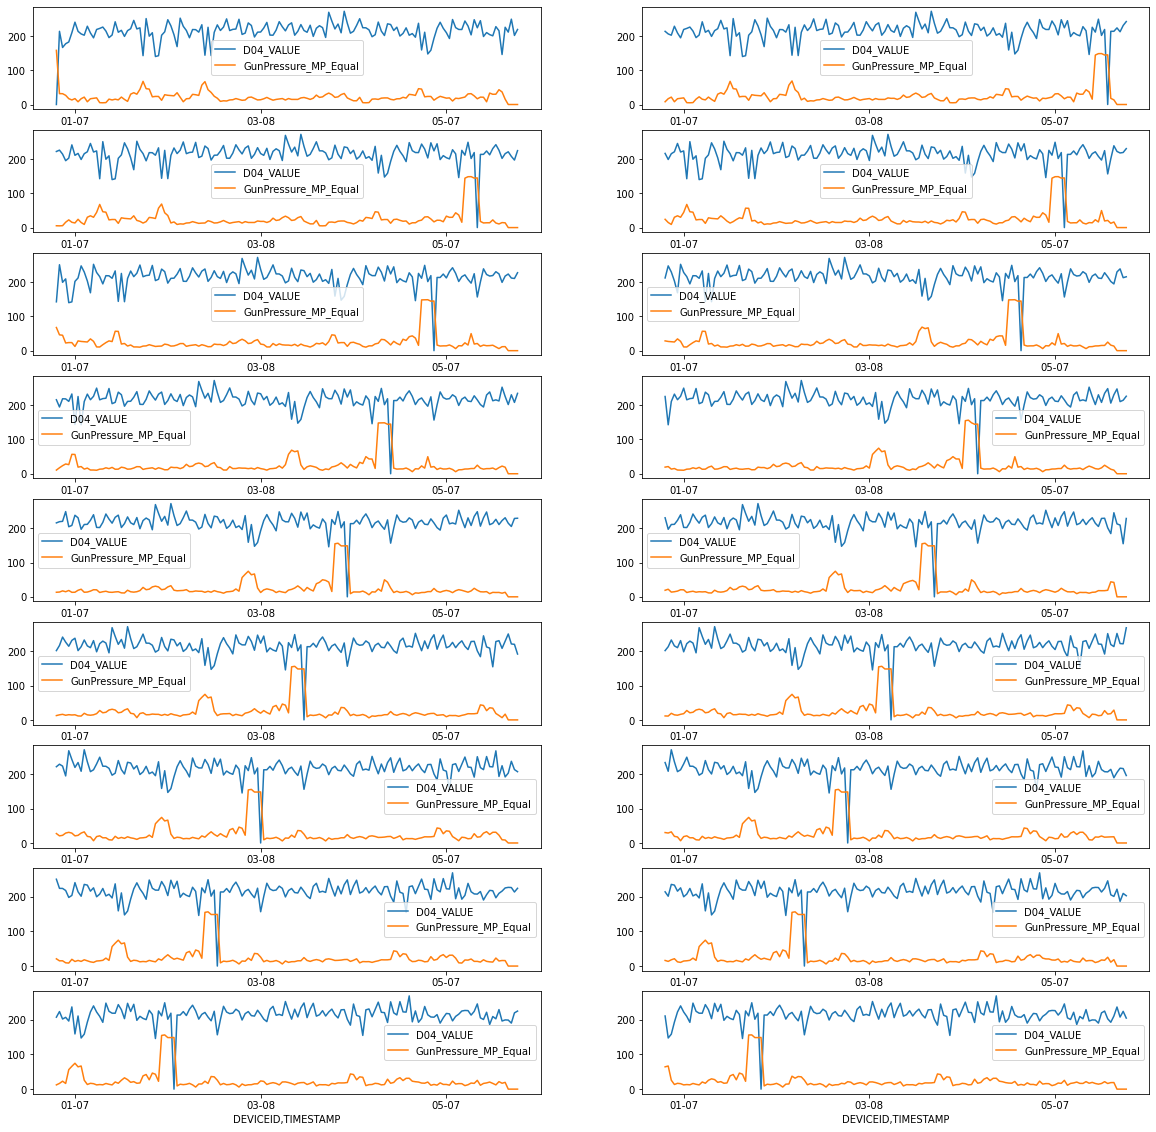

In [24]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs_reg:
    df_part[['D04_VALUE','GunPressure_MP_Equal']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0